In [8]:
from rdflib import ConjunctiveGraph
from jinja2 import Template
import seaborn as sns 
import matplotlib.pyplot as plt
import json
from pyshacl import validate
from IPython.display import display, Markdown, Latex

from crawl_and_lift import rdfize, crawl_biotools
import urllib3
import requests

%matplotlib inline

# 1. Mapping bio.tools to BioSchemas.org terms

In [9]:
mapping_attributes_bioschema = {}
mapping_attributes_bioschema['name'] = "schema:name" #done
mapping_attributes_bioschema['description'] = "schema:description" #done
mapping_attributes_bioschema['homepage'] = "schema:url" #done
#mapping_attributes_bioschema['biotoolsID'] = ""
#mapping_attributes_bioschema['biotoolsCURIE'] = ""
mapping_attributes_bioschema['toolType'] = "schema:additionalType" #done
mapping_attributes_bioschema['topic'] = "schema:applicationSubCategory" #done
mapping_attributes_bioschema['cost'] = "schema:isAccessibleForFree" #done
mapping_attributes_bioschema['publicationPrimary'] = "schema:citation" #done
mapping_attributes_bioschema['creditprimaryContact'] = "biotools:primaryContact" #done
mapping_attributes_bioschema['operation'] = "schema:featureList" #done
mapping_attributes_bioschema['inputData'] = "edam:has_input" #done
mapping_attributes_bioschema['outputData'] = "edam:has_output" #done
mapping_attributes_bioschema['operatingSystem'] = "schema:operatingSystem" #done
mapping_attributes_bioschema['license'] = "schema:license" #done
mapping_attributes_bioschema['apiDocumentation'] = "schema:softwareHelp" #done
mapping_attributes_bioschema['generalDocumentation'] = "schema:softwareHelp" #done
#mapping_attributes_bioschema['commandlineOptions'] = "biotools:commandlineOptions" # any availabe ?
mapping_attributes_bioschema['termsOfUse'] = "schema:termsOfService" # any availabe ?

# 2. Loading the information profile and replacing attributes with BioSchemas terms

In [10]:
mandatory_rules = []
with open('../profiles/ifbToolInfoProfile.json', 'r') as f:
    profile = json.load(f)
for r in profile['rules']:
    if 'Mandatory' in r['requirement']:
        print(r)
        std_attributes = []
        for at in r['attributes']: 
       # 1. Loading an information profile     if at in mapping_attributes_bioschema.keys():
                if at in mapping_attributes_bioschema.keys():
                    std_attributes.append(mapping_attributes_bioschema[at])
        r['attributes']=std_attributes
        print(r)
        mandatory_rules.append(r)
        print()
        print()

{'attributes': ['name', 'description', 'homepage', 'biotoolsID', 'biotoolsCURIE', 'toolType', 'topic', 'cost', 'publicationPrimary', 'creditprimaryContact'], 'constraint': 'all', 'types': ['Command-line tool', 'Desktop application', 'Web application', 'Database portal', 'Bioinformatics portal'], 'requirement': 'Mandatory', 'comment': 'MANDATORY attributes for ALL main 5 tool types'}
{'attributes': ['schema:name', 'schema:description', 'schema:url', 'schema:additionalType', 'schema:applicationSubCategory', 'schema:isAccessibleForFree', 'schema:citation', 'biotools:primaryContact'], 'constraint': 'all', 'types': ['Command-line tool', 'Desktop application', 'Web application', 'Database portal', 'Bioinformatics portal'], 'requirement': 'Mandatory', 'comment': 'MANDATORY attributes for ALL main 5 tool types'}


{'attributes': ['operation'], 'types': ['Command-line tool', 'Desktop application', 'Web application', 'Database portal'], 'requirement': 'Mandatory'}
{'attributes': ['schema:feature

# 3. Generating a SHACL shape from a list of mandatory properties

In [11]:
shape_template = """
@prefix dash: <http://datashapes.org/dash#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema: <http://schema.org/> .
@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix edam: <http://edamontology.org/> .
@prefix biotools: <https://bio.tools/ontology/> .

{% for rule in rules %}
schema:ToolShape
    a sh:NodeShape ;
    sh:targetClass schema:SoftwareApplication ;

    sh:filterShape [
        sh:property [
            sh:path schema:additionalType ;
            sh:in ( {% for type in rule['types'] %} "{{ type }}" {% endfor %} ) ;
        ] ;
    ] ;

    {% for prop_name in rule['attributes'] %}
    sh:property [
        sh:path {{prop_name}} ;
        sh:minCount 1 ;
    ] ;
    {% endfor %}
    .
{% endfor %}
"""

template = Template(shape_template)
shape = template.render(rules=mandatory_rules)
print(shape)
g = ConjunctiveGraph()
g.parse(data = shape, format='turtle')
print(len(g))


@prefix dash: <http://datashapes.org/dash#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema: <http://schema.org/> .
@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix edam: <http://edamontology.org/> .
@prefix biotools: <https://bio.tools/ontology/> .


schema:ToolShape
    a sh:NodeShape ;
    sh:targetClass schema:SoftwareApplication ;

    sh:filterShape [
        sh:property [
            sh:path schema:additionalType ;
            sh:in (  "Command-line tool"  "Desktop application"  "Web application"  "Database portal"  "Bioinformatics portal"  ) ;
        ] ;
    ] ;

    
    sh:property [
        sh:path schema:name ;
        sh:minCount 1 ;
    ] ;
    
    sh:property [
        sh:path schema:description ;
        sh:minCount 1 ;
    ] ;
    
    sh:property [
        sh:path schema:url ;
        sh:minCount 1 ;
    ] ;
    
    sh:propert

# 4. Validating sample tools

In [12]:
tool_id = "workflow4metabolomics"
#tool_id = "raiss"
#tool_id = "Ocean_Gene_Atlas"
#tool_id = "varaft"

url = 'https://bio.tools/api/tool/'+tool_id+'?format=json'

r = requests.get(url)
tool = r.json()

#print(json.dumps(rdfize(tool), indent=4))

data_tool = ConjunctiveGraph()
data_tool.parse(data = rdfize(tool), format="json-ld")

print(data_tool.serialize(format="turtle").decode())

r = validate(data_graph = data_tool, 
             data_graph_format='turtle', 
             shacl_graph = shape, 
             #shacl_graph = my_shacl_constraint,
             shacl_graph_format = 'turtle', 
             ont_graph = None, 
             inference = 'rdfs', 
             abort_on_error = False, 
             meta_shacl = False, 
             debug = True)

conforms, results_graph, results_text = r

report_query = """
    SELECT ?node ?path WHERE {
        ?v rdf:type sh:ValidationReport ;
           sh:result ?r .
        ?r sh:focusNode ?node ;
           sh:sourceShape ?s . 
        ?s sh:path ?path . 
    }
"""

results = results_graph.query(report_query)
for r in results :
    display(Markdown('The tool `{}` should be fixed, it is missing information for field {}'.format(str(r['node']), str(r['path']))))
    #display(Markdown(' **It was produced in the context of** ' + str(r['st']) ))
    
print(str(len(results))+ ' actions needed to fix mandatory')

#print(results_text)

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/workflow4metabolomics>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/workflow4metabolomics>
	Result Path: schema:license



@prefix biotools: <https://bio.tools/ontology/> .
@prefix bsc: <http://bioschemas.org/> .
@prefix edam: <http://edamontology.org/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix sc: <http://schema.org/> .
@prefix xml: <http://www.w3.org/XML/1998/namespace> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<https://bio.tools/workflow4metabolomics> a sc:SoftwareApplication ;
    edam:has_input edam:data_0943,
        edam:data_3488 ;
    sc:additionalType "Bioinformatics portal" ;
    sc:applicationSubCategory edam:topic_2259,
        edam:topic_3172,
        edam:topic_3307 ;
    sc:author <https://orcid.org/0000-0001-8177-4873>,
        "Jean-François Martin",
        "Marion Landi",
        "Misharl Monsoor",
        "Mélanie Pétéra",
        "Pierre Pericard" ;
    sc:citation <https://doi.org/10.1016/j.biocel.2017.07.002>,
        <https://doi.org/10.1093/bioinformatics/btu813> ;
    sc:contributor "

The tool `https://bio.tools/workflow4metabolomics` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/workflow4metabolomics` should be fixed, it is missing information for field http://schema.org/license

2 actions needed to fix mandatory


# 5. Validating the shape on the SDP graph data

In [6]:
from pyshacl import validate
from IPython.display import display, Markdown, Latex

sdp = "elixir-fr-sdp-2019"
data = crawl_biotools(collection=sdp)

print(len(g))
#g.serialize(format='turtle', destination='sdp.biotools.bioschema.ttl')
#print('BioSchema output produced at sdp.biotools.bioschema.ttl')
#g.serialize(format='json-ld', auto_compact=True, destination='sdp.biotools.bioschema.json-ld')
#print('BioSchema output produced at sdp.biotools.bioschema.json-ld')

#data = ConjunctiveGraph()
#data.parse("./sdp.biotools.bioschema.ttl", format='turtle')
#print(len(data))

r = validate(data_graph = data, 
             data_graph_format='turtle', 
             #shacl_graph = manual_shape_constraint, 
             shacl_graph = shape, 
             shacl_graph_format = 'turtle', 
             ont_graph = None, 
             inference = 'rdfs', 
             abort_on_error = False, 
             meta_shacl = False, 
             debug = False)

conforms, results_graph, results_text = r

#if not conforms:
#    print(results_graph.serialize(format='turtle').decode())
#else:
#    print('Everything is fine')

17148 available BioTools entries
138


# 6. Producing an explaination for the validation graph

In [24]:
report_query = """
    SELECT ?node ?path WHERE {
        ?v rdf:type sh:ValidationReport ;
           sh:result ?r .
        ?r sh:focusNode ?node ;
           sh:sourceShape ?s . 
        ?s sh:path ?path . 
    }
"""

results = results_graph.query(report_query)
for r in results :
    display(Markdown('The tool `{}` should be fixed, it is missing information for field {}'.format(str(r['node']), str(r['path']))))
    #display(Markdown(' **It was produced in the context of** ' + str(r['st']) ))
    
print(str(len(results))+ ' actions needed to fix mandatory description in Elixir-FR service delivery plan')

The tool `https://bio.tools/lordec` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/BISE` should be fixed, it is missing information for field http://schema.org/citation

The tool `https://bio.tools/Ciona_robusta_Anatomy_and_Development_Ontology` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/rsat` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool `https://bio.tools/SouthGreen` should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool `https://bio.tools/CRISPRCas` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/Genomicus-protists` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/Cocoa_Genome_Hub` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/Genomicus-protists` should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool `https://bio.tools/rsat` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/WheatIS` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/Genomicus-fungi` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/SouthGreen` should be fixed, it is missing information for field http://schema.org/additionalType

The tool `https://bio.tools/gnpis` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool `https://bio.tools/Genomicus-Plants` should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool `https://bio.tools/WheatIS` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/CRISPRCas` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/SulfAtlas` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/metexplore` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/SouthGreen_Galaxy` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/phylogeny.fr` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/Galaxy_Pasteur` should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool `https://bio.tools/BISE` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/Genomicus-fungi` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/Genomicus-protists` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/GalaxEast` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool `https://bio.tools/GalaxyCat` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/Genomicus-Plants` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/matrixdb` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/Genomicus-metazoa` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/phylogeny.fr` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/GalaxyCat` should be fixed, it is missing information for field http://schema.org/citation

The tool `https://bio.tools/Galaxy_Pasteur` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/Genomicus-protists` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/CRISPRCas` should be fixed, it is missing information for field http://schema.org/featureList

The tool `https://bio.tools/GENOMICUS` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/imgt` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/GalaxyCat` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/Genomicus-protists` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/Ocean_Gene_Atlas` should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool `https://bio.tools/Genomicus-fungi` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/lordec` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/rsat` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/gnpis` should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool `https://bio.tools/GalaxyCat` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/SulfAtlas` should be fixed, it is missing information for field http://schema.org/citation

The tool `https://bio.tools/SulfAtlas` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/Genomicus-Plants` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/GENOMICUS` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/GalaxEast` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/imgt` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/Galaxy_Pasteur` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/Rice_Genome_Hub` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/workflow4metabolomics` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/Rice_Genome_Hub` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/NORINE` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/GalaxEast` should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool `https://bio.tools/Genomicus-metazoa` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/Genomicus-Plants` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/ginsim` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/Banana_Genome_Hub` should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool `https://bio.tools/NORINE` should be fixed, it is missing information for field http://schema.org/featureList

The tool `https://bio.tools/GalaxEast` should be fixed, it is missing information for field http://schema.org/citation

The tool `https://bio.tools/CRISPRCas` should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool `https://bio.tools/Lifemap` should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool `https://bio.tools/Genomicus-fungi` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/matrixdb` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool `https://bio.tools/Ciona_robusta_Anatomy_and_Development_Ontology` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/phylogeny.fr` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/Galaxy_Pasteur` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/SulfAtlas` should be fixed, it is missing information for field http://schema.org/featureList

The tool `https://bio.tools/lordec` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/SouthGreen` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/NORINE` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/phylogeny.fr` should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool `https://bio.tools/GalaxEast` should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool `https://bio.tools/Galaxy_Pasteur` should be fixed, it is missing information for field http://schema.org/featureList

The tool `https://bio.tools/lordec` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool `https://bio.tools/NORINE` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/Sugarcane_Genome_Hub` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/Genomicus-metazoa` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/GalaxEast` should be fixed, it is missing information for field http://schema.org/featureList

The tool `https://bio.tools/SouthGreen_Galaxy` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/NORINE` should be fixed, it is missing information for field http://schema.org/citation

The tool `https://bio.tools/Genomicus-Plants` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/GalaxyCat` should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool `https://bio.tools/GalaxyCat` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/SouthGreen_Galaxy` should be fixed, it is missing information for field http://schema.org/citation

The tool `https://bio.tools/varaft` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/Genomicus-fungi` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/WheatIS` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/ginsim` should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool `https://bio.tools/GENOMICUS` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/CRISPRCas` should be fixed, it is missing information for field http://schema.org/citation

The tool `https://bio.tools/Rice_Genome_Hub` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/BISE` should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool `https://bio.tools/phylogeny.fr` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/MicroScope_platform` should be fixed, it is missing information for field http://schema.org/citation

The tool `https://bio.tools/metexplore` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/NORINE` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/Galaxy_Pasteur` should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool `https://bio.tools/Ocean_Gene_Atlas` should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool `https://bio.tools/Galaxy_Pasteur` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/CRISPRCas` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/SouthGreen` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/GENOMICUS` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/GalaxEast` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/GalaxEast` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/SouthGreen_Galaxy` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/SulfAtlas` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/WheatIS` should be fixed, it is missing information for field http://schema.org/citation

The tool `https://bio.tools/Sugarcane_Genome_Hub` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/Genomicus-fungi` should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool `https://bio.tools/matrixdb` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/GalaxyCat` should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool `https://bio.tools/imgt` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/Rice_Genome_Hub` should be fixed, it is missing information for field http://schema.org/citation

The tool `https://bio.tools/MicroScope_platform` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/Ciona_robusta_Anatomy_and_Development_Ontology` should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool `https://bio.tools/CRISPRCas` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool `https://bio.tools/Ciona_robusta_Anatomy_and_Development_Ontology` should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool `https://bio.tools/SouthGreen` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool `https://bio.tools/CRISPRCas` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/SouthGreen` should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool `https://bio.tools/SouthGreen_Galaxy` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool `https://bio.tools/SouthGreen_Galaxy` should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool `https://bio.tools/aureme` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/Genomicus-Plants` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/NORINE` should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool `https://bio.tools/GalaxyCat` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/Rice_Genome_Hub` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/MicroScope_platform` should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool `https://bio.tools/CRISPRCas` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/rsat` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/SulfAtlas` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/Galaxy_Pasteur` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/workflow4metabolomics` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/SouthGreen` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/aria` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/GalaxyCat` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool `https://bio.tools/SouthGreen_Galaxy` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/repet` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/matrixdb` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/Rice_Genome_Hub` should be fixed, it is missing information for field http://schema.org/additionalType

The tool `https://bio.tools/WheatIS` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/phyml` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/Genomicus-metazoa` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/SulfAtlas` should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool `https://bio.tools/CRISPRCas` should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool `https://bio.tools/matrixdb` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/MicroScope_platform` should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool `https://bio.tools/parameciumdb` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/NORINE` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool `https://bio.tools/NORINE` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/varaft` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/oligo-analysis` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/SulfAtlas` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool `https://bio.tools/gnpis` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/Ciona_robusta_Anatomy_and_Development_Ontology` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/CRISPRCas` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/SulfAtlas` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/SouthGreen` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/Genomicus-metazoa` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/GalaxEast` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/Genomicus-Plants` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/SulfAtlas` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/Genomicus-metazoa` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/Genomicus-protists` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/Rice_Genome_Hub` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/Cocoa_Genome_Hub` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/Lifemap` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/RSAT-position-analysis` should be fixed, it is missing information for field http://schema.org/termsOfService

The tool `https://bio.tools/Genomicus-metazoa` should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool `https://bio.tools/Galaxy_Pasteur` should be fixed, it is missing information for field http://schema.org/citation

The tool `https://bio.tools/NORINE` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/GalaxEast` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/Galaxy_Pasteur` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool `https://bio.tools/GalaxyCat` should be fixed, it is missing information for field http://schema.org/featureList

The tool `https://bio.tools/SouthGreen_Galaxy` should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool `https://bio.tools/lordec` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/imgt` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/Genomicus-protists` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/SouthGreen` should be fixed, it is missing information for field http://schema.org/featureList

The tool `https://bio.tools/repet` should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool `https://bio.tools/WheatIS` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/GalaxyCat` should be fixed, it is missing information for field http://schema.org/additionalType

The tool `https://bio.tools/aureme` should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool `https://bio.tools/gnpis` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/GENOMICUS` should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool `https://bio.tools/GalaxyCat` should be fixed, it is missing information for field http://edamontology.org/has_output

The tool `https://bio.tools/NORINE` should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool `https://bio.tools/Galaxy_Pasteur` should be fixed, it is missing information for field http://edamontology.org/has_input

The tool `https://bio.tools/SulfAtlas` should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool `https://bio.tools/Genomicus-fungi` should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool `https://bio.tools/NORINE` should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The tool `https://bio.tools/imgt` should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool `https://bio.tools/SouthGreen_Galaxy` should be fixed, it is missing information for field http://schema.org/featureList

The tool `https://bio.tools/GalaxEast` should be fixed, it is missing information for field http://schema.org/license

The tool `https://bio.tools/MicroScope_platform` should be fixed, it is missing information for field http://schema.org/termsOfService

199 actions needed to fix mandatory description in Elixir-FR service delivery plan


# 7. (long) Launching the validation on a large dataset

In [26]:
%%time

data = crawl_biotools(limit=1000)
print(len(data))
data.serialize(format='turtle', destination='test.biotools.bioschema.ttl')

r = validate(data_graph = 'test.biotools.bioschema.ttl', 
             data_graph_format='turtle', 
             shacl_graph = shape, 
             shacl_graph_format = 'turtle', 
             ont_graph = None, 
             inference = 'rdfs', 
             abort_on_error = False, 
             meta_shacl = False, 
             debug = True)

conforms, results_graph, results_text = r

results = results_graph.query(report_query)
for r in results :
    display(Markdown('The tool {} should be fixed, it is missing information for field {}'.format(str(r['node']), str(r['path']))))

print(str(len(results))+ ' actions needed to fix mandatory description bio.tools')

17147 available BioTools entries
3 % done
6 % done
15186


Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/Genomicus-tunicates>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/IMGT_HighV-QUEST>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/Mann-Kendall>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCou

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/GE_LDA_Survival>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/PACKMAN>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/disco_autogenerated>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountCons

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/RHPCG>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/HILJ>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/B88>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: 

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/open-data>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/PCA>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/SIRM>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severi

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/tree_shape_statistics>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/scMNase-seq>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/Topological_Tumor_Graphs>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/sha

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/nanopore>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/diffGrad>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/Paragraph_autogenerated>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstr

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/NeoPeptide>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/ICGRM>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/TestIME>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/pyPESTO>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/NeuroPostureApp>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/B86>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent)

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/RRphylo>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/SEQdata-BEACON>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/CMAC>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent)

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/CeutaOPEN>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/TabSINT>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/org>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Sev

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/ParLECH>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/tsMSQ>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/PATHFx>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Seve

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/NmSEER_V2.0>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/PhySpeTree>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/IDH1mut_cancers>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstrain

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/yakusa>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/DIME>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/PSI-SMALP>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Sev

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/9aaTAD>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/patents>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/withdrawal>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):


Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/eQTL>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/mrdna>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/CCC-Tool>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Sever

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/scReClassify>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/PHENOSTAMP>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/TM3_seq>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCompon

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/LinkPhinder>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/RNAactDrug>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/deBGA-VARA>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/PASTMUS>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/geoportalgasolineras>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/Mobilum>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/SSnet>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/microscopemage>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/publicly-available>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstrai


Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/GroScore>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/data-driven_materials_science>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/meta-analysis_rare_variant>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.or

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/PIRCh-seq>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/GSEA_autogenerated>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/PhyDL_autogenerated>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCoun

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/pirouette>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/UPObase>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/OPD>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Sev

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/Natural_Products_Atlas>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/VGE>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.tools/directors>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/SAXSDom>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/VSAQs>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/x-mate>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/PACKMAN>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/disco_autogenerated>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/iMED>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (ht

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/ssNPA>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/gazecom_annotations>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/VariantStore>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintCompone

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/pancancer>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/Ciona_robusta_Anatomy_and_Development_Ontology>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/aesthetic_damage>
	Result Path: schema:operatingSystem

Constraint Vio

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/CATHER>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/CBNA>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/DDIGIP>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.or

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/scale-up>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/FXD-CSD-GUI>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/mpss>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://ww

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/action>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/GABAC>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/ctmmweb>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/DEPICTER>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/25000_ug_BPA_kg_bw>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/HOPS_autogenerated>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstrain

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/SLNPM-SC_SLNPM-PC>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/PySpacell>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/Halobenzenes_Xylenes>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstra

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/PiVR>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/NUMT>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/ONDRI>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/n

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/IMGT_PhyloGene>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/qmmm>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/SAMIRIX>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/Vireo>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/DIVERCROP>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/frog2>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/epivizFileServer>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/dLsd1>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/GEDFN>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http:/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/ABC-CT>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/RCorp>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/MiCA>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/InSituAnalyze>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/EUFEMED>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/UNet>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/ProTargetMiner>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/closed-loop>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/Webina>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (h

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/IMGT_GeneInfo>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/WebAnno>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/ngsReports>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (ht

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/LocPL>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/QRISK3>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/dbMMR-Chinese>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/TargetScanHuman>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/3DSlicer_autogenerated>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/eQTL>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/Phthiraptera.info>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/UNI-EM>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/getcontacts>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/online-chem>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/SweHLA>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/fpocket>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/BPRF>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/Broccoli>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/OpenProtein>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://ww

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/LIMES>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/PhysMPrePro>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/TRANSNAP>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/EvolClust>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/MinION>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/LP-SDA>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/PGxMine>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/SSnet>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/publicly-available>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (ht

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/data-driven_materials_science>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/monores>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/meta-analysis_rare_variant>
	Result Path: schema:operatingSystem

Constraint Violation in

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/BeamDelta_autogenerated>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/gencore>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/FCM-m>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponen

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/PALMER>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/iProDNA-CapsNet>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/VASE>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/PANPASCO>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/PATOPA>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/elastix>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/GMCLDA>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/CCLA>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/TAD-Lactuca>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/Pelodiscus_sinensis>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.tools/BORIS>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:featureList ]
	Focus Node: <https://bio.tools/VSAQs>
	Result Path: schema:featureList

Constraint Violation in MinCountConstraintComponent (http://www.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:featureList ]
	Focus Node: <https://bio.tools/tactile_glove>
	Result Path: schema:featureList

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:featureList ]
	Focus Node: <https://bio.tools/TestIME>
	Result Path: schema:featureList

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:featureList ]
	Focus Node: <https://bio.tools/NORINE>
	Result Path: schema:featureList

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#Min

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:featureList ]
	Focus Node: <https://bio.tools/Phthiraptera.info>
	Result Path: schema:featureList

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:featureList ]
	Focus Node: <https://bio.tools/UNI-EM>
	Result Path: schema:featureList

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:featureList ]
	Focus Node: <https://bio.tools/Nursing>
	Result Path: schema:featureList

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:featureList ]
	Focus Node: <https://bio.tools/IsoCor>
	Result Path: schema:featureList

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:featureList ]
	Focus Node: <https://bio.tools/JUDI>
	Result Path: schema:featureList

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:featureList ]
	Focus Node: <https://bio.tools/fireworks>
	Result Path: schema:featureList

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/SPLBoost>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/Circle-Map>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/Hass>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCompone

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/B920>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/giggle>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/DeepEP>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/scifi-RNA-seq>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/DeepSV>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/RHPCG>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCompo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/linkage>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/COBRA_Toolbox>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/treeko>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCom

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/CBNA>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/DDIGIP>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/sweep>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	S

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/functional_GWAS>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/COUSIN>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/scale-up>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraint

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/OpenCRG>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/SPIEC-EASI>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/GABAC>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCompone

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/eQTL_autogenerated>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/Kaposi>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/maldsoft>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstra

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/phylomedb_v3.0>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/SiRJ>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/gvista>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCompo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/RemeDB>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/metaphors>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/VarGen>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponen

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/HaploTypo>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/wtdbg2>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/PhenX_autogenerated>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConst

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/NeuronSubtypeTranscriptomes>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/Sentinel-1_SLC>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/IMGT-ONTOLOGY>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/Legumefix_Sympal_vermicompost_Legumefix_Sympal>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/ModEx>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/Transition_Scale-Spaces>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/Fluor>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/RAPPAS>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/ICU_readmissions>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/PG-HACKER>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/OAC>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/consensusDE>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCompon

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/Contrasting>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/matrixdb>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/VOCCluster>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraint

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/PSI-SMALP>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/OpenFlexure>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/iDASH>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/polyphen-2>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/Genomicus-protists>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/FACEPAI>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountCons

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/shotgun>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/ASD-DiagNet>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/FlyCircuit>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/Jaccard>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/RocaSec>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/CellCountCV>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/plink-seq>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/mesophotic.org>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/methylCC>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstrai

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/PDGA_autogenerated>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/Seurat_SingleR>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/GO2Vec>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/araport>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/RNAactDrug>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/deBGA-VARA>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/hotspotter>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/workflow4metabolomics>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/HIV-DRLink>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCou

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/String-pulling>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/NanoCaller>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/lordec>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstrain

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/publicly-available>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/FilterDCA>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/scdney>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstr

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/TcellSubC>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/autoantigenomics>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/AdaTiSS>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstra

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/pest>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/AtFKBP53>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/sugsvarsel>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCompone

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/COMUNET>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/OrdinalGWAS.jl>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/MADOKA>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/imgt>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/DDI-PULearn>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/KBCommons>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCompo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/CCLA>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/zplan>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/TAD-Lactuca>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/Pred-MutHTP>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/Pelodiscus_sinensis>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.tools/BORIS>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountCons

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/AlphaFamImpute>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/CaptureProbe>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/National_Preparedness_Month>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponen

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/isthmic_spondylolisthesis_degenerative_spondylolisthesis>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/TraceMontage>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/chemfp_autogenerated>
	Result Path: schema:softwareHelp

Constraint Viol

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/PsyMuKB>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/TRiP_autogenerated>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/CRISPRCas>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.or

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/coil>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/PRIDE_autogenerated>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/HistoneAnalysisWorkflow>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/tree_shape_statistics>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/scMNase-seq>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/Topological_Tumor_Graphs>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintCompo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/OpenCRG>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/SPIEC-EASI>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/GABAC>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#M

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/qmsat>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/DEPICTER>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/25000_ug_BPA_kg_bw>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/n

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/SLNPM-SC_SLNPM-PC>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/PySpacell>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/Halobenzenes_Xylenes>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/ONDRI>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/VCF2PopTree_autogenerated>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/deepsig>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/FunGeCo>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/XFlow>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/cgqtl>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCou

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/CeutaOPEN>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/wtest>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/TabSINT>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#Mi

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/biosciences-labs>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/ILMF-VH>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/PyMOL_autogenerated>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/VAD_Emergency>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/RBPome>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/PG-HACKER>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/s

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/VOCCluster>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/NetworkAnalyst_autogenerated>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/GSE64617>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/MS2CNN>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/Nucleome_Data_Bank>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/MultiFRET>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/ForestQC>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/qgg>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/Genomicus-metazoa>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/s

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/DrOn>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/nomophobia>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/Health_United_States_2017>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/PCMBase>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/incarceration>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/Venn-diaNet>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/n

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/TM3_seq>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/AutoEncoder>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/SpliceFinder>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/Phen2Gene>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/DTA-SiST>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/scanpath>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shac

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/SimpactCyan>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/NNCI>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/AACTT>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#Min

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/EvolClust>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/MinION>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/LP-SDA>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#Mi

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/publicly-available>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/FilterDCA>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/scdney>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/TcellSubC>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/autoantigenomics>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/AdaTiSS>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/ASHLAR>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/uslcount>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/STORM_autogenerated>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/MOF_coating>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/cancer_subtyping>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/NIPT>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/n

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/hla-net>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/Clair>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/Pneumocystis>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/QuantiMus>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/Kmasker_plants>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/BioMedR>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:applicationSubCategory ]
	Focus Node: <https://bio.tools/withdrawal>
	Result Path: schema:applicationSubCategory

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:applicationSubCategory ]
	Focus Node: <https://bio.tools/SPROUTS>
	Result Path: schema:applicationSubCategory

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:applicationSubCategory ]
	Focus Node: <https://bio.tools/OpenProtein>
	Result Path: schema:applicationSubCategory

Constraint Viol

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/pathway>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/HTRgene>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/alphaimpute>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/GE_LDA_Survival>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/SNPector_autogenerated>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/PACKMAN>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintCompo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/SingleCellSignalR>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/rKIN>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/edge-pro>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://ww

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/repet>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/HapMap>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/parameciumdb>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.o

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/COBRA_Toolbox>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/treeko>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/aesthetic_damage>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (htt

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/themetagenomics>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/CATHER>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/CBNA>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/scMNase-seq>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/Topological_Tumor_Graphs>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/functional_GWAS>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstrain

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/longitudinal_multiomic_analysis_public>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/Notch>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/motoRneuron>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConst

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/IgE-antibody_binding>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/Genomicus-fungi>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/ADMMBO>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponen

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/FConverter>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/NeoPeptide>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/tactile_glove>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http:

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/GenomicTools_autogenerated>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/selsim>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/SyRI>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (ht

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/NUMT>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/ONDRI>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/pyfaidx>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/s

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/HastaLaVista>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/RRphylo>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/SEQdata-BEACON>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http:

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/Sentinel-1_SLC>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/IMGT-ONTOLOGY>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/STRIDE_autogenerated>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintCo


Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/CeutaOPEN>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/arlequin>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/wtest>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.o

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/FRASER>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/SNP-CRISPR_autogenerated>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/DNA_autogenerated>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/MiCA>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/genomatix_genegrid>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/scattermore>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http:

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/InSituAnalyze>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/EUFEMED>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/UNet>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/Temporal_trends_public_mass_shootings>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/clock>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/OMERO_autogenerated>
	Result Path: schema:termsOfService

Constraint Violation in MinCou

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/iDASH>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/TWOMBLI>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/Deep_Docking>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/SMART_App>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/NLP_ML>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/LPM>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/latent_Gaussian_copula_model>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/yalff_autogenerated>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/CYBERTRACK>
	Result Path: schema:termsOfService

Constraint Violation in MinCountCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/mrdna>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/WHdenovo>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/CCC-Tool>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/TNFR1>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/Phthiraptera.info>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/UNI-EM>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/TM3_seq>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/AutoEncoder>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/SpliceFinder>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/physician-scientists_OHSU>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/rnnimp>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/BioGears_Engine>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintCom

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/SVs>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/ASA24>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/RatHat>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/sha

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/CS2Structure>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/Mobilum>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/LDAKM-EIoT>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://ww

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/pedig>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/metabolic_pathway_prediction>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/CMVdb>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/FilterDCA>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/scdney>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/protein_model_portal>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (htt

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/Wang-xiaoheng>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/perfectphyloR>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/RAACBook>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/IMGT_DomainDisplay>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/popSTR2>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/BiTSC>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/AlphaBeta>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/PhyDL_autogenerated>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/CPP>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/iACetyP>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/imgt_v-quest>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/PheGWAS>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/Pneumocystis>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/HIRAC>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/prosight_lite>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/VGE>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/Dynamic_Meta-Storms>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/directors>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/Pelodiscus_sinensis>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.tools/BORIS>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/Genomicus-tunicates>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://ww

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/Circle-Map>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/Hass>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/Coinfinder>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/giggle>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/DeepEP>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/Citrusgreening.org>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCompo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/DeepSV>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/RHPCG>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/digilogger>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	S

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/COBRA_Toolbox>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/treeko>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/aesthetic_damage>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraint

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/DDIGIP>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/sweep>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/ceRNA>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severi

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/COUSIN>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/scale-up>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/xp-ehh>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Se

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/SPIEC-EASI>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/GABAC>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/ARGP>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Sev

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/eQTL_autogenerated>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/Kaposi>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/maldsoft>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCom

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/phylomedb_v3.0>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/SiRJ>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/gvista>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/RemeDB>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/metaphors>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/VarGen>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	S

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/HaploTypo>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/wtdbg2>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/PhenX_autogenerated>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/NeuronSubtypeTranscriptomes>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/Sentinel-1_SLC>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/IMGT-ONTOLOGY>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/Legumefix_Sympal_vermicompost_Legumefix_Sympal>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/ModEx>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/Transition_Scale-Spaces>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http:/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/Fluor>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/ICU_readmissions>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/RE-AIM_autogenerated>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountCons

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/OAC>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/consensusDE>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/GEAN>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Seve

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/gnpis>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/matrixdb>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/VOCCluster>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):


Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/OpenFlexure>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/iDASH>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/TWOMBLI>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):


Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/CFIR_autogenerated>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/OnTAD>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/deconvolution_estimate_immune_cell_subsets>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.o

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/MuPIPR>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/SigUNet>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/subgraphquant>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/GPU>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/gerp>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/come>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: s

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/miRsyn>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/NLP_autogenerated>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/FIREVAT>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCompo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/clumpak>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/SPROUTS>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/CIViCmine>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):


Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/Galaxy_Pasteur>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/PICO>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/ClusPro_LigTBM>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCom

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/CpGtools>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/scPred>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/CycloNovo>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):


Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/OntoKin>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/treeld>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/pedig>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Seve

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/snmf>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/GDB13>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/rgenesconverged>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/DEmiRs>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/IMGT_LocusView>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/Vargas>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/ASHLAR>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/fbat>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/uslcount>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Seve

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/DTSGUI>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/MaSIF>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/MOF_coating>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/HARDEN>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/mapp>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/iMIRAGE>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Sever

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/Natural_Products_Atlas>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/marge>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.tools/VGE>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCompo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/ribosome_profiling>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/Kaptive>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/polymarker>
	Result Path: schema:isAccessibleForFree

Constraint Violation in Mi

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/Coinfinder>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/DatView>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/survival_kit>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCount

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/MPF-BML>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/B920>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/DeepEP>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/HybridAtt>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/scifi-RNA-seq>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/DeepSV>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/linkage>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/treeko>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/aesthetic_damage>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCount

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/CATHER>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/CBNA>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/DDIGIP>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintCom

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/scMNase-seq>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/Topological_Tumor_Graphs>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/functional_GWAS>
	Result Path: schema:isAccessibleForFree

Constraint 

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/longitudinal_multiomic_analysis_public>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/Notch>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/motoRneuron>
	Result Path: schema:isAccessibleForFree

Constra

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/selaction>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/CTS>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/eQTL_autogenerated>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCoun

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/ADR>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/NORINE>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/TOXcms>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/drugvirus>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/pyPESTO>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/NeuroPostureApp>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCou

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/3DChrom>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/G-WIZ_autogenerated>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/embeddings_autogenerated>
	Result Path: schema:isAccessibleForFree

Constraint 

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/Microbe_Directory>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/cri-map>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/iQSP>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/ST-SIM>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/OCSVM>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/CeutaOPEN>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstrain

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/ImPLoc>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/OMGS>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/FRASER>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintCom

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/SouthGreen_Galaxy>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/Whisper_2>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/RestraintLib>
	Result Path: schema:isAccessibleForFree

Constraint Violation in

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/jhubiobank>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/Bio-DIA>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/UniprotR>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountCons

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/ProTargetMiner>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/closed-loop>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/Webina>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCou

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/IMGT_GeneInfo>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/WebAnno>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/ngsReports>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCoun

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/LocPL>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/yrgate>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/QRISK3>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/reproduce>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/ChemDataExtractor>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/medical_relation_extraction>
	Result Path: schema:isAccessibleForFree

Constrai

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/omia>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/PCMBase>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/incarceration>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConst

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/scReClassify>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/impute.me>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/PHENOSTAMP>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCou

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/hepatotoxicity>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/Glyco-CPLL>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/physician-scientists_OHSU>
	Result Path: schema:isAccessibleForFree

Constraint V

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/miRNA_autogenerated>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/IDEAS>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/MAtCHap>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCou

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/PASTMUS>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/geoportalgasolineras>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/CS2Structure>
	Result Path: schema:isAccessibleForFree

Constraint Violation i

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/metabolic_pathway_prediction>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/CMVdb>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/AHSURED>
	Result Path: schema:isAccessibleForFree

Constraint Violation 

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/snmf>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/GDB13>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/rgenesconverged>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConst

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/autoantigenomics>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/AdaTiSS>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/PathwayWP4754>
	Result Path: schema:isAccessibleForFree

Constraint Violation in M

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/bkbxxmrhfh>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/pest>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/AtFKBP53>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstra

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/PALMER>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/iProDNA-CapsNet>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/VASE>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountCons

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/OLGenie>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/PANPASCO>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/PATOPA>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstrai

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/Ex-DOMAIN>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/CrIMMix>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/expansion-network>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/scSplit>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/JMIR>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.tools/JUDI>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/REPIC>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/ICIBM>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/RSRS>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/sha

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/FACS_autogenerated>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/pharmd>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/MPF-BML>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/digilogger>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/HILJ>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/B88>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/VEF>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/Read-SpaM>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/MGMM>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/s

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/HmtVar>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/SpecHap>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/iPromoter-BnCNN>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/DeepRiPP>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/nhiss>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/wg-blimp>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/ADMMBO>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/Antimicrobial_peptide_identification>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/miRcode>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraint

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/TOXcms>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/SiRJ>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/PhySigs>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/LD-annot>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/16S>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/CNN-T4SE>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/n

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/riboflow_autogenerated>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/CMAC>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/SAMIRIX>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http:

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/CAMND>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/D3GRN>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/ST-SIM>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/s

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/SNP-CRISPR_autogenerated>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/DNA_autogenerated>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/BayesMetab>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstrai

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/LePrimAlign>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/Lancaster_Sensorimotor_Norms>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/VAD_Emergency>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstra

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/A-CaMP>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/Contrasting>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/VOCCluster>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/TWOMBLI>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/Deep_Docking>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/MS2CNN>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/RCMF>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/ForestQC>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/qgg>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/sh

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/DrOn>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/nomophobia>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/Health_United_States_2017>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent 

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/incarceration>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/Venn-diaNet>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/mri>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/AutoEncoder>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/SpliceFinder>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/Bayesian>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/scanpath>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/BPRF>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/Broccoli>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/LIMES>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/PhysMPrePro>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/TRANSNAP>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/LP-SDA>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/HdaB>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/GUcal>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/sh

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/scdney>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/MIAmaxent>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/GDB13>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/AdaTiSS>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/PathwayWP4754>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/DEmiRs>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/uslcount>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/STORM_autogenerated>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/M3S>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/cancer_subtyping>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/NIPT>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/Dominance_Sharing_Assessment>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/Pneumocystis>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/HIRAC>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/TOFF>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/GMultM>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/PEC>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.tools/Odonate_Phenotypic_Database>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (ht

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/QuAdTrim>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/SAXSDom>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/VSAQs>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#Min

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/iMED>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/MLVAType>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/ProDCoNN>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#Min

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/HybridAtt>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/scifi-RNA-seq>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/DeepSV>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/s

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/DILI>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/nutriNetwork>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/CAT>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/dataportal>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/GalaxyCat>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/GPRED-GC>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/sh

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/CryoFLARE>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/GBA>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/BenMAP-CE>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#Mi

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/DRV>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/altmod>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/TCSRWRLD>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCou

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/NeoPeptide>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/tactile_glove>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/ICGRM>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/s

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/drugvirus>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/pyPESTO>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/NeuroPostureApp>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/n

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/Arteria>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/3dSpAn>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/SPAG>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCou

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/Sentinel-1_SLC>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/STRIDE_autogenerated>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/START-R>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://ww

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/VSETP-UAV>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/KAM_KOR_KOR_YAK-1_YAK-1>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/SimNIBS_2.1>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/SIMPLE3.0>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/PATHFx>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/ChemEnv>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#M

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/QUINT>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/InSituAnalyze>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/UNet>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#M

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/Webina>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/PRIME-Tool>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/PERs>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#Min

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/sctransform>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/PTR>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/EPIC>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/BMCeasy>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/latent_Gaussian_copula_model>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/yalff_autogenerated>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintCompone

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/FOCS>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/deltaRpkm>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/carlet>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/Nursing>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/immunophenotype>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/methylCC>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/MIMIC-CXR>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/PDGA_autogenerated>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/Seurat_SingleR>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://ww

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/LinkPhinder>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/RNAactDrug>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/deBGA-VARA>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/n

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/CpGtools>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/scPred>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/CycloNovo>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/ClusPro2>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/DNA_Chisel>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/mixNBHMM>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/sha

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/HiPPO>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/GLAMbox_autogenerated>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/LRScaf>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/CGLFold>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/tealeaves>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/MUSIQUE-II>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/sha

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/StressGenePred>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/MUBD-DecoyMaker_2.0>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/CCMod>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/expression_variability>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/TEffectR>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/B69>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/wwligcsrre>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/DAISY>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/Ex-DOMAIN>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/JUDI>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/Bcool>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.tools/PHI-Nets>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCou

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:citation ]
	Focus Node: <https://bio.tools/SouthGreen_Galaxy>
	Result Path: schema:citation

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:citation ]
	Focus Node: <https://bio.tools/Proteo3Dnet>
	Result Path: schema:citation

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:citation ]
	Focus Node: <https://bio.tools/ShinySOM>
	Result Path: schema:citation

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountCon

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/GliomaDB>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/interface-LncCASE>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/Lifemap>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintCompo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/imeter>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/National_Preparedness_Month>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/proteindiffraction>
	Result Path: biotools:primaryContact

Constraint Violation in MinC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/Citrusgreening.org>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/fixseq>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/monovar>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintCompon

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/scifi-RNA-seq>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/DeepSV>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/RHPCG>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (ht

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/pQCT>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/pancancer>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/IMGT_GeneSearch>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/PRIDE_autogenerated>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/HistoneAnalysisWorkflow>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/MCDCalc>
	Result Path: biotools:primaryContact

Constraint Violation in MinCou

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/ClinVAP>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/GlyMDB>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/rcnn>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://ww

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/Ocean_Gene_Atlas>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/ExpansionHunter_Denovo>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/GOT-10k>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/phylogeny.fr>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/altmod>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/TCSRWRLD>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/DeepShape>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/allelic_inclusion>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/Min3>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintCompone

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/PySpacell>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/Halobenzenes_Xylenes>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/TIM-TAM>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/16S>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/CNN-T4SE>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/PiVR>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/HastaLaVista>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/RRphylo>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/SEQdata-BEACON>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/STRIDE_autogenerated>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/START-R>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/Rural>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintCompo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/MR-Clust>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/Legumefix_Sympal_vermicompost_Legumefix_Sympal>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/ModEx>
	Result Path: biotools:primaryContact

Constraint Violation

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/PyMOL_autogenerated>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/Cox-PASNet>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/PRP>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintCompo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/Lancaster_Sensorimotor_Norms>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/VAD_Emergency>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/RBPome>
	Result Path: biotools:primaryContact

Constraint Violation in MinCount

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/OutCyte>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/ihs>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/bridgedb>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/Bigram-PGK>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/ImmuCellAI>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/LEMON>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (h

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/ngsReports>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/adam>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/JCDB>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/yrgate>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/QRISK3>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/dbMMR-Chinese>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (h

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/ChemDataExtractor>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/medical_relation_extraction>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/TargetScanHuman>
	Result Path: biotools:primaryContact

Constraint Violation

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/Venn-diaNet>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/mri>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/TNFR1>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/PHENOSTAMP>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/Ped-sim>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/TM3_seq>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (ht

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/physician-scientists_OHSU>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/rnnimp>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/BioGears_Engine>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/MAtCHap>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/SVs>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/ASA24>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/geoportalgasolineras>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/CS2Structure>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/Mobilum>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstrai

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/pedig>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/metabolic_pathway_prediction>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/CMVdb>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstrain

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/snmf>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/IMGT_Collier-de-Perles>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/GDB13>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintCompon

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/autoantigenomics>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/AdaTiSS>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/PathwayWP4754>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/BeamDelta_autogenerated>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/gencore>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/FCM-m>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/lung>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/regional_imaging_genetic_associations>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/robot_autogenerated>
	Result Path: biotools:primaryContact

Constraint Violatio

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/TEffectR>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/B69>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/pirouette>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http:/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/KataegisPortal>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/ResDisMapper>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/uap>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponen


Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/PEC>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/Odonate_Phenotypic_Database>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path biotools:primaryContact ]
	Focus Node: <https://bio.tools/olanzapine>
	Result Path: biotools:primaryContact

Constraint Violation in MinCountConstr

The tool https://bio.tools/microscope should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/AtFKBP53 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/smart_cutter should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/mixNBHMM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DeepRiPP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BioMedR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TcellSubC should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/FilterDCA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TRANSNAP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/genomatix_genegrid should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/Ingenuity should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Circle-Map should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TasselNetv2 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Multilayer_Extraction should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/RADAR_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/proteindiffraction should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/25000_ug_BPA_kg_bw should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/faf-drugs should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Ped-sim should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AACTT should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/pest should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Vireo should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/curatedAdipoRNA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Phen2Gene should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/OnTAD should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/rpbs should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/IMGT_DomainGapAlign should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/DeepEP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/RNA-seq_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/prewas should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/IMGT_LIGM-DB should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/instaGRAAL should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/circRNA-disease should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MIMIC-CXR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ihs should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PG-HACKER should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/harmonization should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PRIDE_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Nursing should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/BISR-RNAseq should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/physician-scientists_OHSU should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DTSGUI should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DTA-SiST should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Metabolic_Disassembler should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ancestryinfer should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ALACD should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PERSONALISED_MEASUREMENT-BASED_CARE_YOUTH_MENTAL should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ICU_readmissions should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/escdb should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Storyline should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Genomicus-metazoa should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/uslcount should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ASM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SpliceFinder should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PACKMAN should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/JMIR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TB_Portals_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LTIP should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GLM-PCA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PASTMUS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/G-WIZ_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/VOCCluster should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SLNPM-SC_SLNPM-PC should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PACKMAN should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/RankerGUI should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/geoportalgasolineras should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SPAG should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/eCAMI should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PiVR should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/QuAdTrim should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Dynamic_Meta-Storms should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/BacHBerryEXP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LEMON should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Mango_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/WheatIS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/neoantigen should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/wtest should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Phen2Gene should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ezTrack should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/iMED should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/pep-fold should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Vargas should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/QUINT should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LandScape should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RAACBook should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RADAR_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/mri should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SSIPe should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/BORIS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DianaWeb should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/LCA-CNN should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/JUDI should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Min3 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ngsReports should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PCMBase should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/OpenFlexure should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Genomicus-metazoa should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/KBCommons should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/minpack.lm_packages should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/iEnhancer-ECNN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/AmpliconTagger should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/OPD should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/RBPome should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/metabolic_pathway_prediction should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/neural_networks_breast_cancer_proteins should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/polyphen-2 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/chemfp_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ssNPA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ReVac should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/rsat should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MIAmaxent should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/iMED should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ShinySOM should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/RDTs_Cryptosporidium_spp_Giardia_duodenalis should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Arteria should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/iPromoter-BnCNN should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/phylonium should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/RankerGUI should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/TNFR1 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SigUNet should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/FACS_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/String-pulling should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/dataportal should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Halobenzenes_Xylenes should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DTA-SiST should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SiRJ should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/biophysics should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Kmasker_plants should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SVs should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MADOKA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/QuAdTrim should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TOFF should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Real-time should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LinkPhinder should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GDB13 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/OnTAD should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/pSpatiocyte should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Kirchhoff_polynomials should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/LandScape should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/monovar should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IntMTQ should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MathIOmica should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GBDTCDA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Galaxy_Pasteur should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/smart_cutter should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SimSpliceEvol should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Episo should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SNiPloid should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PhyDL_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GOT-10k should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SGL-SVM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/RCMF should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/FISC should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Pneumocystis should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CKS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ClusPro2 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Tree-Weighting should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Orchestrating_single-cell_analysis should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DDI-PULearn should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/JMIR should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PTR should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/emmax should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ChemDataExtractor should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/TWOMBLI should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/scSplit should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Nucleome_Data_Bank should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Temporal_trends_public_mass_shootings should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/variable_LCV should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Genomicus-Plants should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ADMMBO should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Arteria should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/olanzapine should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MathIOmica should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/neural_networks_breast_cancer_proteins should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Mykrobe should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/HKPocket should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ASD-DiagNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ms should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/cri-map should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/NanoCaller should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/BioFabric should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MuPIPR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MOF_coating should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/IDEAS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Sugarcane_Genome_Hub should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Real-time should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/FISC should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/qgg should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ProTargetMiner should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/IMGT-ONTOLOGY should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/fastme should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LePrimAlign should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PALMER should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ezTrack should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IILLS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/EDTA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SNPector_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/patents should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Clair should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/drugvirus should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/BMCeasy should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GLM-PCA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LDAKM-EIoT should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SingleCellSignalR should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Alliance_Genome_Resources should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/OAC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/incarceration should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/IDH1mut_cancers should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/AutoEncoder should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/vhcub should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/plink-seq should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DTI-CDF should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/OpenProtein should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/mrdna should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/neural_networks_breast_cancer_proteins should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/digilogger should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ACTman should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/geneMANIA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AdaReg should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/drugvirus should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/tsMSQ should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/pbat should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/HmtVar should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DAISY should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/STRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/UNet should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/directors should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/9aaTAD should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/rhea should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/oryzabase should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LipMat should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/NORINE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/dataportal should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/triticeaetoolbox should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PHENOSTAMP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/16S should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/AlphaFamImpute should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/hepatotoxicity should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/globetrotter should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/imgt_3dstructure should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/unccombo should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DEVASYS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PhenX_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/olanzapine should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/SSIPe should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/meta-analysis_rare_variant should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/deSALT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GPU should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/coil should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CrIMMix should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ModEx should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SGL-SVM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PIRCh-seq should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/dSreg should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/immunophenotype should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PAGE-Net should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/EPIGENE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TabSINT should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/smart_cutter should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/HistoneAnalysisWorkflow should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/kegganim should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Cox-PASNet should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ExpansionHunter_Denovo should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/TraceMontage should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ForestQC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/hepatotoxicity should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/miodin should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SiRJ should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OntoKin should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Wolbachia should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Isodyn should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/variable_LCV should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/NetworkAnalyst_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FACEPAI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AmpliconTagger should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/TestIME should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Hybrid_RAID_Reconstructor should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/structure should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/VSAQs should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DEPICTER should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Antimicrobial_peptide_identification should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/pyDockEneRes should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/rMSIcleanup should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/neoantigen should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ClusPro2 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GEDFN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PyRates should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SeqVec should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/come should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/iDASH should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/LocPL should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scifi-RNA-seq should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/mzrtsim should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PSI-SMALP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/circRNA-disease should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/interface-LncCASE should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/physician-scientists_OHSU should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/STRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DTA-SiST should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SGL-SVM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/OMGS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/drugvirus should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SVs should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/genomatix_genegrid should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/caverdock should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/pyDockEneRes should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Paragraph_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SimSpliceEvol should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/vhcub should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/BioFabric should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Paragraph_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/disco_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/minpack.lm_packages should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SEGAN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/WAVES should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Paragraph_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/VEF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AmpliconTagger should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PhenX_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/UPObase should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/BMCeasy should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PHENOSTAMP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/mri should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DeepMir should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/scMNase-seq should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/FOCS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/pedig should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DeepInsight should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CCC-Tool should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Vireo should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/INSP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/AHSURED should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/RNA-seq_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MuPIPR should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Phthiraptera.info should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BayesMetab should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/BEST_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/x-mate should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MR-Clust should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/interface-LncCASE should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SEQdata-BEACON should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Fluor should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/bridgedb should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Halobenzenes_Xylenes should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HapMap should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PAGE-Net should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ShinyGO should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DNA_Chisel should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/atb should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CSA2.6 should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/pysamstats should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/QuantiMus should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/nomophobia should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/eQTL should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/B69 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/REPIC should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/functional_GWAS should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/M3S should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GFA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ASA24 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/DDI-PULearn should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/BeamDelta_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ASM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/AdaReg should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Afann should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Intelli-NGS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/mixNBHMM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CaptureProbe should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/cancer_subtyping should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SCOPE_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Wolbachia should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BioFabric should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/OCSVM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/QRISK3 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/getcontacts should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Glyco-CPLL should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/miRWalk2.0 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/OpenProtein should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/BiTSC should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/VarGen should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LinX should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/GCNG should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/getcontacts should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/AnthOligo should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/genomatix_genegrid should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SGL-SVM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/VetCOT should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ABC-CT should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/list_people_brain_tumors should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/repet should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/penncnv2 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MSDRP should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/FFLtool should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PheGWAS should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/whamm should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/selsim should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/dataportal should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/A-CaMP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Hass should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Cox-PASNet should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CMVdb should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/LDAKM-EIoT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/blimp should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CFIR_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/STRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/FACS_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SGL-SVM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Isodyn should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/AtFKBP53 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IsoCor should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/shinyBN should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/reproduce should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/tactile_glove should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PEC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GMultM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SyRI should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/tsMSQ should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/cancer_subtyping should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/functional_GWAS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PaCBAM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/interface-LncCASE should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/HybridAtt should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/JUDI should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/AVAILABILITYschex should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GFA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/scTIM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Sentinel-1_SLC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Min3 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GlyMDB should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ICU_readmissions should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/wg-blimp should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/neural_networks_breast_cancer_proteins should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Kmasker_plants should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RHPCG should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/VariantStore should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/START-R should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/atb should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/atb should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/miRsyn should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Nucleome_Data_Bank should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NeuroChaT should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ChemEnv should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/9aaTAD should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/UNet should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/A-CaMP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/uap should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Sierra should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/opendata should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Alliance_Genome_Resources should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MicroScope_platform should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PALMER should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/genome_strip should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/nanopore should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DEmiRs should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CAMI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MethylToSNP should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DatView should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/deepsig should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DrOn should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/NicheNet should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ProDCoNN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TraceMontage should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SweHLA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Deep_Docking should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/RSRS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/glogs should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/RCorp should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ChemDataExtractor should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CNN-T4SE should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/HiPPO should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CrIMMix should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PSI-SMALP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BORIS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SPROF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SpecHap should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/COMUNET should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ASHLAR should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MGMM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/treeko should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PYLFIRE should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Kaptive should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/VetCOT should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/FLS_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PaCBAM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PICO should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Storyline should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/red_clover should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/cancer_subtyping should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/edge-pro should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Kaposi should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/deconvolution_estimate_immune_cell_subsets should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/HiPPO should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/nolanlab should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CMVdb should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SPROUTS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/repet should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/geoportalgasolineras should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/arlequin should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/AdaTiSS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/isthmic_spondylolisthesis_degenerative_spondylolisthesis should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ngphubinh should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LDAKM-EIoT should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/EvolClust should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/RocaSec should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CaptureProbe should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ILMF-VH should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CRISPR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LocPL should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/JMIR should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/polymarker should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/phylosubsets should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/jhubiobank should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Bigram-PGK should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/iDASH should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ACID_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DNA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/vastdb should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/BMCeasy should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/3dSpAn should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/FXD-CSD-GUI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/data-driven_materials_science should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IMGT_PRIMER-DB should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/StressGenePred should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/epivizFileServer should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Sentinel-1_SLC should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/sweepfinder should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/omia should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/scattermore should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AACTT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ASRD should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DTA-SiST should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LD-annot should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/mach should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GENOMICUS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/alphaimpute should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IgM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/FunGeCo should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/RAPPAS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/UNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/3DSlicer_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SAMIRIX should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/autoantigenomics should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Vargas should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RSRS should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PsyMuKB should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/withdrawal should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pysamstats should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Dynamic_Meta-Storms should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/nuCpos should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/WSD should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/drugvirus should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/VGE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/selaction should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/EPIGENE should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CyTOF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/longitudinal_multiomic_analysis_public should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PlaScope should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/scifi-RNA-seq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/gnpis should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/opera-lg should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ADR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/yaps should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/org should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/AmpliconTagger should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MS2CNN should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Ped-sim should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/druggable should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Broccoli should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/motoRneuron should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/oryzabase should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Storyline should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AlphaFamImpute should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/INSP should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/chemfp_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LePrimAlign should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Pneumocystis should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MPF-BML should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/IMGT_GeneInfo should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Microbe_Directory should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/UPObase should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GBA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/String-pulling should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CellCountCV should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/autoGCMSDataAnal should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/directors should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Webina should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PhiMRF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NLP_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/verificacion_los_pacientes_con_cumplimiento should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PCCMA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RatHat should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/RestraintLib should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/gencore should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PCCMA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ParLECH should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/penncnv should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GE_LDA_Survival should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RAPPAS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/AHSURED should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Singapore should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/smart_cutter should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Min3 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SISTR should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GMCLDA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ADMMBO should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NGphylogeny.fr should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/AVAILABILITYschex should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/FilterDCA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MeroX should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GBDTCDA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/nuCpos should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DeepInsight should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GPRED-GC should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AmpliconTagger should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/nomophobia should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Sierra should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/KOREF should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PANDA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Contrasting should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GCNG should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/AmpliconTagger should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/QUINT should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/HmtVar should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RCorp should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Genomicus-Plants should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/IMGT_DomainSuperimpose should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/physician-scientists_OHSU should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/VASE should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Hybrid_RAID_Reconstructor should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RNAactDrug should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PCMBase should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MouseBytes should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/withdrawal should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ocsestdb should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/9aaTAD should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/data-driven_materials_science should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TRiP_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/latent_Gaussian_copula_model should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/nolanlab should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Alliance_Genome_Resources should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/AcRanker should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/patents should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CNVScope should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/OMERO_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/methylCC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Genomicus-tunicates should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CCC-Tool should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GLM-PCA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/OpenCRG should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PATHFx should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GenomicTools_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Lifemap should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/FConverter should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FCM-m should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/red_clover should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IgE-antibody_binding should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GreatSPN should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CYBERTRACK should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/IMGT_GENE-DB should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/TabSINT should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PhyDL_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/scanpath should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MicrobiomeBestPracticeReview should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/sctransform should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PERs should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GFA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/AutoEncoder should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Mykrobe should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GABAC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Contrasting should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/jhubiobank should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/gerp should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/RatHat should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/pharmd should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Hass should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/VSAQs should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DeepMF_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Venn-diaNet should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/rnnimp should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/NLP_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ezTrack should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NanoOK_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/withdrawal should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CellCountCV should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/vizstruct should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/maldsoft should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MiCA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CCLA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CBNA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/cBioportal should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SEQing should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/yaps should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Sugarcane_Genome_Hub should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MiCA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/gvista should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/FXD-CSD-GUI should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/HistoneAnalysisWorkflow should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/pirouette should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/smart_cutter should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LePrimAlign should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Ped-sim should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/BiTSC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/proteindiffraction should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/BioGears_Engine should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/platypus should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ASRD should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/cBioportal should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DianaWeb should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/clumpak should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CURLS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Hipathia_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/penncnv should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SEGAN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/AtFKBP53 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PathwayWP4754 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Kaposi should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PRIMEval should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TabSINT should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/workflow should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PATOPA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Mobilum should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SouthGreen_Galaxy should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/AHSURED should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/STAFF should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GliomaDB should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MiCA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DianaWeb should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/3dSpAn should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/genomethreader should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/HdaB should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SPROUTS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IILLS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TRiP_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Fiji should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/regional_imaging_genetic_associations should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/phylogeny.fr should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Jaccard should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Arteria should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SouthGreen_Galaxy should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/UPObase should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/deconvolution_estimate_immune_cell_subsets should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/OpenProtein should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/cBioportal should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CaptureProbe should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PYLFIRE should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/QUINT should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/LitGen should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SMART_App should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/mrdna should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GSE64617 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/FunGeCo should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/scale-up should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/NeuroPostureApp should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/gerp should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LRScaf should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/pSpatiocyte should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GreatSPN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PCA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/verificacion_los_pacientes_con_cumplimiento should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Intelli-NGS should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/InSituAnalyze should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/frog2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ngsReports should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SGL-SVM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/microscopemage should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ICG should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Nucleome_Data_Bank should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/dLsd1 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ASRD should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ClinVAP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/eQTL_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/list_people_brain_tumors should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/yeastract should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/carlet should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/gaeval should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PSI-SMALP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LARMD should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Augur should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PCHi-C should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PCHi-C should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SIMPLE3.0 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/VGE should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Alliance_Genome_Resources should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DEPOD should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/VSAQs should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GlyMDB should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SiRJ should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ribosome_profiling should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SMART_App should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/mrdna should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/OCTAVVS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TRANSNAP should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/FilterDCA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Rural should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/sweepfinder should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/NetworkAnalyst_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RHPCG should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PAVFinder should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PyRates should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/VSETP-UAV should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/National_Preparedness_Month should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RCorp should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/epivizFileServer should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PheGWAS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ImmuCellAI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Frin should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/IMGT_GENE-DB should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/pce should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/BitEpi should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Genomicus-protists should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/uap should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TM3_seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/vastdb should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/miRcode should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/B86 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PICO should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/tsMSQ should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/HKPocket should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/dataportal should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MR-Clust should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CMAC should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/VariantStore should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DRV should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/wwligcsrre should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/minimac3 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/BitEpi should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/isthmic_spondylolisthesis_degenerative_spondylolisthesis should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Ex-DOMAIN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VGE should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/TOBIAS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/RemeDB should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SulfAtlas should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/biophysics should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Real-time should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ngphubinh should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/alamut should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GenFam should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/lordec should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MLVAType should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SMART_App should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/tree_shape_statistics should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/immunophenotype should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/matrixdb should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LARMD should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/sweep should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/prewas should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/mach2dat should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/IMGT_Collier-de-Perles should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/OPD should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/dSreg should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SingleCellSignalR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/NUMT should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Joint_Multi-Modal_Longitudinal_Regression_Classification should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Whisper_2 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/IMGT_PhyloGene should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Episo should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CFIR_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/BeamDelta_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/plink-seq should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SeqVec should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/LCA-CNN should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/scale-up should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SyRI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/sweep should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/incarceration should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/ec-clem should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RAACBook should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PICO should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CATHER should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/uap should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ReorientExpress should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/InSituAnalyze should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ribosome_profiling should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/phylosubsets should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IDEAS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SulfAtlas should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Hybrid_RAID_Reconstructor should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/IILLS should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GalaxEast should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/TAD-Lactuca should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GSEA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Seurat_SingleR should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/MultiFRET should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Kaposi should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NIPT should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Bayesian should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GenomicTools_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/robot_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Coinfinder should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/epivizFileServer should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Glyco-CPLL should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CYBERTRACK should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Disentangling_sRNA-Seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Dashing should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/olanzapine should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PyMOL_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NIPT should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GPU should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Pred-MutHTP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/FDR should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/subgraphquant should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CycloNovo should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/INSP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/START-R should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SouthGreen should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/VSAQs should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DNA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TWOMBLI should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/clock should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/REPIC should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/variable_LCV should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/genome_topology_network should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/RBPome should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Midcor should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PDGA_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/monores should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BeamDelta_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/themetagenomics should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LD-annot should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/publicly-available should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/WHdenovo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Wolbachia should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/eQTL should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GSE64617 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RSAT_variation-tools should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/OncoLnc should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RRphylo should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SimpactCyan should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/iSyTE should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Read-SpaM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SimSpliceEvol should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/disaggregate_targets should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PANPASCO should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/RHPCG should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/AutoEncoder should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CaptureProbe should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/oryzabase should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/silicon_microprobes should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/HistoneAnalysisWorkflow should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/3DChrom should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/WheatIS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/immunophenotype should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/prewas should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/directors should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/B920 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/FlyCircuit should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/AnomiGAN should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Genomicus-fungi should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/scCCESS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LPM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TEffectR should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Deep_Docking should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/DNLC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Seq2DFunc should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scPred should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/data-driven_materials_science should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/rMSIcleanup should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/medical_relation_extraction should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/perfectphyloR should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/pQCT should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/cgqtl should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DeepInsight should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/TNFR1 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Galaxy_Pasteur should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PRP should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Vireo should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Coinfinder should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SEQing should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Galaxy_Pasteur should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ADR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/NLP_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/RRphylo should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SMART_App should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GlyMDB should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/aesthetic_damage should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/FunGeCo should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CycloNovo should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/iQSP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DeepMF_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/online-chem should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MCDCalc should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/KBCommons should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TRANSNAP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/3DChrom should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DianaWeb should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/opera-lg should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/HILJ should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/TestIME should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/CCMod should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PAFScaff_Pairwise_mApping_Format_reference-based_scaffold_anchoring_and_super-scaffolding. should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/uslcount should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VariantStore should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OpenProtein should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/genomethreader should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/IMGT_GeneView should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GBA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Galaxy_Pasteur should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TOFF should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/polyphen-2 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/hepatotoxicity should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PGxMine should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CeutaOPEN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/tree_shape_statistics should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/FlyCircuit should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VAD_Emergency should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/snmf should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SAXSDom should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RankerGUI should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/hla-net should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/QPN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PANDA_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/peptide_design_genetic_algorithm should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PySpacell should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Microbe_Directory should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/publicly-available should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/iMIRAGE should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/scattermore should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/pbat should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/TOFF should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/VetCOT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scanpath should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Track-Control should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/RCorp should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LePrimAlign should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/qmmm should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/BeamDelta_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/metaphors should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/monovar should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DeepMir should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DeepMir should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/LLCT should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ocsestdb should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/OntoKin should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ccat should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/altmod should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/NeoPeptide should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PANPASCO should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/incarceration should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/embedsom should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/aesthetic_damage should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/mri should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DEPOD should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/fireworks should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/COMUNET should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/STORM_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/wtest should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/VOCCluster should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Whisper_2 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ChemEnv should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GMultM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/digilogger should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/phylogeny.fr should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Genomicus-tunicates should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/deconvolution_estimate_immune_cell_subsets should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GalaxyCat should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/dbMMR-Chinese should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MUSIQUE-II should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PhySigs should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/OpenFlexure should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/functional_GWAS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MCDCalc should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/mpss should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/altmod should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/NeurodisM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/yalff_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CGLFold should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Thrive should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CYBERTRACK should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/MultiFRET should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Alliance_Genome_Resources should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/pancancer should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/dLsd1 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/curatedAdipoRNA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Bigram-PGK should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CyTOF should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PTR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VASE should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/KataegisPortal should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Microbe_Directory should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GSE64617 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/RNASeqR_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ngsReports should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/betaseq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/gerp should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/epidb should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/PHENOSTAMP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/structure should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/isoprene-derived_SOA_ISOPOOH-derived_SOA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/pyDockEneRes should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/deBGA-VARA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/STAFF should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/JUDI should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/SAMMI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Real-time should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/i4mC-ROSE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Lancaster_Sensorimotor_Norms should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Read-SpaM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/miRNA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/OCTAVVS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Notch should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/admixture should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ChemEnv should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/bkbxxmrhfh should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RatHat should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/lordec should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GCNG should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ProDCoNN should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Health_United_States_2017 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/red_clover should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DDIGIP should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Pred-MutHTP should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/NetworkAnalyst_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/structure should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CycloNovo should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/hhalign-kbest should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/VGE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/WSD should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/biosciences-labs should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/QPN should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Protect-seq should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/dbMMR-Chinese should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MeroX should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/NeuroPostureApp should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Bio-DIA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GEDFN should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/RCorp should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Genomicus-tunicates should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NeuronSubtypeTranscriptomes should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SouthGreen should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/RSAT_variation-tools should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/DianaWeb should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/microscope should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LOBSTER should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/hla-net should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/sa-mot should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/cri-map should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/cistem should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/RDTs_Cryptosporidium_spp_Giardia_duodenalis should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/perfectphyloR should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CRISPR_Cas9 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/nhiss should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/treeld should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Coffee_Genome_Hub should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/red_clover should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/LARMD should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/BayesMetab should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/VSETP-UAV should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BioFabric should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/exhaustive_modelling should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/3DSlicer_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Intelli-NGS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CNV-BAC should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SLNPM-SC_SLNPM-PC should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/QPN should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/bkbxxmrhfh should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/triticeaetoolbox should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Thrive should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/eQTL_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/RestraintLib should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SNiPloid should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TargetScanHuman should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/UNI-EM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/BayesMetab should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Vireo should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CYBERTRACK should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HapMap should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/immunophenotype should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/IgE-antibody_binding should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Rural should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/B920 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/mutationtaster should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MADOKA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/VCF2PopTree_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/pce should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PCMBase should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Jaccard should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/iACetyP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/iProDNA-CapsNet should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Kaptive should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GenoSurf should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/OMERO_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/globetrotter should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/WHdenovo should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SIMPLE3.0 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/unccombo should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/methylCC should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/OpenProtein should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/microscopemage should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/scifi-RNA-seq should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/MR-Clust should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Afann should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SouthGreen should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GSEA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Wolbachia should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/OMERO_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VCF2PopTree_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TWOMBLI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/B86 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/scanpath should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/digilogger should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ProTargetMiner should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/16S should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Epiviz should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GMultM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/miRcode should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ActiGraph should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GRSMF should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PRIME-Tool should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Kmasker_plants should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CrIMMix should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/prosight_lite should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/BayesMetab should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/STRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ChemDataExtractor should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/IDH1mut_cancers should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/MS2CNN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VEF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ProTargetMiner should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/venanciogroup should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ImmuCellAI should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/popSTR2 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ONDRI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PSI-SMALP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Joint_Multi-Modal_Longitudinal_Regression_Classification should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ms should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/org should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PERs should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FACEPAI should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/metabolisHMM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/HARDEN should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/nhiss should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SNPector_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/idjournal should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OncoLnc should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/VNA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/hepatotoxicity should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/wtdbg2 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/XFlow should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/shinyBN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/smfBox should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/survival_kit should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/InteractionTransformer should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MathIOmica should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/online-chem should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MouseBytes should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GroScore should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TNFR1 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RNA-seq_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/phyml should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/National_Preparedness_Month should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/IsoCor should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/LARMD should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/altmod should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SeqVec should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/High_Precision_RPPA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/autoantigenomics should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/closed-loop should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GEDFN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/yaps should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/High_Precision_RPPA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/NeuroChaT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PySpacell should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Pelodiscus_sinensis should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/genome_strip should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AtFKBP53 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/rpbs should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/eQTL_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PERs should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/HIC should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/TargetScanHuman should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Natural_Products_Atlas should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/16S should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/FLS_autogenerated should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/zplan should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SingleCellSignalR should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/marge should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/pharmd should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/citrus_greening should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/FOCS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Paragraph_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CTS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/RHPCG should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PAGE-Net should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GFA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/HIRAC should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DIME should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CTS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ctmmweb should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MUBD-DecoyMaker_2.0 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/IMGT_GeneInfo should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/treeld should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/mutationtaster should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/longitudinal_multiomic_analysis_public should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GBDTCDA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GalaxEast should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/verificacion_los_pacientes_con_cumplimiento should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/wg-blimp should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/HistoneAnalysisWorkflow should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/isoprene-derived_SOA_ISOPOOH-derived_SOA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/FCM-m should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/list_people_brain_tumors should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DILI should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/QuantiMus should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PyLandStats should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/HaploTypo should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MLST_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RNA-seq_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/scMNase-seq should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/iACetyP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ClusPro2 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LP-SDA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ImPLoc should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DDI-PULearn should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/red_clover should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/aureme should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Afann should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/DEVASYS should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/altmod should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/biosciences-labs should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PyRates should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/vcf2arlequin should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/BISR-RNAseq should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/RHPCG should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/QuAdTrim should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Fluor should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AdaTiSS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/metabolisHMM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/INSP should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PATHFx should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ammos2 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Bayesian should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/QUINT should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/rMSIcleanup should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IDH1mut_cancers should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/incarceration should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/WebAnno should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PiVR should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/expression_variability should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Singapore should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PlaScope should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The tool https://bio.tools/scanpath should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/olanzapine should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/QRISK3 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Making_Soup_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DDIGIP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HapMap should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ProTargetMiner should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Augur should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/BitEpi should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/BISR-RNAseq should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CMVdb should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/FilterDCA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/StressGenePred should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/smfBox should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Broccoli should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CKS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MLVAType should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CPP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Transition_Scale-Spaces should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Episo should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/deSALT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GPRED-GC should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Singapore should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/AnthOligo should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/opendata should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SEQdata-BEACON should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/NIPT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MGMM should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ShinyGO should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/BMCeasy should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PCA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/NORINE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FACS_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/regional_imaging_genetic_associations should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PDGA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MIRIA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/OutCyte should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Seq2DFunc should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ADMMBO should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/vhcub should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/VIO should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/NeuroChaT should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/SEQing should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/workflow should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/scale-up should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ILMF-VH should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ModEx should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/3dSpAn should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IMGT_LocusView should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/online-chem should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/JCDB should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/oryzabase should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RocaSec should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/miRNA_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/coil should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/pyPESTO should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/gaeval should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MAtCHap should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/whamm should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TNFR1 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Protect-seq should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/clock should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/gazecom_annotations should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CRISPR_Cas9 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/admixture should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/VarGen should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DAISY should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DEPOD should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/UniprotR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/InteractionTransformer should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ICGRM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DEEPSEN should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/scdney should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/arlequin should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/WB-Pro should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/3DChrom should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CSA2.6 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pedig should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/olanzapine should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PYLFIRE should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/scdney should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LandScape should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Mann-Kendall should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/dLsd1 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MicrobiomeBestPracticeReview should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/verificacion_los_pacientes_con_cumplimiento should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/iSyTE should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/alphaimpute should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/jhubiobank should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CIViCmine should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SFLA_IWSSr should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Mobilum should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Bcool should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CellCountCV should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/harmonization should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AtFKBP53 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PANDA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TB_Portals_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Ingenuity should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/popSTR2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FDR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/nutriNetwork should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/flowEMMi should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PHI-Nets should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/RRphylo should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Wolbachia should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GLAMbox_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GEAN should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/abcd should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SSnet should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GMultM should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The tool https://bio.tools/3DChrom should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LAVA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Lancaster_Sensorimotor_Norms should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/peakonly should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/vhcub should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Bigram-PGK should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/HIV-DRLink should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/B69 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/silicon_microprobes should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/hepatotoxicity should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GE_LDA_Survival should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Epiviz should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CryoFLARE should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GOT-10k should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GSE64617 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MADOKA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/REPIC should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ec-clem should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/RSAT_variation-tools should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/chemfp_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/BMCeasy should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LD-annot should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/consensusDE should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PERSONALISED_MEASUREMENT-BASED_CARE_YOUTH_MENTAL should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RSAT_variation-tools should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/25000_ug_BPA_kg_bw should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ImmuCellAI should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SLNPM-SC_SLNPM-PC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/fungenes should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/OLGenie should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/polymarker should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IDH1mut_cancers should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/omia should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/clock should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MUBD-DecoyMaker_2.0 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/miRNA_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Singapore should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DIVERCROP should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TAD-Lactuca should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DNA_Chisel should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/pyDockEneRes should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/phylosubsets should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/phylonium should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/pest should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MIRIA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/InSituAnalyze should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Multilayer_Extraction should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/disco_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CAMI should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CS2Structure should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LitGen should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/REPIC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/registry should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PICO should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/STORM_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DeepEP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Dashing should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/rKIN should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/nolanlab should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/allelic_inclusion should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NORINE should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/methylCC should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Mango_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/G-WIZ_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Real-time should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Fluor should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/gapit should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/QPN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/QRISK3 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/OntoKin should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DeepShape should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DILI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OCTAVVS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/sugsvarsel should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RDTs_Cryptosporidium_spp_Giardia_duodenalis should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/B69 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Rural should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/alphaimpute should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PANPASCO should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ACTman should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/TabSINT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/embedsom should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/eCAMI should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/qgg should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CBNA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/VOCCluster should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Disentangling_sRNA-Seq should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/wtest should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/chemfp_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GSE64617 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/INSP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/nutriNetwork should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/zplan should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PCMBase should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Transition_Scale-Spaces should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SouthGreen_Galaxy should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/mri should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pyPESTO should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DrOn should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/qgg should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PhySigs should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Ped-sim should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CoaaS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/HOPS_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NUMT should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/OnTAD should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/HastaLaVista should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CRISPR_Cas9 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MCDCalc should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/vizstruct should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PHOSforUS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Track-Control should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/drugvirus should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/i4mC-ROSE should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ReorientExpress should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/OAC should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/synaptic_genes should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/FLS_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/coil should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/gazecom_annotations should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Lancaster_Sensorimotor_Norms should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MultiFRET should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/StudyPortal should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/IMGT-ONTOLOGY should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ImmuCellAI should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GSEA_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GLAMbox_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SparkGA2 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/opendata should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/BitEpi should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MIMIC-CXR should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/lung should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/IDEAS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/HiPPO should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/deBGA-VARA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/physician-scientists_OHSU should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OnTAD should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/STRIDE_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/metexplore should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SNPector_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ASD-DiagNet should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Natural_Products_Atlas should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/pSpatiocyte should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RDTs_Cryptosporidium_spp_Giardia_duodenalis should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CSA_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/cBioportal should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/lung should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NLP_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CRISPR_Cas9 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Halobenzenes_Xylenes should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/reproduce should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/IMGT_LIGM-DB should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Ex-DOMAIN should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/FACEPAI should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DeepMF_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/TRiP_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/IMGT_LocusView should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Antimicrobial_peptide_identification should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LOTS-IM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/National_Preparedness_Month should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/popSTR2 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/HastaLaVista should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/deSALT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HiPPO should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Ped-sim should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CMAC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ASHLAR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ancestryinfer should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MSDRP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DEPOD should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/IgM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PHENOSTAMP should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/scMNase-seq should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SouthGreen should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GDB13 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TabSINT should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LocPL should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/phylogeny.fr should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LOBSTER should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PICO should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/nuCpos should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/neoantigen should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/survival_kit should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/VariantStore should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PANPASCO should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ForestQC should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CSA2.6 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Kaptive should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/hotspotter should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Kirchhoff_polynomials should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VSAQs should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Cox-PASNet should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/NeuronSubtypeTranscriptomes should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/geoportalgasolineras should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LOBSTER should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Ingenuity should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/NanoOK_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/disco_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/HIV-DRLink should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Hass should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/epidb should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/silicon_microprobes should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/qgg should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/gnpis should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ABC-CT should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/fimpute should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/wtdbg2 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/neoantigen should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/meta-analysis_rare_variant should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/OnTAD should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/org should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ALACD should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HdaB should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CyTOF should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/VIO should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/metabolic_pathway_prediction should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DNA_Chisel should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GalaxEast should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LinkPhinder should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DeepInsight should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/workflow should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/VIO should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MCDCalc should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/OMGS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/yakusa should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/HmtVar should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HTRgene should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/mzrtsim should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/RocaSec should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/mesophotic.org should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LP-SDA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/metexplore should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PGxMine should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Bcool should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Citrusgreening.org should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DNBSEQ should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/peptide_design_genetic_algorithm should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PAFScaff_Pairwise_mApping_Format_reference-based_scaffold_anchoring_and_super-scaffolding. should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/HaploTypo should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MiCA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/pancancer should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SNP-CRISPR_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/exhaustive_modelling should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/iSyTE should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/scPred should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Rice_Genome_Hub should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/citrus_greening should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LAVA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/TM3_seq should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SIMPLE3.0 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LLCT should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Kirchhoff_polynomials should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AmpliconTagger should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ExpansionHunter_Denovo should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PRIME-Tool should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/dad-is should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Intelli-NGS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BioMedR should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PG-HACKER should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ceRNA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OnTAD should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/scMNase-seq should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LEMON should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/HILJ should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/KBCommons should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PANPASCO should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DAISY should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DeepRiPP should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PyLandStats should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PCCMA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MLST_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ProDCoNN should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/KBCommons should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DTI-CDF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ONDRI should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ADMMBO should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PRIDE_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Arteria should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DEVASYS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/VGE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pqsfinder_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GMultM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SVs should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/phylonium should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/psSubpathway should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/JUDI should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GLM-PCA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/nolanlab should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/robot_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/EPIC should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/pqsfinder_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/rKIN should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/HybridAtt should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/tactile_glove should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Ocean_Gene_Atlas should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CFIR_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TraceMontage should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CSA2.6 should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The tool https://bio.tools/mri should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MultiFRET should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/clumpak should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/scTIM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SimNIBS_2.1 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/VIO should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ChemEnv should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Lancaster_Sensorimotor_Norms should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RCorp should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VIO should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/VAD_Emergency should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/OCTAVVS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DEPOD should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DeepShape should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MinION should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Phthiraptera.info should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/DTI-CDF should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/diffGrad should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/B69 should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/cancer_subtyping should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DeepSV should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SpliceFinder should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DDI-PULearn should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/aesthetic_damage should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/shotgun should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ALACD should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PAVFinder should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MHPCI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OCTAVVS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ImPLoc should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GEAN should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PRIMEval should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/FXD-CSD-GUI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/WSD should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ASA24 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ngsReports should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/rgenesconverged should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Seq2DFunc should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DeepShape should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/isoprene-derived_SOA_ISOPOOH-derived_SOA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Metabolic_Disassembler should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/nhiss should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/neural_networks_breast_cancer_proteins should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/reproduce should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DDIGIP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Venn-diaNet should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SPROUTS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Wolbachia should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DTSGUI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MolProbity_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/meta-analysis_rare_variant should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/abemaciclib_indirubin_hymenialdisine should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/pathway should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/EvolClust should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/dSreg should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GSEA_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/pbat should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Halobenzenes_Xylenes should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CNN-T4SE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PathwayWP4754 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SGL-SVM should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/cistem should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TIM-TAM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ICGRM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/OLGenie should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/neoantigen should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MGMM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/venanciogroup should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ancestryinfer should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Halobenzenes_Xylenes should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The tool https://bio.tools/rpbs should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CrIMMix should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/chemfp_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GTX_Digest_VCF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/FXD-CSD-GUI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scMNase-seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HaploTypo should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/hla-net should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PhyDL_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Webina should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CS2Structure should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CNN-T4SE should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DEVASYS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GLM-PCA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ActiGraph should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/RankerGUI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/High_Precision_RPPA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/getcontacts should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PSI-SMALP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LTIP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Alliance_Genome_Resources should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TargetScanHuman should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DIVERCROP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/BacHBerryEXP should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MADOKA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/treeld should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CIViCmine should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/OncoLnc should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/abcd should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CRISPR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Nursing should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/RestraintLib should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/scPred should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Phthiraptera.info should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LinkPhinder should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/qmsat should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LePrimAlign should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/yeastract should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/marge should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SAXSDom should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/AVAILABILITYschex should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DDI-PULearn should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/geoportalgasolineras should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SimNIBS_2.1 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ClusPro2 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SAXSDom should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/NeoPeptide should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/elastix should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/dLsd1 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/dataportal should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/wigwams should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Fiji should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/IMGT_StatClonotype should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/fpocket should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SPLBoost should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CAMND should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/qgg should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/FIREVAT should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Sentinel-1_SLC should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/VAD_Emergency should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/mixNBHMM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MIAmaxent should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DNLC should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/tealeaves should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/KAM_KOR_KOR_YAK-1_YAK-1 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CYBERTRACK should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/mrdna should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/chemfp_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ChemDataExtractor should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/VGE should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GlyMDB should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Lifemap should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SiRJ should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/edge-pro should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PheGWAS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/WSD should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ICG should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SFLA_IWSSr should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/SEQing should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CinemaBandit should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ChemEnv should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MaSIF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DRV should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Wolbachia should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/B88 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ExpansionHunter_Denovo should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/olanzapine should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ngs-snp should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/KataegisPortal should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RCMF should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DEEPSEN should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/iMIRAGE should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PHOSforUS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/physician-scientists_OHSU should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SIBIA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NeuronSubtypeTranscriptomes should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/StressGenePred should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MathIOmica should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/OrdinalGWAS.jl should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/rnnimp should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/25000_ug_BPA_kg_bw should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/Dynamic_Meta-Storms should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/iDASH should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TasselNetv2 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Thrive should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NanoCaller should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/VASE should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/gencore should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/snmf should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/B88 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/scTIM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Bayesian should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/VCF2PopTree_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/JUDI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Epiviz should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/NLP_ML should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CIViCmine should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NeuroChaT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/String-pulling should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/open-data should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SweHLA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/VEF should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GroScore should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PANPASCO should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ONDRI should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/OMERO_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Contrasting should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/phylonium should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IMGT_StructuralQuery should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/isoprene-derived_SOA_ISOPOOH-derived_SOA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RSRS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/wtdbg2 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/data-driven_materials_science should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/EPIC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/blupf90 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TasselNetv2 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DEPICTER should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/FXD-CSD-GUI should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/metabolisHMM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/NNCI should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/iEnhancer-ECNN should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RankerGUI should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Min3 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Glyco-CPLL should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/RE-AIM_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CycloNovo should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PIRCh-seq should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ILMF-VH should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/NeuroPostureApp should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/AlphaFamImpute should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/cBioportal should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TCSRWRLD should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GLAMbox_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ReVac should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ChemEnv should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Kmasker_plants should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/autodesk_molecule_viewer should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ImPLoc should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/imgt should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Temporal_trends_public_mass_shootings should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PyMOL_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Rural should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/red_clover should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/xp-ehh should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/mesophotic.org should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Pred-MutHTP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BEST_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PhiMRF should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/wigwams should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ancestryinfer should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Nucleome_Data_Bank should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Clair should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Sierra should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/IgM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scale-up should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/monores should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/qmsat should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/yaps should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MathIOmica should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Topological_Tumor_Graphs should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ezTrack should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/KAM_KOR_KOR_YAK-1_YAK-1 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/OMERO_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/geneMANIA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DeepShape should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Nursing should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/unccombo should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/scPred should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CATHER should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/geoportalgasolineras should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/aesthetic_damage should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/mapp should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/IgE-antibody_binding should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Dominance_Sharing_Assessment should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SPLBoost should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/admixture should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/XFlow should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/BORIS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/motoRneuron should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/pathway should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ChemDataExtractor should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/gencore should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Health_United_States_2017 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OCTAVVS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Glyco-CPLL should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PathwayWP4754 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/nhiss should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/matrixdb should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LPM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/WebAnno should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/triticeaetoolbox should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/XFlow should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/iPromoter-BnCNN should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/wg-blimp should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CRISPR_Cas9 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GUcal should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/UPObase should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CDSeq should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Natural_Products_Atlas should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SpecHap should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ExpansionHunter_Denovo should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PALMER should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/sweep should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/mzrtsim should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/pirouette should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/VEF should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/rKIN should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/expansion-network should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Antimicrobial_peptide_identification should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scReClassify should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/RCMF should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/XGBoost should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/mpss should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PySpacell should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/UNI-EM should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/BenMAP-CE should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/publicly-available should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/dad-is should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/eCAMI should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/HARDEN should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/rcnn should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ChemDataExtractor should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/dLsd1 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PALMER should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SISTR should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/scCCESS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/perfectphyloR should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/HistoneAnalysisWorkflow should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ICG should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/riboflow_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/COBRA_Toolbox should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GABAC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/subgraphquant should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/yakusa should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NeuroChaT should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/rhea should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/drugvirus should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Bigram-PGK should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GPU should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/geneMANIA_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/yalff_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/dSreg should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Legumefix_Sympal_vermicompost_Legumefix_Sympal should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Phthiraptera.info should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ClusPro2 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/WSD should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/bkbxxmrhfh should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SMART_App should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/mixNBHMM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/StressGenePred should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PAVFinder should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MAtCHap should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/publicly-available should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/blimp should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/KAM_KOR_KOR_YAK-1_YAK-1 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/sctransform should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SFLA_IWSSr should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LitGen should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CinemaBandit should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SGL-SVM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pQCT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PANDA_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/RRphylo should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/StudyPortal should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/phylosubsets should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PCCMA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Joint_Multi-Modal_Longitudinal_Regression_Classification should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SMART_App should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/treeko should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MIMIC-CXR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/IMGT_JunctionAnalysis should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Hass should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TOFF should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/shinyBN should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/org should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Augur should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SpecHap should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ShinyGO should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Seurat_SingleR should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Midcor should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ICG should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/digilogger should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/STRIDE_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Bigram-PGK should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CycloNovo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/G-WIZ_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SiRJ should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/deSALT should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/StudyPortal should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Seurat_SingleR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/mri should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CMVdb should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/workflow should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ICIBM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Ingenuity should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/16S should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ASRD should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/curatedAdipoRNA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/qgg should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Dynamic_Meta-Storms should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/VAD_Emergency should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/hla-net should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/reproduce should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GO2Vec should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/EPIGENE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/25000_ug_BPA_kg_bw should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Mobilum should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/mzrtsim should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Webina should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/3dSpAn should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Topological_Tumor_Graphs should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Ciona_robusta_Anatomy_and_Development_Ontology should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ARGP should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/GenoSurf should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/polymarker should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/XFlow should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GMCLDA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Vargas should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/XGBoost should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CNVScope should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/vhcub should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/red_clover should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MiCA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/metabolic_pathway_prediction should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/IILLS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Singapore should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/snmf should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/OrdinalGWAS.jl should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/gencore should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DaReUS-Loop should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Wang-xiaoheng should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Afann should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/StressGenePred should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GalaxEast should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SPROF should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Coinfinder should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LinkPhinder should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LAVA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/NORINE should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/HIRAC should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/scSplit should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FFLtool should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Venn-diaNet should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CIViCmine should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/neural_networks_breast_cancer_proteins should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/gapit should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IMGT_DomainGapAlign should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ActiGraph should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IMGT_GeneInfo should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/proteindiffraction should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/meta-analysis_rare_variant should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DEEPSEN should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/IMGT_Allele-Align should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LTIP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CRISPR_Cas9 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ACID_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ST-SIM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SyRI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DatView should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CoaaS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/genome_topology_network should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/OpenCRG should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SNP-CRISPR_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CURLS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Glyco-CPLL should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ActiGraph should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/open-data should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ADR should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Legumefix_Sympal_vermicompost_Legumefix_Sympal should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Storyline should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/rcnn should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/LinkPhinder should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TRiP_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/RDTs_Cryptosporidium_spp_Giardia_duodenalis should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/EPIGENE should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GABAC should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PERSONALISED_MEASUREMENT-BASED_CARE_YOUTH_MENTAL should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GLAMbox_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Bayesian should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/STAFF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Lancaster_Sensorimotor_Norms should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/disco_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ceRNA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GOT-10k should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/shotgun should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PRIME-Tool should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MiCA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RNASeqR_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LOBSTER should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Frin should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GO2Vec should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GOT-10k should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PlaScope should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Hipathia_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Mango_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LP-SDA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Kaposi should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ReVac should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DeepMF_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Topological_Tumor_Graphs should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TB_Portals_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ClusPro_LigTBM should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PRP should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DRV should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/FOCS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DNLC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PALMER should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ASRD should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CCMod should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GPU should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/jhubiobank should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Bio-DIA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/autoantigenomics should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GliomaDB should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/varaft should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Thrive should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/MLVAType should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MethylToSNP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PANPASCO should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Notch should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CAT should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/escdb should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/VCF2PopTree_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/mixNBHMM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LCA-CNN should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TNFR1 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/perfectphyloR should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PSI-SMALP should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/mutationtaster should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/HybridAtt should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GL-UVAB should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GBA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GE_LDA_Survival should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/FIREVAT should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GliomaDB should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LAVA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/BEST_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/cgqtl should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CYBERTRACK should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/curatedAdipoRNA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/rcnn should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Mykrobe should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/treeko should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ALACD should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CATHER should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CFIR_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DRV should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Genomicus-Plants should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/idjournal should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/B69 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GenFam should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/disaggregate_targets should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Seq2DFunc should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SVs should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CPP should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GRSMF should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ProTargetMiner should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/iProDNA-CapsNet should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ssNPA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/peakonly should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DILI should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Episo should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DEmiRs should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CinemaBandit should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/STORM_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/functional_GWAS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/aesthetic_damage should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ONDRI should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/yeastract should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/alamut should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/deltaRpkm should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/COUSIN should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CTS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Dashing should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/VSETP-UAV should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PiVR should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/HybridAtt should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PepPro should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TRANSNAP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AlphaBeta should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/D3GRN should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SparkGA2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Bigram-PGK should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Dominance_Sharing_Assessment should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/WHdenovo should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ribosome_profiling should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/fastphase should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PiVR should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ABC-CT should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/BMCeasy should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/REPIC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Orchestrating_single-cell_analysis should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PRIMEval should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/REPIC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Odonate_Phenotypic_Database should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/flowEMMi should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ImmuCellAI should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DEVASYS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/InSituAnalyze should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DNBSEQ should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/RocaSec should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Whisper_2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/NNCI should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/RocaSec should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SparkGA2 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/BioFabric should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PAFScaff_Pairwise_mApping_Format_reference-based_scaffold_anchoring_and_super-scaffolding. should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/pqsfinder_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/STORM_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/gwapp should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/withdrawal should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/BeamDelta_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/OncoLnc should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PhenX_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CAMND should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TRANSNAP should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LOBSTER should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NetworkAnalyst_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DDIGIP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ICIBM should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/psSubpathway should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/National_Preparedness_Month should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Glyco-CPLL should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/yakusa should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GMCLDA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FACEPAI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SAMMI should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ADR should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/atb should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CAMND should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ClinVAP should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/scReClassify should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MinION should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/miR-206_hMCs_miR-206 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/IMGT_PRIMER-DB should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PEC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ForestQC should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/RestraintLib should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CDSeq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/cri-map should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/ssNPA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/A-CaMP should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/pyDockEneRes should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Intelli-NGS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ICG should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Kaposi should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/wtdbg2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/tree_shape_statistics should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LOBSTER should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Thrive should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/3DChrom should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SpaCell_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/cri-map should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RAACBook should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PYLFIRE should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Read-SpaM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MUSIQUE-II should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HARDEN should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/LOTS-IM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MIMIC-CXR should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/RCorp should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Genomicus-protists should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/perfectphyloR should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/glogs should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Dynamic_Meta-Storms should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RSRS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/VNA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MR-Clust should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PsyMuKB should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/autoGCMSDataAnal should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/JCDB should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/NeurodisM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ICIBM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GlyMDB should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SIMPLE3.0 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CeutaOPEN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TOXcms should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/sRNAtools should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/wigwams should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Metabolic_Disassembler should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Citrusgreening.org should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TAD-Lactuca should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GDB13 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/EPIC should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/vastdb should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scattermore should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FFLtool should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/FISC should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GBSTyper should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LIMES should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AcRanker should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SingleCellSignalR should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SPROUTS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SulfAtlas should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/idjournal should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DEVASYS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Track-Control should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/harmonization should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/uap should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/fastphase should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/riboflow_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ReVac should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Bcool should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GalaxyCat should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/HOPS_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SPROF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Multilayer_Extraction should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/fireworks should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PhyDL_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MuPIPR should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/IMGT_LocusView should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/RBPome should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/i4mC-ROSE should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/QUINT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IMGT_GeneSearch should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/MS2CNN should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/NeoPeptide should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/LEMON should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/IDEAS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CRISPR should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/pathway should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/16S should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Bio-DIA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/oryzabase should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PySpacell should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/eCAMI should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/druggable should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/olanzapine should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/druggable should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Phthiraptera.info should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/OMERO_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AutoEncoder should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CNV-BAC should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/VIO should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/coil should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GalaxyCat should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/venanciogroup should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GenomicTools_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/citrus_greening should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MLVAType should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/16S should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/FCM-m should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CinemaBandit should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/BiTSC should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/tealeaves should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MethylToSNP should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SISTR should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Galaxy_Pasteur should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Multilayer_Extraction should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Galaxy_Pasteur should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/tsMSQ should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SingleCellSignalR should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ClusPro_LigTBM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PhysMPrePro should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/allelic_inclusion should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SPIEC-EASI should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/functional_GWAS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PRIME-Tool should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/SNPector_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GalaxEast should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/FCM-m should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/open-data should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/OntoKin should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/FilterDCA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GalaxyCat should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/selsim should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GraphClust2 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CyTOF should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Multilayer_Extraction should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/BPRF should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Clair should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/IgE-antibody_binding should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/OpenCRG should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/HIRAC should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/mixNBHMM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/disaggregate_targets should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Bayesian should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ForestQC should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Cox-PASNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/biophysics should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/adam should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/psSubpathway should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RNAactDrug should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DIVERCROP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PYLFIRE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/fbat should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ShinyGO should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SimNIBS_2.1 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/OpenProtein should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ImmuCellAI should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MolProbity_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/metabolisHMM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RAACBook should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/UNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HIV-DRLink should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SLNPM-SC_SLNPM-PC should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/gprofiler should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DeepInsight should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/smfBox should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/genome_topology_network should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Isoform should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CRISPR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/diamund should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GSE64617 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CDSeq should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/medical_relation_extraction should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ClusPro2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/A-CaMP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ImPLoc should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/NeurodisM should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LD-annot should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RDTs_Cryptosporidium_spp_Giardia_duodenalis should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/IMGT_PhyloGene should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MIAmaxent should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/citrus_greening should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LOTS-IM should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LipMat should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Natural_Products_Atlas should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/embedsom should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MAtCHap should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/tree_shape_statistics should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/B88 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LocPL should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/EPIC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MAtCHap should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/iMED should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LitGen should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ReorientExpress should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CYBERTRACK should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/hotspotter should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NeuroChaT should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/miR-206_hMCs_miR-206 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Citrusgreening.org should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ReVac should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/UNI-EM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/AlphaFamImpute should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/bkbxxmrhfh should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PRP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/centomd should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/HIV-DRLink should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GliomaDB should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/withdrawal should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/RatHat should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/disco_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/NeuroPostureApp should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IMGT_Allele-Align should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/WHdenovo should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/JUDI should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SpecHap should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Epiviz should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PsyMuKB should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GBSTyper should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NeuroChaT should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PhySpeTree should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/dbMMR-Chinese should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/STORM_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/open-data should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/wwligcsrre should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/xp-ehh should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/InSituAnalyze should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/LEMON should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/FCM-m should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ICIBM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PSI-SMALP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SpliceFinder should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/A-CaMP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ST-SIM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PHOSforUS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Wang-xiaoheng should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/themetagenomics should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SeqDivA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TabSINT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OutCyte should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/clock should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ctmmweb should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Pneumocystis should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/iQSP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ClinVAP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/COMUNET should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/glogs should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/autoGCMSDataAnal should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Singapore should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Track-Control should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ShinyGO should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/LePrimAlign should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SeqVec should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Coinfinder should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/expansion-network should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CryoFLARE should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NIPT should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ClusPro2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PCCMA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/sweep should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/VCF2PopTree_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MiCA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/QRISK3 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AnomiGAN should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/QuantiMus should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/NeuronSubtypeTranscriptomes should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ngs-snp should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/metabolisHMM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Intelli-NGS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SSIPe should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FLS_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/IMGT_Allele-Align should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Genomicus-tunicates should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CBNA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/phylosubsets should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/mem should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NORINE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IMGT_HighV-QUEST should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/VCF2PopTree_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GenoSurf should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Topological_Tumor_Graphs should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Intelli-NGS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PyMOL_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/HmtVar should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/OCTAVVS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/phylosubsets should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/pathway should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/eCAMI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MSDRP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/scSplit should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/pedig should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/lung should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/AdaTiSS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/rcnn should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ezTrack should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/atb should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/directors should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SPLBoost should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/DIME should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LDAKM-EIoT should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/OutCyte should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Ciona_robusta_Anatomy_and_Development_Ontology should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/START-R should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AnthOligo should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ICU_readmissions should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SPROF should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PDGA_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/directors should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/expression_variability should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SweHLA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Transition_Scale-Spaces should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/pirouette should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/STAFF should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Bayesian should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/mach should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/OMGS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/nuCpos should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Genomicus-metazoa should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PhySpeTree should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Broccoli should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/LOTS-IM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/M-TRACK should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OCTAVVS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scattermore should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/disco_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/medical_relation_extraction should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/FDR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/nanopore should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/OCSVM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MR-Clust should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/COUSIN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/red_clover should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/druggable should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MIRIA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Dashing should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IMGT-ONTOLOGY should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DeepEP should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/LAVA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/OCSVM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CRISPRCas should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/meta-analysis_rare_variant should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/latent_Gaussian_copula_model should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CaptureProbe should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/scMNase-seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OncoLnc should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PCMBase should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LLCT should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/KBCommons should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/iPromoter-BnCNN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ST-SIM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SimNIBS_2.1 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MR-Clust should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/FCM-m should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ST-SIM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PaCBAM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/NeuroPostureApp should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PAVFinder should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Making_Soup_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/A-CaMP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PANDA_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/INSP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/latent_Gaussian_copula_model should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ALACD should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/giggle should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/impute.me should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ms should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/idjournal should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/BEST_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/sRNAtools should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RAACBook should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/TIM-TAM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HOPS_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/IMGT_mAb-DB should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/druggable should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/scCCESS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/pyDockEneRes should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MADOKA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/scReClassify should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GUcal should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ProTargetMiner should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/BayesMetab should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/physician-scientists_OHSU should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SiRJ should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GalaxyCat should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/pce should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Intelli-NGS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SpaCell_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/expansion-network should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TOFF should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/gapit should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/EPIC should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CAT should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SigUNet should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SPROUTS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ICU_readmissions should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PRIMEval should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ProDCoNN should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/JMIR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/nutriNetwork should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Hass should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LARMD should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/FRASER should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OAC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ASHLAR should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/HIV-DRLink should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/mixNBHMM should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/fastphase should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/BacHBerryEXP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IDEAS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/B920 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Metabolic_Disassembler should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/STAFF should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/UNI-EM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PEC should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Phen2Gene should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/miRWalk2.0 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/VIO should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/mach2dat should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/IMGT_JunctionAnalysis should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/mesophotic.org should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/EDTA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GMultM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GLAMbox_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PERs should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SCOPE_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/qmsat should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/B920 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/epivizFileServer should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SIMPLE3.0 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CAMND should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GMCLDA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/diffGrad should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/hepatotoxicity should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SCOPE_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GPRED-GC should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/iDASH should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/robot_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/mtdfreml should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Fluor should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TNFR1 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Genomicus-metazoa should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/dosopt should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ASRD should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/FLS_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/UPObase should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ADR should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/HKPocket should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/EDTA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/deSALT should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TabSINT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GL-UVAB should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/cAMP_PKA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DRV should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/StressGenePred should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CryoFLARE should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SeqDivA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/rpbs should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SpaCell_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Fiji should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CoaaS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DaReUS-Loop should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/B88 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/OCSVM should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Ramid should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DTSGUI should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/B88 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/miRWalk2.0 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Temporal_trends_public_mass_shootings should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/autoGCMSDataAnal should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Kirchhoff_polynomials should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/VNA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MIMIC-CXR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CAMI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/nomophobia should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PHI-Nets should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/pyDockEneRes should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MPF-BML should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/opendata should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/expression_variability should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scReClassify should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SGL-SVM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/epivizFileServer should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/InSituAnalyze should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NNCI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IntMTQ should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/miRNA_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DeepInsight should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/longitudinal_multiomic_analysis_public should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/scReClassify should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/BISR-RNAseq should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IMGT_CloneSearch should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/REPIC should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/incarceration should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GenomicTools_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/FIREVAT should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CPP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/mrdna should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/D3GRN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Glyco-CPLL should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VSAQs should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/MUSIQUE-II should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SeqVec should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Rural should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SNPector_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DAISY should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GenFam should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TOXcms should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SimSpliceEvol should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/treeko should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LIMES should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/disaggregate_targets should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Frin should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Read-SpaM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RatHat should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/interface-LncCASE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CATHER should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/nanopore should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GABAC should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PlaScope should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/Afann should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CCLA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/RHPCG should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MPF-BML should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/CCC-Tool should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/maldsoft should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PyRates should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ReorientExpress should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/metaphors should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FACEPAI should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/incarceration should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CIViCmine should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/pharmd should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/popSTR2 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PhysMPrePro should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SimNIBS_2.1 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Singapore should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GreatSPN should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/FDR should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/TM3_seq should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Bio-DIA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GenFam should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DeepShape should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/EUFEMED should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Bayesian should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FXD-CSD-GUI should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PhenX_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/wg-blimp should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/FLS_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/nomophobia should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AVAILABILITYschex should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FRASER should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/TcellSubC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Pelodiscus_sinensis should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/RCMF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SSnet should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/3dSpAn should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DianaWeb should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PIRCh-seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scReClassify should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CMVdb should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Frin should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SSIPe should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/arlequin should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MCDCalc should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PathwayWP4754 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Kirchhoff_polynomials should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/AcetoBase should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ParLECH should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NNCI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/exhaustive_modelling should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LDAKM-EIoT should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/impute.me should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/shinyBN should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/plink-seq should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PGxMine should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/QuantiMus should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MAtCHap should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ClinVAP should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PCHi-C should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AHSURED should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/hhalign-kbest should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MethylToSNP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/B86 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MSDRP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NORINE should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/TAD-Lactuca should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/BISE should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/ASD-DiagNet should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/harmonization should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/epivizFileServer should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/UPObase should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/WheatIS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Bigram-PGK should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/DEPOD should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scSplit should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/QuantiMus should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GLAMbox_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SIRM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/abemaciclib_indirubin_hymenialdisine should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PERSONALISED_MEASUREMENT-BASED_CARE_YOUTH_MENTAL should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/FOCS should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/DNA_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ChemEnv should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/sugsvarsel should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/VASE should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TOFF should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/HiPPO should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/VetCOT should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/wombat should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ProDCoNN should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/org should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SEGAN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NanoOK_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/scReClassify should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GL-UVAB should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/mrdna should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SouthGreen_Galaxy should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Augur should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GEAN should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/HOPS_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PhiMRF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/wwligcsrre should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/iEnhancer-ECNN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GDB13 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Microbe_Directory should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/psSubpathway should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/opera-lg should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/iMIRAGE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/interface-LncCASE should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ICIBM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/miRcode should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Kaptive should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BeamDelta_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/IMGT_CloneSearch should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Alliance_Genome_Resources should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ctmmweb should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/survival_kit should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GMCLDA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SyRI should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ACTman should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/SCOPE_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/UNI-EM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/expansion-network should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/sctransform should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/scCCESS should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ADR should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/HdaB should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/gwapp should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/RNASeqR_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/BitEpi should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/glogs should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PATHFx should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Genomicus-fungi should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LD-annot should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/genomatix_genegrid should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/deBGA-VARA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/deSALT should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MHPCI should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/AutoEncoder should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/hla-net should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/motoRneuron should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CNN-T4SE should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SAXSDom should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/wtest should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PATHFx should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DeepShape should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/uslcount should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Genomicus-protists should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PySpacell should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AHSURED should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LCA-CNN should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/HapMap should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/miRsyn should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CAT should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/phylomedb_v3.0 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/FOCS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Legumefix_Sympal_vermicompost_Legumefix_Sympal should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/B920 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/olanzapine should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/National_Preparedness_Month should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/MolProbity_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Dominance_Sharing_Assessment should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ForestQC should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/unccombo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/withdrawal should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/FACS_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/IntMTQ should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/OntoKin should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/NeuronSubtypeTranscriptomes should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/AcRanker should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PHI-Nets should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/VOCCluster should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/STAFF should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/VGE should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TM3_seq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MicrobiomeBestPracticeReview should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/UNet should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/diffGrad should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/BacHBerryEXP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TCSRWRLD should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ngphubinh should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/verificacion_los_pacientes_con_cumplimiento should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/BioFabric should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/wtdbg2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SyRI should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MiCA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Cox-PASNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PGxMine should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/OAC should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/BenMAP-CE should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/BayesMetab should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/yakusa should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/VNA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/UNet should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GENOMICUS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ActiGraph should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PlaScope should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BenMAP-CE should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PG-HACKER should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TCSRWRLD should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/iMED should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Webina should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/diffGrad should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LLCT should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/pancancer should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/platypus should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PCMBase should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/NmSEER_V2.0 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/embeddings_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DIVERCROP should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ParLECH should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AVAILABILITYschex should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/EvolClust should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Protect-seq should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/WSD should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/matrixdb should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/mri should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/eQTL should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ChemDataExtractor should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/mach-admix should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ctmmweb should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/HIV-DRLink should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pancancer should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MHPCI should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/opendata should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DRV should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HmtVar should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ICG should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Sentinel-1_SLC should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/methylCC should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Glyco-CPLL should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PRIME-Tool should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/rnnimp should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/closed-loop should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/3dSpAn should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/QPN should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SpecHap should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CNN-T4SE should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/BEST_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/EPIC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/synaptic_genes should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/DeepSV should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ImPLoc should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PepPro should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SigUNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FRASER should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/NeoPeptide should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/M3S should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/BiTSC should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Dashing should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/miR-206_hMCs_miR-206 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/TargetScanHuman should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Episo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/biophysics should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/High_Precision_RPPA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DEPICTER should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CycloNovo should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/diamund should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/expansion-network should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/TOBIAS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GSEA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CoaaS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ResDisMapper should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/citrus_greening should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/epivizFileServer should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/BORIS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CKS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/psSubpathway should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GEAN should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/EUFEMED should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/IMGT_StructuralQuery should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ExpansionHunter_Denovo should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PDGA_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/tsMSQ should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MIRIA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/IDH1mut_cancers should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Coffee_Genome_Hub should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/EDTA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/IsoCor should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PERs should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ACTman should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/AACTT should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CS2Structure should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ngs-snp should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/robot_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/StudyPortal should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/registry should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DeepSV should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/fixseq should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/RankerGUI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HdaB should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SyRI should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ceRNA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ST-SIM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/wwligcsrre should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SIRM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DrOn should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/RAACBook should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Health_United_States_2017 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/HTRgene should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/String-pulling should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OrdinalGWAS.jl should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/iQSP should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/RemeDB should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/gazecom_annotations should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ST-SIM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/D3GRN should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Deep_Docking should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/yalff_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/VarGen should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/LandScape should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ASD-DiagNet should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PRIMEval should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/InSituAnalyze should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Frin should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Ex-DOMAIN should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/miodin should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/B920 should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/pirouette should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/epidb should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SCOPE_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Coffee_Genome_Hub should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ActiGraph should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/KataegisPortal should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/eQTL_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SIRM should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Paragraph_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PACKMAN should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/SNPector_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/maldsoft should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GSEA_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PathwayWP4754 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/deltaRpkm should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CaptureProbe should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/scanpath should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Tree-Weighting should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GLM-PCA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CDSeq should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DeepEP should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/RepetDB should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SingleCellSignalR should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MicroScope_platform should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/16S should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/biophysics should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PHOSforUS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/sugsvarsel should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/perfectphyloR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/miR-206_hMCs_miR-206 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/OMERO_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Fluor should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/NeoPeptide should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/cAMP_PKA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Protect-seq should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Protect-seq should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/iSyTE should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/LOBSTER should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/jhubiobank should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CaptureProbe should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RDTs_Cryptosporidium_spp_Giardia_duodenalis should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DNLC should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/OpenFlexure should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/pirouette should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/rnnimp should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Nucleome_Data_Bank should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/yrgate should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/treeld should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/embeddings_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/fbat should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/HTRgene should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SSnet should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SimSpliceEvol should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/scdney should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PCA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SouthGreen should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/B920 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/gazecom_annotations should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Arteria should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/scifi-RNA-seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/elastix should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ForestQC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MUBD-DecoyMaker_2.0 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/UNI-EM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ctmmweb should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CSA2.6 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Arteria should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/rMSIcleanup should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/geoportalgasolineras should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/HILJ should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PHOSforUS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/online-chem should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TCSRWRLD should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/SEQdata-BEACON should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/miRcode should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Odonate_Phenotypic_Database should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PIRCh-seq should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Dominance_Sharing_Assessment should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/isthmic_spondylolisthesis_degenerative_spondylolisthesis should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/cBioportal should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DEmiRs should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/bkbxxmrhfh should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Hybrid_RAID_Reconstructor should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SNiPloid should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ASA24 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/miR-206_hMCs_miR-206 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/B88 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/VEF should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DrOn should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/KOREF should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MOF_coating should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GUcal should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/fireworks should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PG-HACKER should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/mzrtsim should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SpecHap should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Topological_Tumor_Graphs should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/FISC should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DianaWeb should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/specter should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Odonate_Phenotypic_Database should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pqsfinder_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SPIEC-EASI should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/longitudinal_multiomic_analysis_public should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RemeDB should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SpliceFinder should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SIBIA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DNA_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/iQSP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/sRNAtools should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/faf-drugs should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PatchSearch should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Mango_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/peakonly should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/tree_shape_statistics should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SimpactCyan should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/sRNAtools should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/BacHBerryEXP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/closed-loop should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SulfAtlas should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/RestraintLib should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/SulfAtlas should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/mach should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Tree-Weighting should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/gaeval should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GOT-10k should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/National_Preparedness_Month should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SAMIRIX should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CCLA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/RNAactDrug should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/autoGCMSDataAnal should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/IgE-antibody_binding should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/selaction should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SouthGreen should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PATOPA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/phylosubsets should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/HIRAC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/StressGenePred should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Clair should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ngs-snp should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GalaxEast should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/MGMM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Metabolic_Disassembler should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/3dSpAn should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/elastix should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PCCMA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Odonate_Phenotypic_Database should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/VOCCluster should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/deconvolution_estimate_immune_cell_subsets should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Rural should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/String-pulling should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DEPOD should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SAMIRIX should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CGLFold should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FilterDCA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Legumefix_Sympal_vermicompost_Legumefix_Sympal should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/MolProbity_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DDIGIP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/RNA-seq_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TAD-Lactuca should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MOF_coating should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BayesMetab should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ICGRM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GE_LDA_Survival should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/circRNA-disease should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/embeddings_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TestIME should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TabSINT should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/InteractionTransformer should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ChemEnv should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PathwayWP4754 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Pneumocystis should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Pred-MutHTP should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Min3 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/VASE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/prewas should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/25000_ug_BPA_kg_bw should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/QuAdTrim should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/xp-ehh should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RCMF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LIMES should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/eVIP2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/COMUNET should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CAMI should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/consensusDE should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/isoprene-derived_SOA_ISOPOOH-derived_SOA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PACKMAN should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/IMGT_GeneInfo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/nhiss should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ribosome_profiling should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PATOPA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/closed-loop should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/sRNAtools should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/scale-up should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/hla-net should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/zplan should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PIRCh-seq should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/eVIP2 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Mango_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/HdaB should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PCCMA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ICG should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TCSRWRLD should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/deBGA-VARA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/shinyBN should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Microbe_Directory should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/iDASH should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MIRIA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Frin should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GroScore should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/open-data should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/allelic_inclusion should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MLST_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/cgqtl should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Kirchhoff_polynomials should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/data-driven_materials_science should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DEPICTER should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/tree_shape_statistics should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/robot_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/InSituAnalyze should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/FACEPAI should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/JUDI should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/TasselNetv2 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/impute.me should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/iACetyP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/XFlow should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CMAC should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/wtdbg2 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/HybridAtt should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/abemaciclib_indirubin_hymenialdisine should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DILI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Ciona_robusta_Anatomy_and_Development_Ontology should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/gvista should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/OPD should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Bcool should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PICO should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Tree-Weighting should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SPROUTS should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The tool https://bio.tools/Contrasting should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ProTargetMiner should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/B86 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CTS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Rice_Genome_Hub should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/Read-SpaM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ChemEnv should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GRSMF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PhysMPrePro should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/scSplit should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/LandScape should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/RemeDB should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CyTOF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/COUSIN should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/OMERO_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/patents should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/pce should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CBNA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/publicly-available should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/iQSP should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Vargas should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SVs should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/miRNA_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CPP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LD-annot should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/peptide_design_genetic_algorithm should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ASHLAR should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/INSP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SNPector_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Jaccard should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/medical_relation_extraction should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/longitudinal_multiomic_analysis_public should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/verificacion_los_pacientes_con_cumplimiento should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SimpactCyan should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CyTOF should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/pyPESTO should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/DNA_Chisel should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Circle-Map should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SulfAtlas should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/DDIGIP should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/action should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CyTOF should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SFLA_IWSSr should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/elastix should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ACID_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/3DSlicer_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/wtest should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/BenMAP-CE should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/RatHat should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/RemeDB should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/RSAT-position-analysis should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/impute.me should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MOF_coating should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Metabolic_Disassembler should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PCA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PRP should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/scPred should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/latent_Gaussian_copula_model should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PCHi-C should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DeepMito should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/tsMSQ should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Halobenzenes_Xylenes should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/dad-is should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/prewas should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/aesthetic_damage should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/dLsd1 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/iEnhancer-ECNN should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/perfectphyloR should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/RAACBook should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/sctransform should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DIVERCROP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MicroScope_platform should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IMGT_2Dstructure-DB should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/pathway should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SSIPe should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PsyMuKB should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ReVac should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ForestQC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CYBERTRACK should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/patents should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/SingleCellSignalR should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/AcetoBase should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PRIME-Tool should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Making_Soup_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Wang-xiaoheng should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/BeamDelta_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CinemaBandit should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/arlequin should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/venanciogroup should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/shotgun should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/CNVScope should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/sugsvarsel should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/consensusDE should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Intelli-NGS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/sabbac should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/TasselNetv2 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/IsoCor should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/BEST_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AlphaFamImpute should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MOF_coating should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CpGtools should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/smfBox should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/AdaReg should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Microbe_Directory should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/jhubiobank should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PATHFx should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/smart_cutter should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/VCF2PopTree_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/RADAR_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ModEx should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GDB13 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/blupf90 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LCA-CNN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Nursing should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SNiPloid should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Notch should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scSplit should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LARMD should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CoaaS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/COUSIN should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/vcf2arlequin should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SAMIRIX should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Webina should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PHENOSTAMP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/FlyCircuit should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Seurat_SingleR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scdney should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MADOKA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/MaSIF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PyLandStats should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MUBD-DecoyMaker_2.0 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/monster should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/HmtVar should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CrIMMix should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GSEA_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/FConverter should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/25000_ug_BPA_kg_bw should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Sierra should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SpaCell_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/yaps should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GMCLDA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/UniprotR should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PhiMRF should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Notch should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/imgt should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SPLBoost should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/MinION should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/AVAILABILITYschex should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DAISY should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Genomicus-metazoa should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/WB-Pro should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/scPred should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GenomicTools_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AnthOligo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Read-SpaM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/EDTA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/araport should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/edge-pro should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/B88 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/biosciences-labs should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/pharmd should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/tactile_glove should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/VNA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IgM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/RAACBook should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/rcnn should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/nomophobia should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/pqsfinder_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ASRD should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MR-Clust should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/pQCT should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NLP_ML should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Cocoa_Genome_Hub should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/QUINT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/abemaciclib_indirubin_hymenialdisine should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ABC-CT should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/REPIC should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CoaaS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/HARDEN should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/pharmd should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/VAD_Emergency should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MethylToSNP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GPRED-GC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/EPIGENE should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CDSeq should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SFLA_IWSSr should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MSDRP should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/MicroScope_platform should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/RBPome should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/3DChrom should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/nolanlab should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BiTSC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/closed-loop should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DIVERCROP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ICU_readmissions should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/eQTL should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/imgt_3dstructure should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/iDASH should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MethylToSNP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GDB13 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ccat should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TB_Portals_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SPLBoost should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GTX_Digest_VCF should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GBA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/miRWalk2.0 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/nuCpos should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/embeddings_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/RBPome should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Notch should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Genomicus-metazoa should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/isthmic_spondylolisthesis_degenerative_spondylolisthesis should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GenoSurf should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ImPLoc should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/VetCOT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/aesthetic_damage should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ADMMBO should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/publicly-available should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LEMON should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/registry should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ADMMBO should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OpenCRG should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SeqVec should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/fbat should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GO2Vec should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/gnpis should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/3DSlicer_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OLGenie should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/NUMT should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Disentangling_sRNA-Seq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GenFam should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CCC-Tool should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PANPASCO should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/aesthetic_damage should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/NanoCaller should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MolProbity_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/rgenesconverged should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/deBGA-VARA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Ingenuity should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/NeuronSubtypeTranscriptomes should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GPU should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Vireo should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pirouette should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GalaxyCat should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Clair should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/silicon_microprobes should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PHENOSTAMP should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/vizstruct should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/dbMMR-Chinese should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PaCBAM should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/AlphaFamImpute should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/proteindiffraction should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ModEx should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/3DSlicer_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/protein_model_portal should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Ex-DOMAIN should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/mpss should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PACKMAN should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Bcool should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/metaphors should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/WB-Pro should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Dynamic_Meta-Storms should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Epiviz should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Kaposi should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/NanoOK_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/M-TRACK should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GL-UVAB should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Topological_Tumor_Graphs should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/AdaTiSS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PGxMine should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/cancer_subtyping should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/WB-Pro should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/instaGRAAL should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/FOCS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/FIREVAT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MLST_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SSIPe should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GroScore should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/TasselNetv2 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/FCM-m should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MaSIF should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/9aaTAD should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Jaccard should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MathIOmica should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ancestryinfer should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ABC-CT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/opendata should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MSDRP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DILI should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MSDRP should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/motoRneuron should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Ped-sim should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/iMIRAGE should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/circRNA-disease should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/LTIP should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MUBD-DecoyMaker_2.0 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/pathway should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ONDRI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/reproduce should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/citrus_greening should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/shotgun should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/NUMT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/minimac3 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/tsMSQ should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DeepRiPP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/NORINE should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/AACTT should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/IgM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/mach-admix should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/digilogger should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CpGtools should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/gaeval should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/NmSEER_V2.0 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/MethylToSNP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Pneumocystis should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/iBEX should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GroScore should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/getcontacts should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/tealeaves should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/exhaustive_modelling should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DeepSV should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Genomicus-Plants should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PANDA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ngphubinh should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SFLA_IWSSr should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CRISPRCas should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/carlet should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/STAFF should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/scifi-RNA-seq should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/methylCC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CCLA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TRiP_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MPF-BML should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/HdaB should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/OpenCRG should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DNA_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/uslcount should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/miRsyn should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ResDisMapper should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/bkbxxmrhfh should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/NeurodisM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PASTMUS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/KataegisPortal should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Transition_Scale-Spaces should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Dashing should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Pred-MutHTP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Dynamic_Meta-Storms should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Nursing should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DeepShape should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DIME should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/hhalign-kbest should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/gazecom_annotations should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/HdaB should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NLP_ML should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LncDisAP should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/cgqtl should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CCLA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/idjournal should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/yeastract should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PATOPA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/deepsig should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/elastix should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/IMGT-ONTOLOGY should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/FFLtool should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SpliceFinder should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/fbat should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/monster should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TNFR1 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/gerp should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/AHSURED should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SparkGA2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SIMPLE3.0 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PICO should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PRIDE_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PhyDL_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/QuAdTrim should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/gaeval should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CeutaOPEN should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Joint_Multi-Modal_Longitudinal_Regression_Classification should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/mshot should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/QRISK3 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DatView should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/psSubpathway should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/OrdinalGWAS.jl should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/JCDB should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SouthGreen should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DENOPTIM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GO2Vec should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CCC-Tool should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/BioGears_Engine should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GFA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/deconvolution_estimate_immune_cell_subsets should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Health_United_States_2017 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/yalff_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Citrusgreening.org should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ccat should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DNA_Chisel should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PAFScaff_Pairwise_mApping_Format_reference-based_scaffold_anchoring_and_super-scaffolding. should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The tool https://bio.tools/TEF should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CRISPRCas should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GBA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/instaGRAAL should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/deltaRpkm should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DIME should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SEQdata-BEACON should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/NeurodisM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/EPIC should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/RNAactDrug should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DeepMito should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/EUFEMED should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/iACetyP should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/expansion-network should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/pancancer should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/mtdfreml should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LncDisAP should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LTIP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/BitEpi should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/NORINE should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The tool https://bio.tools/MuPIPR should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PSI-SMALP should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/miodin should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IMGT_LIGM-DB should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MouseBytes should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NeuroPostureApp should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LePrimAlign should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SPLBoost should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/smfBox should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Kaptive should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/HmtVar should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Genomicus-tunicates should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PATOPA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/IMGT_CloneSearch should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PepPro should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PsyMuKB should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/scMNase-seq should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/scattermore should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/GL-UVAB should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CTS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AmpliconTagger should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/yalff_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/monores should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MLVAType should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/metabolic_pathway_prediction should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Arteria should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/xp-ehh should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/OCSVM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CRISPR should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/allelic_inclusion should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/geneMANIA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/dbMMR-Chinese should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Deep_Docking should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/medical_relation_extraction should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/phylosubsets should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/raiss should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SEPAS should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ngsReports should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/NLP_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Bcool should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/STRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/miR-206_hMCs_miR-206 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CaptureProbe should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/TCSRWRLD should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/nolanlab should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/whamm should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Real-time should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/FLS_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/phylonium should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SouthGreen_Galaxy should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DrOn should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/INSP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ICGRM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/IMGT_DomainGapAlign should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/iProDNA-CapsNet should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/RADAR_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/qgg should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CyTOF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/abemaciclib_indirubin_hymenialdisine should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GliomaDB should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NanoCaller should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ACTman should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/NeurodisM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/latent_Gaussian_copula_model should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/shinyBN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/aesthetic_damage should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TM3_seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/neural_networks_breast_cancer_proteins should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Ex-DOMAIN should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/open-data should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SpliceFinder should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SpecHap should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GABAC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PASTMUS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/betaseq should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ChemDataExtractor should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ngphubinh should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/NIPT should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/instaGRAAL should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ancestryinfer should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HmtVar should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/WHdenovo should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SSIPe should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ProTargetMiner should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Kmasker_plants should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ribosome_profiling should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/venanciogroup should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MHPCI should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/longitudinal_multiomic_analysis_public should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AnthOligo should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/COUSIN should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GLAMbox_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/biosciences-labs should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/M3S should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/geneMANIA_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SpecHap should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/25000_ug_BPA_kg_bw should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/autoGCMSDataAnal should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Nucleome_Data_Bank should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/maldsoft should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Hybrid_RAID_Reconstructor should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FOCS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/miR-206_hMCs_miR-206 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Mann-Kendall should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/DeepMF_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/x-mate should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CNV-BAC should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PCA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PheGWAS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/BacHBerryEXP should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/KataegisPortal should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PepPro should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GBA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/IILLS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pyfaidx should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/scale-up should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/hhalign-kbest should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CRISPR should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/OutCyte should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GreatSPN should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GBDTCDA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/scMNase-seq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/yalff_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PySpacell should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CATHER should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GMCLDA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/mpss should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RNAactDrug should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/gencore should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/subgraphquant should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LitGen should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/gprofiler should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GBSTyper should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/25000_ug_BPA_kg_bw should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GreatSPN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SeqDivA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/COBRA_Toolbox should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Antimicrobial_peptide_identification should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TestIME should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ShinyGO should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ctmmweb should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GTX_Digest_VCF should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CeutaOPEN should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TAD-Lactuca should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LOBSTER should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/FCM-m should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Hybrid_RAID_Reconstructor should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MIAmaxent should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SVs should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/org should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ILMF-VH should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Disentangling_sRNA-Seq should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GSEA_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LLCT should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GABAC should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/perfectphyloR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/instaGRAAL should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/iQSP should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CBNA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MouseBytes should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Phthiraptera.info should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/data-driven_materials_science should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LCA-CNN should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/synaptic_genes should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/KataegisPortal should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/DeepEP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/monovar should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/sctransform should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/metabolisHMM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Natural_Products_Atlas should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BioGears_Engine should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/EDTA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PhyMLSMS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/HaploTypo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/geoportalgasolineras should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/perfectphyloR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/sugsvarsel should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/tactile_glove should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RestraintLib should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ImmuCellAI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HARDEN should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/RatHat should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/SNP-CRISPR_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/org should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Circle-Map should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LinkPhinder should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DDIGIP should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CNN-T4SE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GBA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SulfAtlas should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/BeamDelta_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NicheNet should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/proteindiffraction should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/OpenCRG should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Notch should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/KataegisPortal should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/citrus_greening should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DeepRiPP should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CNN-T4SE should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/genome_topology_network should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/penncnv should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Nursing should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/ssNPA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/i4mC-ROSE should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/TWOMBLI should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CNN-T4SE should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RocaSec should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IMGT_DomainSuperimpose should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SNiPloid should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Track-Control should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/globetrotter should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/VSAQs should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GenomicTools_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/peptide_design_genetic_algorithm should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SouthGreen_Galaxy should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/G-WIZ_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ShinyGO should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Mango_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Sierra should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DEVASYS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Ramid should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/lung should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MaSIF should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/isoprene-derived_SOA_ISOPOOH-derived_SOA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/org should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PYLFIRE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/FISC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MPF-BML should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/9aaTAD should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NeurodisM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GMultM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/curatedAdipoRNA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/betaseq should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PyRates should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/diamund should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DTSGUI should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Health_United_States_2017 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/cAMP_PKA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/embeddings_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/dataportal should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/rnnimp should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/BORIS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SPAG should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/AlphaBeta should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GTX_Digest_VCF should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DEPICTER should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CSA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PAGE-Net should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GPRED-GC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Broccoli should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/druggable should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CMVdb should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/incarceration should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MTiAutoDock should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/rcnn should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ILMF-VH should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/interevdock2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/centomd should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SulfAtlas should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/genome_strip should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Pelodiscus_sinensis should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LTIP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DTA-SiST should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Contrasting should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PhySpeTree should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/OpenFlexure should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/medical_relation_extraction should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MHPCI should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SAMIRIX should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ICIBM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CNV-BAC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/vizstruct should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/REPIC should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CellCountCV should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/allelic_inclusion should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/wtest should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Thrive should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/VOCCluster should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Bayesian should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/expression_variability should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ctmmweb should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PhenX_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PhiMRF should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SpecHap should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/uslcount should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/list_people_brain_tumors should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/genome_topology_network should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/JMIR should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/scdney should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CAMND should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/minimac3 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Real-time should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/SEQing should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/snmf should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/deBGA-VARA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ALACD should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/getcontacts should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Antimicrobial_peptide_identification should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PTR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/B69 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/UNI-EM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NIPT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PhySpeTree should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/dataportal should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GABAC should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AcRanker should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/fireworks should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NmSEER_V2.0 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/HIRAC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Topological_Tumor_Graphs should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DTA-SiST should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/BMCeasy should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SIRM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/scMNase-seq should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DEEPSEN should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/metabolic_pathway_prediction should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/peakonly should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/flowEMMi should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/dSreg should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LipMat should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/come should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NNCI should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ocsestdb should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ICGRM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/HKPocket should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Whisper_2 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PANDA_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/RCMF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LRScaf should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CRISPR_Cas9 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SAXSDom should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/NLP_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Jaccard should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CCMod should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/regional_imaging_genetic_associations should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/epidb should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/B920 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/BacHBerryEXP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DTSGUI should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The tool https://bio.tools/motoRneuron should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Coinfinder should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DeepMir should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LEMON should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/wigwams should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/XGBoost should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GL-UVAB should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DEVASYS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CATHER should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/scPred should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/deconvolution_estimate_immune_cell_subsets should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/QuantiMus should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/nolanlab should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/wg-blimp should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/TargetScanHuman should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LinkPhinder should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Odonate_Phenotypic_Database should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/idjournal should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DNA_Chisel should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ResDisMapper should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/metabolic_pathway_prediction should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/OCSVM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ModEx should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/riboflow_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/autoantigenomics should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/FACS_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/online-chem should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/mtdfreml should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/geoportalgasolineras should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SulfAtlas should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/data-driven_materials_science should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Seurat_SingleR should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/linkage should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Cox-PASNet should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/latent_Gaussian_copula_model should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/smfBox should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Notch should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/miodin should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TraceMontage should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scTIM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GalaxEast should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/olanzapine should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/AACTT should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/registry should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MIAmaxent should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/mixNBHMM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/START-R should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Tree-Weighting should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/x-mate should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/eQTL should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NeuroChaT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/pest should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/hhalign-kbest should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ASRD should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/HILJ should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/LOBSTER should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FISC should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TRiP_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Phen2Gene should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/TRiP_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Multilayer_Extraction should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/citrus_greening should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Coinfinder should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GMultM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SPLBoost should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/peakonly should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/QuantiMus should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/rcnn should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/selsim should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/EUFEMED should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/TWOMBLI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/eCAMI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/iMED should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/wigwams should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/geneMANIA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/deBGA-VARA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/eVIP2 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ClinVAP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/M-TRACK should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Proteo3Dnet should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/iSyTE should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/M3S should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Contrasting should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/immunophenotype should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/riboflow_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/rhea should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/OpenProtein should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/SCOPE_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/EDTA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ReorientExpress should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DTSGUI should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PiVR should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ICG should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/JCDB should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/smfBox should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PyMOL_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PRP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/smart_cutter should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PANPASCO should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/meta-analysis_rare_variant should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/marge should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TestIME should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ImmuCellAI should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/platypus should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GPRED-GC should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GreatSPN should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/nuCpos should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GE_LDA_Survival should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/WHdenovo should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/cAMP_PKA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PTR should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TestIME should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CCC-Tool should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MGMM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GlyMDB should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/metabolic_pathway_prediction should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TIM-TAM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/disaggregate_targets should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MultiFRET should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ASHLAR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IDEAS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PAFScaff_Pairwise_mApping_Format_reference-based_scaffold_anchoring_and_super-scaffolding. should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/String-pulling should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/QuAdTrim should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FFLtool should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/IMGT_LocusView should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SAMIRIX should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NLP_ML should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ASM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/scCCESS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MethylToSNP should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CPP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/themetagenomics should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/patents should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/HARDEN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DeepRiPP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/disco_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/selsim should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/miodin should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SISTR should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/dataportal should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GEDFN should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/UNet should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/sRNAtools should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/FFLtool should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/scTIM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/mesophotic.org should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/KBCommons should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/miRcode should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SSnet should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/i4mC-ROSE should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SAMMI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Orchestrating_single-cell_analysis should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/fireworks should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/registry should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/lung should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/A-CaMP should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ADMMBO should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GalaxEast should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MAtCHap should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Circle-Map should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DatView should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CPP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MAtCHap should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SNP-CRISPR_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/iBEX should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GPU should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pyDockEneRes should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Whisper_2 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PHENOSTAMP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PATOPA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/OpenFlexure should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CAMND should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GenoSurf should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/NeuronSubtypeTranscriptomes should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/VSETP-UAV should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/latent_Gaussian_copula_model should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AACTT should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/flowEMMi should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/matrixdb should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DEmiRs should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MHPCI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Ramid should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/x-mate should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/NanoCaller should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/carlet should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/LRScaf should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SNPector_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/AnomiGAN should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CGLFold should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/G-WIZ_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/scifi-RNA-seq should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/miRWalk2.0 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/fpocket should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/penncnv should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/OpenFlexure should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/WHdenovo should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DIME should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/interface-LncCASE should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CGLFold should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/iProDNA-CapsNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Intelli-NGS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SIBIA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ngphubinh should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CAMI should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/AcetoBase should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ClinVAP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/metaphors should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/nomophobia should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AcRanker should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/JMIR should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MS2CNN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Afann should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/whamm should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GMCLDA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/flowEMMi should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CFIR_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ceRNA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/shotgun should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/isthmic_spondylolisthesis_degenerative_spondylolisthesis should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GMultM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/imeter should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DeepMF_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Legumefix_Sympal_vermicompost_Legumefix_Sympal should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/abcd should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SimNIBS_2.1 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/dSreg should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SPAG should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PCA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/String-pulling should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/rnnimp should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/HaploTypo should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/tealeaves should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Deep_Docking should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CTS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/HapMap should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/digilogger should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/AcetoBase should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DNA_Chisel should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PRIMEval should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Joint_Multi-Modal_Longitudinal_Regression_Classification should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ReVac should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MUSIQUE-II should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MUBD-DecoyMaker_2.0 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Singapore should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CSA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/BioMedR should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SIBIA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DeepShape should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Track-Control should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/triticeaetoolbox should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/pancancer should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/EUFEMED should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/iEnhancer-ECNN should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/HTRgene should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/AlphaBeta should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RocaSec should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/bkbxxmrhfh should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RNASeqR_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/BPRF should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/IgE-antibody_binding should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/synaptic_genes should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CCLA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ClusPro_LigTBM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SPAG should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MHPCI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Pelodiscus_sinensis should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/TraceMontage should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/allelic_inclusion should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/UPObase should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CKS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/XGBoost should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ASA24 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/consensusDE should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/G-WIZ_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/TIM-TAM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/RankerGUI should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Sentinel-1_SLC should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/EPIGENE should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ARGP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AdaTiSS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GSE64617 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SingleCellSignalR should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Wang-xiaoheng should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/embeddings_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/VarGen should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BISR-RNAseq should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GBA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PEC should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/BitEpi should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/miRWalk2.0 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MGMM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/red_clover should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TcellSubC should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/neoantigen should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ammos2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PASTMUS should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/VSAQs should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/deconvolution_estimate_immune_cell_subsets should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LD-annot should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/nutriNetwork should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LRScaf should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Paragraph_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/araport should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/nhiss should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ctmmweb should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PASTMUS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Pelodiscus_sinensis should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DTI-CDF should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/list_people_brain_tumors should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DTSGUI should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RHPCG should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/polymarker should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ribosome_profiling should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Clair should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GenFam should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/scCCESS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/gencore should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BioMedR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NORINE should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CSA2.6 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/WHdenovo should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pce should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Pneumocystis should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Jaccard should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/QuAdTrim should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CCLA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/WAVES should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/withdrawal should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/peptide_design_genetic_algorithm should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/caverdock should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/i4mC-ROSE should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CAT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/QPN should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ExpansionHunter_Denovo should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LARMD should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DeepSV should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ihs should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CrIMMix should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Fiji should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IMGT_GeneInfo should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ModEx should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/HapMap should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Venn-diaNet should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LncDisAP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/COMUNET should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ACTman should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/nutriNetwork should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SIMPLE3.0 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/carlet should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GEDFN should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Orchestrating_single-cell_analysis should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/gapit should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/B69 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MOF_coating should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/KOREF should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MaSIF should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/miodin should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NeurodisM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/D3GRN should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DrOn should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/methylCC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OAC should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Mobilum should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DNLC should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PhySigs should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PERSONALISED_MEASUREMENT-BASED_CARE_YOUTH_MENTAL should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/digilogger should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/closed-loop should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/NORINE should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/PRIMEval should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/nanopore should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/TB_Portals_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Ex-DOMAIN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PhiMRF should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/HastaLaVista should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/centomd should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/IMGT_GeneView should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/vastdb should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/UNI-EM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CryoFLARE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Hipathia_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MuPIPR should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/cgqtl should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DDI-PULearn should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GRSMF should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ASD-DiagNet should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SouthGreen_Galaxy should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/oryzabase should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/olanzapine should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/AnomiGAN should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Bio-DIA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ACTman should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/disco_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/iDASH should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/themetagenomics should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/dbMMR-Chinese should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Frin should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Augur should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PaCBAM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PlaScope should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/penncnv2 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SPROF should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Genomicus-Plants should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Wang-xiaoheng should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SCOPE_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/rsat should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/VEF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DENOPTIM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/AdaReg should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/alamut should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/incarceration should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NLP_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GUcal should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PCHi-C should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ActiGraph should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TWOMBLI should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NeoPeptide should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/OpenProtein should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Pneumocystis should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PAGE-Net should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Dashing should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CBNA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/blimp should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PATHFx should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/curatedAdipoRNA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Dominance_Sharing_Assessment should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SigUNet should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/miRcode should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LipMat should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/NLP_ML should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/EvolClust should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Bayesian should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Joint_Multi-Modal_Longitudinal_Regression_Classification should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Making_Soup_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SAMMI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DENOPTIM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ActiGraph should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/gencore should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CNVScope should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Pelodiscus_sinensis should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DEmiRs should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IMGT_StatClonotype should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/HaploTypo should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SpaCell_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MLST_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MCDCalc should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/subgraphquant should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Citrusgreening.org should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GCNG should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/RSAT_variation-tools should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CKS should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/red_clover should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/LDAKM-EIoT should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/EvolClust should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/BioFabric should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Vireo should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Metabolic_Disassembler should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Storyline should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/metabolisHMM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GLAMbox_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/RHPCG should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/wtest should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GTX_Digest_VCF should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GTX_Digest_VCF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HapMap should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/VSETP-UAV should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PATOPA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/autoGCMSDataAnal should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Nursing should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/qmmm should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Contrasting should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Bigram-PGK should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/FConverter should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ILMF-VH should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Rice_Genome_Hub should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/aureme should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ClusPro_LigTBM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SIBIA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/IMGT_HighV-QUEST should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Kirchhoff_polynomials should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/LAVA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/WebAnno should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Protect-seq should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/DNBSEQ should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/open-data should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Antimicrobial_peptide_identification should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PCMBase should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VAD_Emergency should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SimNIBS_2.1 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/BioGears_Engine should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MSDRP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CSA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TraceMontage should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/JCDB should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Whisper_2 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/exhaustive_modelling should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PyRates should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PAVFinder should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/allelic_inclusion should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SeqDivA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MHPCI should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LTIP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/isthmic_spondylolisthesis_degenerative_spondylolisthesis should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/penncnv2 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/TIM-TAM should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/proteindiffraction should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Alliance_Genome_Resources should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Thrive should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DrOn should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/wwligcsrre should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NanoCaller should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PANPASCO should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Pred-MutHTP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PCA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/exhaustive_modelling should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/wtest should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ReorientExpress should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/atb should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/eda should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/BMCeasy should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/OpenProtein should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PGxMine should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/scale-up should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/LePrimAlign should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pSpatiocyte should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/LIMES should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/bkbxxmrhfh should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/minpack.lm_packages should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PIRCh-seq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/nhiss should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/mach2dat should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MathIOmica should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CURLS should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/GPRED-GC should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/DIVERCROP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DeepMF_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/iQSP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/mzrtsim should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/vhcub should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DTSGUI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VOCCluster should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Legumefix_Sympal_vermicompost_Legumefix_Sympal should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/rpbs should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GOT-10k should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/open-data should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TWOMBLI should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PlaScope should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/curatedAdipoRNA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Hass should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GraphClust2 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DNBSEQ should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/StudyPortal should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/uap should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/geoportalgasolineras should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/yaps should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ShinySOM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TOBIAS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/registry should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/genome_topology_network should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/AHSURED should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pedig should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/BacHBerryEXP should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Halobenzenes_Xylenes should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/frog2 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/directors should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/PhiMRF should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Venn-diaNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LDAKM-EIoT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/JMIR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pQCT should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CURLS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/jhubiobank should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/FISC should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ASA24 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PCA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IMGT_PhyloGene should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PG-HACKER should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/RCMF should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/geneMANIA_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/AdaReg should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Legumefix_Sympal_vermicompost_Legumefix_Sympal should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SFLA_IWSSr should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Deep_Docking should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PASTMUS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/tealeaves should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NIPT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CNV-BAC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AnthOligo should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TM3_seq should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PyMOL_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ACID_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/registry should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Genomicus-metazoa should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PERSONALISED_MEASUREMENT-BASED_CARE_YOUTH_MENTAL should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/functional_GWAS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/yaps should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/LPM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GUcal should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LPM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/pSpatiocyte should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/phylomedb_v3.0 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/EPIGENE should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/pancancer should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/XGBoost should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CAMI should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/synaptic_genes should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/emmax should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ceRNA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CSA_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/cBioportal should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/NNCI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TB_Portals_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/silicon_microprobes should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Broccoli should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/VetCOT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MIAmaxent should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/mpss should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Bcool should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/popSTR2 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/coil should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Webina should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/fbat should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ForestQC should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/NLP_ML should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CNN-T4SE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LD-annot should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PhySigs should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BioMedR should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/FRASER should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PhenX_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GRSMF should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CMAC should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/AtFKBP53 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/regional_imaging_genetic_associations should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MADOKA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/clock should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ChemEnv should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/AlphaFamImpute should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/VDING should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ADMMBO should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/directors should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LPM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HIV-DRLink should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Joint_Multi-Modal_Longitudinal_Regression_Classification should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/pQCT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/patents should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Orchestrating_single-cell_analysis should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RHPCG should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/gwapp should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PALMER should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GBDTCDA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ShinySOM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/phylomedb_v3.0 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CAMND should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/AtFKBP53 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SeqDivA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Frin should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Fiji should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Vireo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SPAG should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Halobenzenes_Xylenes should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SPLBoost should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/STAFF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/elastix should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DRV should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ParLECH should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/directors should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PACKMAN should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/gencore should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DeepMir should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/AnomiGAN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DTI-CDF should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PIRCh-seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OMGS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PCA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/deconvolution_estimate_immune_cell_subsets should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SAXSDom should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SiRJ should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ABC-CT should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/LAVA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DeepMir should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LIMES should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CYBERTRACK should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MolProbity_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/High_Precision_RPPA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Circle-Map should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scTIM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/gwapp should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SimpactCyan should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/coil should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Notch should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/WheatIS should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/Nursing should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CeutaOPEN should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ParLECH should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/adam should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Rural should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/withdrawal should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ProDCoNN should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/AlphaBeta should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GroScore should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GLAMbox_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/yakusa should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/HIC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Glyco-CPLL should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/medical_relation_extraction should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ccat should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/biosciences-labs should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MR-Clust should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/25000_ug_BPA_kg_bw should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GABAC should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/EUFEMED should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/RNA-seq_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/workflow4metabolomics should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/abemaciclib_indirubin_hymenialdisine should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PDGA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CMAC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GBSTyper should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/KataegisPortal should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LPM should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/TOBIAS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/RestraintLib should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LncDisAP should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PhyMLSMS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/HiPPO should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/LLCT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AcetoBase should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/AlphaBeta should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Phen2Gene should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/LipMat should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/QUINT should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/NeuroPostureApp should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ReorientExpress should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MouseBytes should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Halobenzenes_Xylenes should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CAT should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PCHi-C should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PepPro should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VEF should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/biophysics should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CKS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/list_people_brain_tumors should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PEC should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/online-chem should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/VOCCluster should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/cgqtl should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/uslcount should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DEEPSEN should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Whisper_2 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ALACD should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/VOCCluster should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CNV-BAC should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/mach2dat should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/FCM-m should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/mapp should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Mobilum should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PANDA_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/miRsyn should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/IDEAS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/hla-net should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DILI should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GOT-10k should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/closed-loop should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/chemfp_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/NGphylogeny.fr should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DEEPSEN should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GO2Vec should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SigUNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AcRanker should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/AVAILABILITYschex should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/triticeaetoolbox should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/qgg should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/QuantiMus should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GEAN should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DAISY should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/phylomedb_v3.0 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/3DSlicer_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CMAC should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/fungenes should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/HistoneAnalysisWorkflow should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/yaps should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/Dominance_Sharing_Assessment should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/3dSpAn should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/IgM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/genome_strip should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Galaxy_Pasteur should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/harmonization should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SAXSDom should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/AmpliconTagger should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/eVIP2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/shinyBN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CoaaS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/deconvolution_estimate_immune_cell_subsets should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/miRWalk2.0 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Afann should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PAFScaff_Pairwise_mApping_Format_reference-based_scaffold_anchoring_and_super-scaffolding. should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/gconvert should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Seq2DFunc should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Sierra should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/pancancer should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OAC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/VDING should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/synaptic_genes should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/LOTS-IM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/genome_topology_network should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Mango_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/AVAILABILITYschex should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/embeddings_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PhySigs should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/NetworkAnalyst_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/KBCommons should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MIRIA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/HKPocket should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SimNIBS_2.1 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DianaWeb should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/PhySpeTree should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/fireworks should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/16S should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/rsat should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/KAM_KOR_KOR_YAK-1_YAK-1 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/prewas should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DIVERCROP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RBPome should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/TargetScanHuman should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/disco_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Seq2DFunc should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PAFScaff_Pairwise_mApping_Format_reference-based_scaffold_anchoring_and_super-scaffolding. should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/OAC should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PathwayWP4754 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Ex-DOMAIN should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ceRNA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/data-driven_materials_science should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/autoantigenomics should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DNLC should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/popSTR2 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/pSpatiocyte should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CAMI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Circle-Map should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/TcellSubC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pSpatiocyte should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DEPOD should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ihs should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Clair should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/NeoPeptide should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/pce should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Genomicus-fungi should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/admixture should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/reproduce should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FLS_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LCA-CNN should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IMGT-ONTOLOGY should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SpliceFinder should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ICGRM should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/eQTL should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/dbMMR-Chinese should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CAT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/OMERO_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/linkage should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/pyPESTO should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BPRF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Seurat_SingleR should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/IDH1mut_cancers should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LinX should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Rural should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/IntMTQ should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Seurat_SingleR should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GE_LDA_Survival should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VariantStore should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GenomicTools_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/IMGT_GeneInfo should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ctmmweb should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/regional_imaging_genetic_associations should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/iMED should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/StressGenePred should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SISTR should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/drugvirus should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/isoprene-derived_SOA_ISOPOOH-derived_SOA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ClusPro2 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/HiPPO should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DEmiRs should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ImPLoc should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RE-AIM_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/flowEMMi should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/riboflow_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GLM-PCA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/scdney should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PERSONALISED_MEASUREMENT-BASED_CARE_YOUTH_MENTAL should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CNVScope should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OnTAD should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/NanoOK_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SCOPE_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Seq2DFunc should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RE-AIM_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LinkPhinder should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/sctransform should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Ingenuity should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MLVAType should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/OrdinalGWAS.jl should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/functional_GWAS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GE_LDA_Survival should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/impute.me should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/StudyPortal should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/iBEX should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/LTIP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ICU_readmissions should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Mykrobe should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scMNase-seq should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SFLA_IWSSr should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/IILLS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GenomicTools_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PSI-SMALP should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SSnet should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/HARDEN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ezTrack should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ADMMBO should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/BEST_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GDB13 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/graphweb should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CKS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SimSpliceEvol should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/iEnhancer-ECNN should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/RNASeqR_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Mobilum should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/QUINT should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Hass should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CBNA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Read-SpaM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SPAG should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ancestryinfer should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/adam should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Citrusgreening.org should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ModEx should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Seq2DFunc should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/LLCT should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PANDA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/disaggregate_targets should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SEQing should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/abemaciclib_indirubin_hymenialdisine should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/UNI-EM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DILI should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CAMI should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/RestraintLib should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CS2Structure should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/RE-AIM_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/VarGen should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/araport should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PhyDL_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FXD-CSD-GUI should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/monster should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/sctransform should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/motoRneuron should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ReorientExpress should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SCOPE_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/BISR-RNAseq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DNBSEQ should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LocPL should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/RankerGUI should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NmSEER_V2.0 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Mykrobe should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/BenMAP-CE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Track-Control should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CeutaOPEN should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/M3S should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/HmtVar should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SEQdata-BEACON should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ngphubinh should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DeepMir should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/OpenProtein should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DNA_Chisel should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/allelic_inclusion should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Hipathia_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/QPN should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LocPL should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Vireo should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/B920 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/BPRF should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GreatSPN should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/RSRS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AutoEncoder should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/qmsat should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Health_United_States_2017 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IntMTQ should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/QPN should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GalaxEast should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/ALACD should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/synaptic_genes should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CryoFLARE should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/EvolClust should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Phthiraptera.info should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/deltaRpkm should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OpenProtein should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/OncoLnc should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/vcf2arlequin should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/online-chem should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GroScore should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DeepShape should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Kaptive should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/pep-sitefinder should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/OCSVM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DNBSEQ should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DEPOD should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/lung should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PATOPA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IMGT_GENE-DB should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/OpenCRG should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Nursing should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PCHi-C should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/matrixdb should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Fiji should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/EvolClust should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/HastaLaVista should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TcellSubC should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/smart_cutter should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PhyDL_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PhysMPrePro should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/globetrotter should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GO2Vec should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GlyMDB should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/NUMT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Track-Control should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/exhaustive_modelling should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/WSD should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Genomicus-protists should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HybridAtt should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SAMIRIX should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/NetworkAnalyst_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/3DChrom should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DeepMir should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Hybrid_RAID_Reconstructor should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/embeddings_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Mobilum should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ClusPro_LigTBM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/getcontacts should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/KOREF should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GBDTCDA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LitGen should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ChemDataExtractor should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HIRAC should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MOF_coating should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/B69 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Mann-Kendall should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CCC-Tool should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/microscope should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/omia should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/G-WIZ_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/HiPPO should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PiVR should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/atb should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LPM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/workflow should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/D3GRN should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PhySpeTree should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/National_Preparedness_Month should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/HKPocket should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/robot_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PhySigs should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PHI-Nets should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/FRASER should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/synaptic_genes should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/alra should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PATOPA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SLNPM-SC_SLNPM-PC should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/MuPIPR should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/deBGA-VARA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GL-UVAB should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/blupf90 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/HybridAtt should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/rcnn should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BiTSC should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/16S should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/biosciences-labs should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/cancer_subtyping should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/HistoneAnalysisWorkflow should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CRISPRCas should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/STORM_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SouthGreen_Galaxy should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ICGRM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scPred should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LPM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/minpack.lm_packages should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/tealeaves should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ACID_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ADR should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SPIEC-EASI should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LP-SDA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/admixture should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DEPICTER should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/RCMF should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/atb should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/TEffectR should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ASA24 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ccat should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/bkbxxmrhfh should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/wg-blimp should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/cAMP_PKA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PCHi-C should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/harmonization should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/BioGears_Engine should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Jaccard should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/High_Precision_RPPA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SweHLA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/nanopore should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Fiji should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TasselNetv2 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PlaScope should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PRIME-Tool should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/AcRanker should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Venn-diaNet should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Topological_Tumor_Graphs should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/qmmm should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CMAC should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/RNASeqR_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/wombat should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/rgenesconverged should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OAC should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/KOREF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RestraintLib should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/NmSEER_V2.0 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MicrobiomeBestPracticeReview should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/fireworks should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/mpss should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/subgraphquant should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/BiTSC should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/QUINT should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/RNASeqR_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/FunGeCo should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/variable_LCV should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/RNAactDrug should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Mann-Kendall should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GEAN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/silicon_microprobes should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Temporal_trends_public_mass_shootings should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ocsestdb should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/D3GRN should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/COMUNET should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ClusPro2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AdaReg should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/M-TRACK should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RAPPAS should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/miR-206_hMCs_miR-206 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Dominance_Sharing_Assessment should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Epiviz should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/mri should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/prewas should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/IILLS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SPIEC-EASI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Protect-seq should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/IDEAS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DIME should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/iMED should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LARMD should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Genomicus-protists should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/rgenesconverged should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/AdaReg should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MHPCI should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/nomophobia should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/altmod should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/workflow should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DeepSV should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ProTargetMiner should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MouseBytes should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/OLGenie should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/faidare should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MultiFRET should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MPF-BML should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TOFF should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/HOPS_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/WHdenovo should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/pyPESTO should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ARGP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Coinfinder should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ezTrack should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/coil should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/B86 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/RemeDB should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NLP_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/isthmic_spondylolisthesis_degenerative_spondylolisthesis should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/BiTSC should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/VetCOT should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/B920 should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The tool https://bio.tools/BenMAP-CE should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Disentangling_sRNA-Seq should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/XGBoost should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Nucleome_Data_Bank should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GO2Vec should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/NIPT should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LncDisAP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ASM should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/REPIC should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/EPIGENE should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MuPIPR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/immunophenotype should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/iEnhancer-ECNN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ngs-snp should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Augur should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Pneumocystis should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/metaphors should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/TB_Portals_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HTRgene should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/HIRAC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/minpack.lm_packages should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/M3S should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TRiP_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SISTR should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SPIEC-EASI should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SEGAN should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/TabSINT should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/HIRAC should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PyMOL_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/G-WIZ_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PACKMAN should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Galaxy_Pasteur should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/FOCS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/peakonly should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ICIBM should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CycloNovo should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SimpactCyan should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GBDTCDA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CellCountCV should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Natural_Products_Atlas should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/drugvirus should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/RBPome should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/peptide_design_genetic_algorithm should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/FFLtool should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/OMGS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/BORIS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/directors should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/diamund should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PathwayWP4754 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/pyfaidx should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/fireworks should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/sugsvarsel should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Proteo3Dnet should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/betaseq should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TEF should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Hipathia_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ResDisMapper should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Health_United_States_2017 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SpaCell_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PhenX_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/HastaLaVista should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Transition_Scale-Spaces should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FilterDCA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GUcal should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/verificacion_los_pacientes_con_cumplimiento should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/NeuronSubtypeTranscriptomes should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Ped-sim should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SIMPLE3.0 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/disaggregate_targets should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MIMIC-CXR should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/monores should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Real-time should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/gaeval should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/FISC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/jhubiobank should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OntoKin should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/adam should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/AnthOligo should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/pQCT should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/maldsoft should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PRP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Ingenuity should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/gvista should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Genomicus-fungi should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PDGA_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/gazecom_annotations should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/miodin should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ILMF-VH should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RAACBook should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/cBioportal should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/UniprotR should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/D3GRN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/phylogeny.fr should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/sa-mot should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/linkage should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/iQSP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CinemaBandit should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CSA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Ped-sim should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/withdrawal should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/G-WIZ_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/incarceration should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Ex-DOMAIN should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/IsoCor should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PACKMAN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GENOMICUS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/BioFabric should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LPM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Bcool should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/pancancer should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Kaposi should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/circRNA-disease should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TestIME should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CycloNovo should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Storyline should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/blupf90 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CaptureProbe should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SSnet should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SPROF should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PDGA_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/alphaimpute should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/emmax should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/miRsyn should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/themetagenomics should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/NeoPeptide should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ImmuCellAI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AdaReg should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PiVR should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Seq2DFunc should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GraphClust2 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/OpenFlexure should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/rcnn should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TabSINT should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ADMMBO should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/linkage should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/x-mate should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/VAD_Emergency should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/withdrawal should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PEC should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/deSALT should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MPF-BML should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/subgraphquant should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/3DSlicer_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Mykrobe should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/LPM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RSAT_variation-tools should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PheGWAS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/scSplit should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/IMGT_DomainDisplay should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/latent_Gaussian_copula_model should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LAVA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BioGears_Engine should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/clock should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/OncoLnc should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LandScape should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/cancer_subtyping should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Wang-xiaoheng should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GCNG should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DTA-SiST should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/MuPIPR should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/cri-map should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MethylToSNP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GliomaDB should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/deltaRpkm should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PHI-Nets should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/NUMT should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/minpack.lm_packages should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Wolbachia should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SpliceFinder should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/BitEpi should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/miRsyn should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ST-SIM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TcellSubC should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Multilayer_Extraction should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RSAT_variation-tools should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/pyDockEneRes should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/IntMTQ should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Thrive should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DIME should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Orchestrating_single-cell_analysis should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/HIC should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Mann-Kendall should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ICU_readmissions should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/M-TRACK should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/KOREF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ProDCoNN should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PathwayWP4754 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ginsim should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ModEx should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/LIMES should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/interface-LncCASE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/OMERO_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/JCDB should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MinION should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/circRNA-disease should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ASM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/HybridAtt should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/VDING should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/diamund should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/eCAMI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SparkGA2 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/pysamstats should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/CNV-BAC should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/High_Precision_RPPA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PsyMuKB should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/miRsyn should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Thrive should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/expression_variability should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Ex-DOMAIN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CinemaBandit should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/FunGeCo should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PhyDL_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DeepInsight should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SAUCIE should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DeepRiPP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/iSyTE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/BayesMetab should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Venn-diaNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Bio-DIA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/BioMedR should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PERSONALISED_MEASUREMENT-BASED_CARE_YOUTH_MENTAL should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Track-Control should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LitGen should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/pQCT should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/EPIGENE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/nuCpos should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/hla-net should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/dad-is should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/prosight_lite should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CKS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DianaWeb should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/disaggregate_targets should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/eVIP2 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/biophysics should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/gorth should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NmSEER_V2.0 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/3DSlicer_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Bio-DIA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Cox-PASNet should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/pedig should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/NeuroPostureApp should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/IgE-antibody_binding should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/qmsat should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/neoantigen should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SigUNet should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/phylonium should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/COUSIN should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SeqDivA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GSE64617 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/nuCpos should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GUcal should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/FXD-CSD-GUI should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/eda should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Tree-Weighting should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HIC should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Kaposi should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/QuAdTrim should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PRIME-Tool should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/list_people_brain_tumors should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PyLandStats should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SeqVec should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DianaWeb should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DEPICTER should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GRSMF should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SEPAS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/16S should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/A-CaMP should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/3dSpAn should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/TEffectR should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/harmonization should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/pqsfinder_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/adam should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/StudyPortal should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IMGT_mAb-DB should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CNVScope should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Vargas should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/medical_relation_extraction should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GEDFN should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Genomicus-fungi should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SMART_App should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/dLsd1 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TEffectR should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ACTman should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/sweep should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/phylosubsets should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/diffGrad should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/sugsvarsel should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/sRNAtools should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/expansion-network should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/FunGeCo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/rMSIcleanup should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/mixNBHMM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ICU_readmissions should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/Genomicus-tunicates should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/iACetyP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Kmasker_plants should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OCTAVVS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/NNCI should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Orchestrating_single-cell_analysis should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CryoFLARE should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/RRphylo should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/rKIN should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DAISY should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scTIM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Kaptive should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PAGE-Net should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DEEPSEN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/lung should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SPLBoost should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Kaposi should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/NUMT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SNP-CRISPR_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MethylToSNP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MUSIQUE-II should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PRP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Storyline should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/HIC should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/venanciogroup should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/3DChrom should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PATHFx should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/miRWalk2.0 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DeepMir should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/autoantigenomics should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MultiFRET should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/metabolic_pathway_prediction should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FunGeCo should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/SiRJ should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CeutaOPEN should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/VCF2PopTree_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SNP-CRISPR_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scCCESS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/meta-analysis_rare_variant should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/aesthetic_damage should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ihs should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/iProDNA-CapsNet should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/eVIP2 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PCMBase should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/tree_shape_statistics should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/physician-scientists_OHSU should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/giggle should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/mshot should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/org should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Making_Soup_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/LipMat should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/physician-scientists_OHSU should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/platypus should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MIMIC-CXR should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/FDR should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PhySpeTree should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SigUNet should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/KBCommons should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/citrus_greening should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/genome_strip should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/RBPome should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/abemaciclib_indirubin_hymenialdisine should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/penncnv2 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PhySigs should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PathwayWP4754 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ICGRM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/online-chem should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RNA-seq_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Clair should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TEffectR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CCC-Tool should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/mach-admix should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/VASE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Cocoa_Genome_Hub should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SAMMI should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/scifi-RNA-seq should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MiCA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Mykrobe should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/miRNA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MUSIQUE-II should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/StressGenePred should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RCorp should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ShinyGO should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Hass should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LOTS-IM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SEQdata-BEACON should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/impute.me should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/subgraphquant should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/tealeaves should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/AcetoBase should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/tealeaves should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/araport should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Alliance_Genome_Resources should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Broccoli should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ST-SIM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SweHLA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/WB-Pro should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CCMod should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/FilterDCA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/SpecHap should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/START-R should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MAtCHap should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pharmd should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/rsat should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DIME should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/VarGen should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Vargas should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PG-HACKER should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OPD should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/InteractionTransformer should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/nomophobia should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/AlphaBeta should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/vhcub should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Kirchhoff_polynomials should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/gvista should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GL-UVAB should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Banana_Genome_Hub should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/fastphase should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/wwligcsrre should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PAGE-Net should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Contrasting should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/iQSP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/metabolic_pathway_prediction should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CinemaBandit should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Wolbachia should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/mshot should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CAT should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/FDR should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/OpenProtein should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/mzrtsim should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/pysamstats should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RepetDB should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/TRiP_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CNV-BAC should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/DeepMito should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SPIEC-EASI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Legumefix_Sympal_vermicompost_Legumefix_Sympal should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/COUSIN should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/altmod should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/instaGRAAL should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CAMND should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/HIC should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/physician-scientists_OHSU should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/parameciumdb should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/rnnimp should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/smfBox should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Genomicus-protists should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MicrobiomeBestPracticeReview should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Multilayer_Extraction should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/i4mC-ROSE should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GMCLDA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TcellSubC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/flowEMMi should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PlaScope should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CaptureProbe should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PepPro should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/HKPocket should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Hybrid_RAID_Reconstructor should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SpaCell_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/impute.me should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/HTRgene should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LitGen should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/fimpute should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ocsestdb should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GBA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CMVdb should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Circle-Map should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/physician-scientists_OHSU should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CpGtools should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/blimp should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MLST_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/atb should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/BISR-RNAseq should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/iBEX should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Proteo3Dnet should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/publicly-available should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GO2Vec should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PTR should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/VDING should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Mykrobe should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DeepMito should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Ped-sim should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PhyMLSMS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/scSplit should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PaCBAM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/protein_model_portal should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/iPromoter-BnCNN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SiRJ should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/VGE should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ALACD should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/yrgate should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/vhcub should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Rice_Genome_Hub should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PRP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PaCBAM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/AlphaBeta should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Rice_Genome_Hub should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Mann-Kendall should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/StudyPortal should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/synaptic_genes should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/RemeDB should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/fimpute should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MTiAutoDock should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/mach2dat should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Bayesian should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CGLFold should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GEAN should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SNPector_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LIMES should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/AdaReg should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/clumpak should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SAMMI should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DEPICTER should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/peakonly should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/STORM_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PGxMine should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AtFKBP53 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/imgt_v-quest should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CIViCmine should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/subgraphquant should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Cox-PASNet should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SimpactCyan should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TRANSNAP should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SPAG should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/WB-Pro should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GBSTyper should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/HIRAC should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/dad-is should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/psSubpathway should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PhySpeTree should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/QRISK3 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/chemfp_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Dashing should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SMART_App should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/miRWalk2.0 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/nhiss should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MolProbity_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DEPICTER should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/WSD should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DEVASYS should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/OutCyte should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Webina should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Pred-MutHTP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MSDRP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GraphClust2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/mpss should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/reproduce should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/BEST_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Mango_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/National_Preparedness_Month should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/SPROUTS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Disentangling_sRNA-Seq should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Disentangling_sRNA-Seq should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ParLECH should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VarGen should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/venanciogroup should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SEQing should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/XFlow should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/scattermore should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TargetScanHuman should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PRP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TM3_seq should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DDIGIP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/TEffectR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DNLC should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/InteractionTransformer should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/VetCOT should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PHOSforUS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OLGenie should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MicrobiomeBestPracticeReview should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ICIBM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/IgM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/miRsyn should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/AutoEncoder should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/HTRgene should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/open-data should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Wolbachia should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/eQTL should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PyLandStats should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/FACEPAI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GSE64617 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/KOREF should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/emmax should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IMGT_GeneFrequency should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/MaSIF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/coil should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DNA_Chisel should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Legumefix_Sympal_vermicompost_Legumefix_Sympal should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GOT-10k should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/AutoEncoder should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CFIR_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/sctransform should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/instaGRAAL should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VCF2PopTree_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Tree-Weighting should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/CycloNovo should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SEQdata-BEACON should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/smfBox should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SFLA_IWSSr should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PYLFIRE should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Vargas should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/nutriNetwork should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/pbat should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Mobilum should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Dashing should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/mapp should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LCA-CNN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Vargas should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ClusPro_LigTBM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/B86 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/OLGenie should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ICG should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PhyMLSMS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/lordec should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Sierra should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TCSRWRLD should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/scdney should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LePrimAlign should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/themetagenomics should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/bkbxxmrhfh should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DNBSEQ should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CryoFLARE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/InteractionTransformer should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/pce should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/selsim should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/D3GRN should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Mango_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/i4mC-ROSE should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/cBioportal should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LOTS-IM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SulfAtlas should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Antimicrobial_peptide_identification should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/imeter should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/rpbs should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ICIBM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/eQTL_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/motoRneuron should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Kirchhoff_polynomials should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CpGtools should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Nucleome_Data_Bank should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GO2Vec should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SimpactCyan should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PACKMAN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/JMIR should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/tree_shape_statistics should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/venanciogroup should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HILJ should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/uslcount should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/IILLS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ACID_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Topological_Tumor_Graphs should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Temporal_trends_public_mass_shootings should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GenFam should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/START-R should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/miRWalk2.0 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VarGen should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/workflow4metabolomics should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/sabbac should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CAMI should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/iEnhancer-ECNN should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/pqsfinder_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MultiFRET should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/G-WIZ_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SigUNet should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CrIMMix should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/publicly-available should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/InSituAnalyze should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/consensusDE should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/metaphors should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ssNPA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ezTrack should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/abcd should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/OPD should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PlaScope should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Epiviz should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/mshot should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/RADAR_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CGLFold should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/vcf2arlequin should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/OCSVM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SyRI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Hipathia_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/B86 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/HapMap should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SSnet should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ASM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IntMTQ should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LP-SDA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/RankerGUI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/3DSlicer_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/silicon_microprobes should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/OnTAD should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/AnthOligo should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Wang-xiaoheng should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/closed-loop should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Hass should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/STRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ASD-DiagNet should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DNA_Chisel should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/VSETP-UAV should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/TAD-Lactuca should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ancestryinfer should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/fimpute should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/AHSURED should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IMGT_DomainSuperimpose should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PheGWAS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/genomatix_genegrid should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MIAmaxent should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ChemEnv should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The tool https://bio.tools/NUMT should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/HKPocket should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ClusPro_LigTBM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SISTR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/KAM_KOR_KOR_YAK-1_YAK-1 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/VAD_Emergency should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/gcocoa should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/StudyPortal should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Phen2Gene should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SPROF should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TOXcms should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AcRanker should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SPLBoost should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/meta-analysis_rare_variant should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CpGtools should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ILMF-VH should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/NmSEER_V2.0 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/selaction should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PIRCh-seq should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/HOPS_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Joint_Multi-Modal_Longitudinal_Regression_Classification should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/elastix should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/HistoneAnalysisWorkflow should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/epidb should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/hepatotoxicity should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/OutCyte should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GLAMbox_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ssNPA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ChemEnv should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SNiPloid should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DEmiRs should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ClusPro_LigTBM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/shinyBN should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/National_Preparedness_Month should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/FlyCircuit should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/FlyCircuit should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BeamDelta_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GPRED-GC should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PheGWAS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/gorth should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GMCLDA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/mach should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/IMGT_JunctionAnalysis should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/IMGT_DomainDisplay should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PySpacell should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Mango_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/phylonium should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Pelodiscus_sinensis should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Epiviz should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Broccoli should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MGMM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FConverter should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/yaps should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SPROF should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PsyMuKB should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PG-HACKER should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CPP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/IDEAS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/AnomiGAN should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/iDASH should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FCM-m should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/peakonly should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CSA_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Joint_Multi-Modal_Longitudinal_Regression_Classification should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/action should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MolProbity_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/StressGenePred should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/UniprotR should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/OntoKin should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CPP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Natural_Products_Atlas should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/genomatix_genegrid should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IMGT_StatClonotype should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/biosciences-labs should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Singapore should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/biophysics should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/imgt should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/rpbs should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LOBSTER should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MCDCalc should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/silicon_microprobes should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/sweep should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Phen2Gene should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CCLA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Broccoli should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/yalff_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Afann should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/geneMANIA_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CCMod should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/epivizFileServer should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SSnet should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IMGT-ONTOLOGY should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/B86 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PHOSforUS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SAXSDom should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/NeurodisM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/IgM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/blupf90 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/VDING should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PEC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ihs should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/HastaLaVista should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/centomd should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Proteo3Dnet should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/miRNA_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ASD-DiagNet should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GFA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pSpatiocyte should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Webina should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/sRNAtools should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Natural_Products_Atlas should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/wwligcsrre should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/XGBoost should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/TIM-TAM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ClinVAP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Multilayer_Extraction should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The tool https://bio.tools/PhySpeTree should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DENOPTIM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ASM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PhenX_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MicrobiomeBestPracticeReview should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/survival_kit should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Jaccard should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SparkGA2 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Coinfinder should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ms should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PySpacell should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GPRED-GC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Ingenuity should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/motoRneuron should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GENOMICUS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/AnomiGAN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/nolanlab should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Sentinel-1_SLC should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/SeqVec should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TargetScanHuman should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/harmonization should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/VarGen should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Frin should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pest should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/M-TRACK should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/LTIP should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SouthGreen should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/expansion-network should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MIMIC-CXR should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/neoantigen should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SIRM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/harmonization should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/iBEX should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LandScape should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ACID_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/FunGeCo should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/scanpath should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/elastix should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SCOPE_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/interface-LncCASE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SSnet should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CellCountCV should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OutCyte should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SPIEC-EASI should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PERs should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/withdrawal should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/COMUNET should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Rice_Genome_Hub should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HybridAtt should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/mixNBHMM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/idjournal should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GOT-10k should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CRISPRCas should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/TcellSubC should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/VASE should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CKS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CCLA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/verificacion_los_pacientes_con_cumplimiento should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/QPN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CFIR_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CIViCmine should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/pirouette should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MS2CNN should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/NmSEER_V2.0 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Genomicus-fungi should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/dSreg should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DNA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/HapMap should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/COUSIN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PCMBase should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/circRNA-disease should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/tsMSQ should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/minimac3 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/mach-admix should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/LipMat should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MUSIQUE-II should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TOXcms should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ICG should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PSI-SMALP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/FilterDCA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/KAM_KOR_KOR_YAK-1_YAK-1 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/cBioportal should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/iACetyP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/iEnhancer-ECNN should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/getcontacts should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GUcal should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PhyMLSMS should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/ReVac should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/chemfp_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/NanoCaller should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SparkGA2 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/FIREVAT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/plink-seq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GlyMDB should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PASTMUS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/NLP_ML should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/digilogger should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PepPro should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SGL-SVM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/biosciences-labs should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DDI-PULearn should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/FACEPAI should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/KOREF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SEGAN should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/immunophenotype should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/closed-loop should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/DeepEP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/FLS_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/miR-206_hMCs_miR-206 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/iPromoter-BnCNN should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/AcetoBase should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SIBIA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DeepMito should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RatHat should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Pred-MutHTP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/OAC should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Antimicrobial_peptide_identification should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/rKIN should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/KOREF should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/B69 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/hla-net should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/NLP_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/25000_ug_BPA_kg_bw should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/dbMMR-Chinese should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Contrasting should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Seurat_SingleR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/registry should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/withdrawal should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The tool https://bio.tools/TasselNetv2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BMCeasy should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/expression_variability should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/pyPESTO should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/regional_imaging_genetic_associations should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/dataportal should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/VEF should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PRIME-Tool should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Wang-xiaoheng should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RSRS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/OrdinalGWAS.jl should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/AlphaFamImpute should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/DRV should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/silicon_microprobes should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/wtest should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/NanoOK_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SimpactCyan should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/sugsvarsel should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/JCDB should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PICO should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/imgt_v-quest should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PhyDL_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/phylosubsets should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/TCSRWRLD should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/LLCT should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/biophysics should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RNAactDrug should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DeepMir should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PYLFIRE should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/BitEpi should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/WB-Pro should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/iACetyP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/JMIR should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/nhiss should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/VNA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/JCDB should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MGMM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/robot_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/tactile_glove should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CrIMMix should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/polymarker should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/rcnn should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/tactile_glove should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ResDisMapper should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Ciona_robusta_Anatomy_and_Development_Ontology should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CoaaS should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Disentangling_sRNA-Seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AdaTiSS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MolProbity_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/iProDNA-CapsNet should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/IMGT_HighV-QUEST should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PhySigs should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GroScore should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/LDAKM-EIoT should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/citrus_greening should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DeepMF_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/pce should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PHI-Nets should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PhysMPrePro should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ReVac should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/pyfaidx should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/hepatotoxicity should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/NanoCaller should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/9aaTAD should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/diffGrad should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/cancer_subtyping should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CeutaOPEN should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/cBioportal should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/workflow should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/FACS_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/iMIRAGE should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AACTT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Natural_Products_Atlas should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/carlet should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/immunophenotype should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PAVFinder should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/RCMF should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/iMIRAGE should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SFLA_IWSSr should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Joint_Multi-Modal_Longitudinal_Regression_Classification should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Fiji should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ASA24 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/opera-lg should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IILLS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/phylonium should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scifi-RNA-seq should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GalaxEast should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/FRASER should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/robot_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/miRcode should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DTSGUI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LOTS-IM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/miRcode should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ProDCoNN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CRISPR_Cas9 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GenFam should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AdaTiSS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CMVdb should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CURLS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MIMIC-CXR should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/WSD should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/iEnhancer-ECNN should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ssNPA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Genomicus-fungi should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GPRED-GC should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/psSubpathway should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/giggle should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GraphClust2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/carlet should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/treeko should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Kmasker_plants should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SPROUTS should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/emmax should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Cox-PASNet should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Phthiraptera.info should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Midcor should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CGLFold should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LipMat should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/themetagenomics should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PDGA_autogenerated should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/SMART_App should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GalaxyCat should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/COMUNET should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Storyline should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LLCT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PICO should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Hybrid_RAID_Reconstructor should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TRANSNAP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TM3_seq should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/miRcode should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Episo should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Hipathia_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/scReClassify should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/selaction should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ASRD should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/VGE should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SparkGA2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/mach2dat should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SIRM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CRISPR_Cas9 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/AdaTiSS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/FACS_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/wtdbg2 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/alamut should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PSI-SMALP should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/verificacion_los_pacientes_con_cumplimiento should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Pelodiscus_sinensis should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/prewas should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/reproduce should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/genomethreader should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RRphylo should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SNP-CRISPR_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/sugsvarsel should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ASD-DiagNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SAMMI should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/HIC should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/3dSpAn should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Vargas should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Nursing should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/longitudinal_multiomic_analysis_public should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CNN-T4SE should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GABAC should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CDSeq should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/TasselNetv2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/RNA-seq_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PERSONALISED_MEASUREMENT-BASED_CARE_YOUTH_MENTAL should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/mach should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/AmpliconTagger should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SSnet should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Ocean_Gene_Atlas should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MinION should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/structure should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/themetagenomics should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/reproduce should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PsyMuKB should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MiCA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/BenMAP-CE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/B86 should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/EPIC should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/yrgate should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LinkPhinder should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/LP-SDA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SEGAN should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/prewas should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CCMod should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AHSURED should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/wombat should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/TOXcms should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MLST_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/OPD should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AnomiGAN should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/BPRF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DILI should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PatchSearch should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/BPRF should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/idjournal should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scReClassify should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/HastaLaVista should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TNFR1 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ACID_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PHENOSTAMP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/eQTL_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Min3 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ngsReports should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/M-TRACK should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LocPL should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OPD should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/QRISK3 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AtFKBP53 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/pharmd should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Orchestrating_single-cell_analysis should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RemeDB should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ammos2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/interevdock2 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/AdaTiSS should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/HILJ should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/yakusa should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/DeepInsight should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/HmtVar should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/String-pulling should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/AHSURED should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PyMOL_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/RemeDB should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PG-HACKER should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Coinfinder should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DIME should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RNAactDrug should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Epiviz should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/iACetyP should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CS2Structure should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/gazecom_annotations should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/iSyTE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PDGA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/incarceration should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SimNIBS_2.1 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LncDisAP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/pep-sitefinder should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/caverdock should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/pyDockEneRes should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/WB-Pro should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MicrobiomeBestPracticeReview should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FFLtool should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ribosome_profiling should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ASRD should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/mutationtaster should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MLVAType should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/KataegisPortal should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Citrusgreening.org should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AcetoBase should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ADR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/altmod should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LLCT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/cAMP_PKA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/sRNAtools should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/nolanlab should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DTA-SiST should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ancestryinfer should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GE_LDA_Survival should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/epivizFileServer should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/proteindiffraction should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/isoprene-derived_SOA_ISOPOOH-derived_SOA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/tactile_glove should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TraceMontage should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Webina should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/XFlow should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/vizstruct should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/tsMSQ should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GalaxyCat should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/HdaB should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/OpenProtein should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The tool https://bio.tools/LandScape should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GraphClust2 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PhysMPrePro should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/qmsat should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LRScaf should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NNCI should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CURLS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/NanoCaller should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/OutCyte should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PERSONALISED_MEASUREMENT-BASED_CARE_YOUTH_MENTAL should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/DEPOD should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BenMAP-CE should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Nursing should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scattermore should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/scifi-RNA-seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/KBCommons should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/pirouette should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Genomicus-protists should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/IMGT_StructuralQuery should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/iPromoter-BnCNN should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/imeter should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CBNA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Fluor should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CaptureProbe should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DrOn should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CFIR_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GLM-PCA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PaCBAM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SLNPM-SC_SLNPM-PC should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CRISPRCas should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CpGtools should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DEmiRs should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Microbe_Directory should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Nucleome_Data_Bank should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Hipathia_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/mpss should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/themetagenomics should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ngsReports should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PHENOSTAMP should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/scattermore should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The tool https://bio.tools/UPObase should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DeepMito should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GRSMF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/scPred should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Glyco-CPLL should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DEmiRs should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/venanciogroup should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/TOFF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Augur should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/AdaTiSS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/x-mate should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SeqDivA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/mtdfreml should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TRANSNAP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Augur should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/pqsfinder_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Kirchhoff_polynomials should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/HaploTypo should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/tsMSQ should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SIBIA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/iPromoter-BnCNN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/rKIN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/gnpis should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/isoprene-derived_SOA_ISOPOOH-derived_SOA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/epidb should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Min3 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GRSMF should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LP-SDA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SPROUTS should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/Health_United_States_2017 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DatView should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Orchestrating_single-cell_analysis should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TM3_seq should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/biophysics should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PRIMEval should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/HapMap should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/subgraphquant should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/rKIN should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RemeDB should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/triticeaetoolbox should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/START-R should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AcetoBase should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/OMGS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CCC-Tool should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SIRM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/tree_shape_statistics should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Fluor should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CycloNovo should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/fireworks should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Pelodiscus_sinensis should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ICIBM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/imeter should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/OPD should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ASD-DiagNet should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/RSAT_variation-tools should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DEmiRs should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Deep_Docking should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GBSTyper should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/genome_topology_network should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/rgenesconverged should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Temporal_trends_public_mass_shootings should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LePrimAlign should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/perfectphyloR should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ImPLoc should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/VariantStore should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/VAD_Emergency should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/miR-206_hMCs_miR-206 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PIRCh-seq should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/deSALT should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/cri-map should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Ingenuity should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/eVIP2 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CCLA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ClusPro2 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PHI-Nets should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GOT-10k should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GTX_Digest_VCF should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/NIPT should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/longitudinal_multiomic_analysis_public should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DNA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/minpack.lm_packages should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GFA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MTiOpenScreen should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CNVScope should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Antimicrobial_peptide_identification should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/diffGrad should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SparkGA2 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/XGBoost should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/lung should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/physician-scientists_OHSU should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/rgenesconverged should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Legumefix_Sympal_vermicompost_Legumefix_Sympal should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/HARDEN should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/triticeaetoolbox should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/edge-pro should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/eQTL should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ABC-CT should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/pyfaidx should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/iMED should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SVs should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ms should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SMART_App should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GreatSPN should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Disentangling_sRNA-Seq should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PyLandStats should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Sentinel-1_SLC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VAD_Emergency should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GliomaDB should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/MCDCalc should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IDH1mut_cancers should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/nutriNetwork should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GliomaDB should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/fireworks should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/abemaciclib_indirubin_hymenialdisine should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OpenFlexure should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/directors should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MaSIF should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/IMGT_GeneFrequency should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Tree-Weighting should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/OMGS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/cryosparc should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ICGRM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/BioGears_Engine should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ec-clem should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LocPL should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/VDING should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/wtdbg2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Galaxy_Pasteur should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SigUNet should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/come should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CryoFLARE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PANDA_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Fluor should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ASHLAR should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Temporal_trends_public_mass_shootings should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/TargetScanHuman should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TasselNetv2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CDSeq should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SEQing should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GenoSurf should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/scReClassify should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/patents should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/hotspotter should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Sierra should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/workflow should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/autoantigenomics should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Glyco-CPLL should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/variable_LCV should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/triticeaetoolbox should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/mri should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/cAMP_PKA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PRIMEval should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OMGS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/KBCommons should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/scanpath should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GEDFN should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MCDCalc should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GABAC should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/motoRneuron should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/BacHBerryEXP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/iSyTE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MAtCHap should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/olanzapine should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ICGRM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/interactome_insider should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LocPL should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TOXcms should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DatView should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/HistoneAnalysisWorkflow should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IMGT_DomainSuperimpose should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/mapp should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MouseBytes should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Fiji should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PASTMUS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RE-AIM_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Track-Control should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CTS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GliomaDB should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/WB-Pro should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scale-up should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/biosciences-labs should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CURLS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/LRScaf should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MGMM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/variable_LCV should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/edge-pro should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/nomophobia should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/lordec should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/mpss should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/OntoKin should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GBSTyper should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PHI-Nets should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DeepEP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/IMGT_CloneSearch should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/deltaRpkm should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/NUMT should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SiRJ should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CIViCmine should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CATHER should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PhiMRF should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ASM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/VariantStore should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/monovar should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SISTR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/microscope should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/rpbs should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/DeepSV should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/instaGRAAL should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ChemDataExtractor should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PRIME-Tool should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RNAactDrug should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/tactile_glove should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/UniprotR should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/FilterDCA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/tactile_glove should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/XFlow should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DTSGUI should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/miRNA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HOPS_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Fiji should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SimSpliceEvol should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/eQTL should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Kmasker_plants should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Contrasting should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Notch should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ResDisMapper should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CFIR_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Coffee_Genome_Hub should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/FlyCircuit should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Paragraph_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/pysamstats should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/FlyCircuit should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DTA-SiST should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/VNA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Health_United_States_2017 should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/OAC should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LRScaf should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/AtFKBP53 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/LitGen should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DNA_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MIRIA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/zplan should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/scifi-RNA-seq should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/AACTT should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/elastix should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Odonate_Phenotypic_Database should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ceRNA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Epiviz should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/miodin should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/OpenCRG should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/wg-blimp should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IMGT_GeneFrequency should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/FFLtool should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/UniprotR should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ASM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SpliceFinder should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/STAFF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PATHFx should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CyTOF should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ACID_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LncDisAP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VSETP-UAV should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MUBD-DecoyMaker_2.0 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/iDASH should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RocaSec should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ngsReports should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/chemfp_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/globetrotter should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PHOSforUS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SingleCellSignalR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SEGAN should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Galaxy_Pasteur should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/WebAnno should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/AdaReg should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Mann-Kendall should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/START-R should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/diffGrad should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/STORM_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/xp-ehh should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AcRanker should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/synaptic_genes should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/minpack.lm_packages should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/AcetoBase should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ADMMBO should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ngphubinh should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/iSyTE should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/AlphaFamImpute should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GTX_Digest_VCF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RADAR_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GreatSPN should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ILMF-VH should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PyLandStats should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/A-CaMP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/clock should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/IMGT_Collier-de-Perles should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/phylogeny.fr should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/HIC should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CATHER should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SPROUTS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/NLP_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PsyMuKB should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IMGT_GeneSearch should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GPU should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MIRIA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/pQCT should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/riboflow_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/BioMedR should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GE_LDA_Survival should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/OLGenie should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/mzrtsim should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/getcontacts should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/eQTL_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DeepSV should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/variable_LCV should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SweHLA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DeepRiPP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/sctransform should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DEVASYS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/iBEX should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/dSreg should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/riboflow_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/miRsyn should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/wg-blimp should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Deep_Docking should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ONDRI should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/BenMAP-CE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/iProDNA-CapsNet should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Kaptive should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Dominance_Sharing_Assessment should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MR-Clust should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/yrgate should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MinION should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/deepsig should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/data-driven_materials_science should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/eQTL_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PepPro should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/fastphase should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/variable_LCV should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PASTMUS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/BayesMetab should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/dSreg should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/TRiP_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ceRNA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/proteindiffraction should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/autoantigenomics should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/HOPS_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/digilogger should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/tactile_glove should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/Genomicus-Plants should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GEDFN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/alamut should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/cancer_subtyping should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/NmSEER_V2.0 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/deBGA-VARA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/minpack.lm_packages should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/NNCI should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MouseBytes should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CeutaOPEN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CpGtools should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CSA_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/B88 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SLNPM-SC_SLNPM-PC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Read-SpaM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/idjournal should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/unccombo should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SAMIRIX should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PhySigs should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/reproduce should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Bcool should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GE_LDA_Survival should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/rnnimp should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GBDTCDA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DEEPSEN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CrIMMix should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/nolanlab should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/NeuronSubtypeTranscriptomes should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/NeuroChaT should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/mtdfreml should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/HaploTypo should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MLVAType should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/3DSlicer_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ModEx should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SouthGreen_Galaxy should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/PYLFIRE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/STORM_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ASA24 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/EPIC should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Pred-MutHTP should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/phylonium should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MS2CNN should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/curatedAdipoRNA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/incarceration should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/RBPome should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/MCDCalc should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PheGWAS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VDING should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/NetworkAnalyst_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/glogs should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/cgqtl should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/rhea should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ACID_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/FISC should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/KAM_KOR_KOR_YAK-1_YAK-1 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/yalff_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/yrgate should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/OncoLnc should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/RRphylo should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SAXSDom should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/EvolClust should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/minpack.lm_packages should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/RSAT_variation-tools should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DeepSV should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Circle-Map should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/triticeaetoolbox should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RSRS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/M3S should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PhiMRF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/VASE should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/NeoPeptide should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LD-annot should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/M-TRACK should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/publicly-available should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Vireo should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MADOKA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MUSIQUE-II should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SimpactCyan should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/BiTSC should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/START-R should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Tree-Weighting should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LIMES should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/AlphaBeta should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PhenX_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LDAKM-EIoT should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PDGA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SISTR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GBDTCDA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Odonate_Phenotypic_Database should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/HiPPO should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ASM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ProDCoNN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/iBEX should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MaSIF should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PCA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/RatHat should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scdney should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/arlequin should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Genomicus-Plants should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SIRM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/yalff_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/minimac3 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/clumpak should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/org should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ribosome_profiling should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/NORINE should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GDB13 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/biosciences-labs should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/treeld should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/AnthOligo should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/NanoOK_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/HiPPO should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GUcal should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/HTRgene should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/consensusDE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Deep_Docking should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/VAD_Emergency should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Bio-DIA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CTS should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CCC-Tool should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/OMGS should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/MTiOpenScreen should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/wtest should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/patents should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CKS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PheGWAS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/fireworks should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SSIPe should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Odonate_Phenotypic_Database should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SyRI should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CrIMMix should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CMAC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MathIOmica should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/TB_Portals_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/STAFF should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LEMON should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DEEPSEN should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/COMUNET should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/gapit should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/VNA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ribosome_profiling should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/QPN should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Dynamic_Meta-Storms should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DNBSEQ should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/iProDNA-CapsNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/fixseq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TOBIAS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GCNG should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/TOXcms should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/opendata should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/pysamstats should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/iBEX should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/faidare should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/ssNPA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/rnnimp should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BayesMetab should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/verificacion_los_pacientes_con_cumplimiento should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/MUBD-DecoyMaker_2.0 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/disaggregate_targets should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Storyline should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TEffectR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GPU should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PALMER should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ACTman should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VariantStore should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/TAD-Lactuca should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/genome_topology_network should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/HIC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CTS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/rhea should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Seurat_SingleR should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DAISY should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TWOMBLI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DianaWeb should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SSIPe should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/RDTs_Cryptosporidium_spp_Giardia_duodenalis should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/OntoKin should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PTR should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/data-driven_materials_science should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/IMGT_GeneSearch should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DNLC should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PEC should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/vhcub should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/araport should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/eCAMI should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/WSD should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SEGAN should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Tree-Weighting should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/lung should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/WB-Pro should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/OncoLnc should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/OPD should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TOBIAS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/exhaustive_modelling should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/BISE should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/tsMSQ should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/FRASER should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/selaction should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MaSIF should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/opendata should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/sa-mot should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/marge should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/HaploTypo should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DIME should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/B69 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/QRISK3 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Sentinel-1_SLC should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ec-clem should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ActiGraph should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ImPLoc should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MS2CNN should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Mann-Kendall should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PAVFinder should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/eCAMI should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CCMod should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Circle-Map should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/BiTSC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/INSP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/altmod should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ASA24 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/HARDEN should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SLNPM-SC_SLNPM-PC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Making_Soup_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/dad-is should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CAT should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CpGtools should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/IDH1mut_cancers should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/survival_kit should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Kaposi should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/TOXcms should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/TIM-TAM should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/STRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Track-Control should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ABC-CT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MIAmaxent should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/prewas should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/smart_cutter should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/mesophotic.org should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/LncDisAP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/eQTL_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Coffee_Genome_Hub should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Making_Soup_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CAMND should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/elastix should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CRISPR should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PATOPA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/methylCC should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/deBGA-VARA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DAISY should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/wtdbg2 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TAD-Lactuca should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MS2CNN should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Multilayer_Extraction should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ssNPA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CMVdb should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ammos2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RCorp should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/FlyCircuit should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/BitEpi should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CNVScope should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/hepatotoxicity should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SweHLA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Ingenuity should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/QUINT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/wg-blimp should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MIRIA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/IgE-antibody_binding should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Halobenzenes_Xylenes should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/miRNA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LipMat should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/WebAnno should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PAGE-Net should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/VSAQs should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/pirouette should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Notch should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PG-HACKER should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Odonate_Phenotypic_Database should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CRISPRCas should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Webina should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Lancaster_Sensorimotor_Norms should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/smfBox should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/fimpute should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GalaxEast should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/genomethreader should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/neural_networks_breast_cancer_proteins should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/rgenesconverged should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/scTIM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/pyPESTO should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/disco_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Microbe_Directory should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/BPRF should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Topological_Tumor_Graphs should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/sweepfinder should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DEPICTER should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/nuCpos should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GMultM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/directors should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/selsim should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/iMIRAGE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CryoFLARE should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SPROF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/mesophotic.org should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/gwapp should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/deSALT should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IMGT_GeneView should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PhysMPrePro should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SVs should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SNiPloid should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/metfamily should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Venn-diaNet should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/OutCyte should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/JUDI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ACTman should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/gvista should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GlyMDB should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MPF-BML should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/circRNA-disease should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/meta-analysis_rare_variant should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/IMGT_2Dstructure-DB should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PlaScope should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CellCountCV should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/pyfaidx should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DTI-CDF should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/JUDI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GenFam should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/dLsd1 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/phylonium should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/embeddings_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GreatSPN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ImPLoc should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PAVFinder should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/COMUNET should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SeqDivA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/TWOMBLI should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Metabolic_Disassembler should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Cox-PASNet should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/polyphen-2 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Mobilum should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ClinVAP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NeuroPostureApp should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CCMod should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/hotspotter should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/TCSRWRLD should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ILMF-VH should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LIMES should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SLNPM-SC_SLNPM-PC should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LOTS-IM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SingleCellSignalR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/iMIRAGE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/workflow should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/pest should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PTR should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MathIOmica should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/lung should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/OrdinalGWAS.jl should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/mzrtsim should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BacHBerryEXP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SpliceFinder should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/OpenFlexure should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SIMPLE3.0 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/iACetyP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SEGAN should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/qgg should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/hla-net should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/UPObase should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GL-UVAB should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/NeoPeptide should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MLST_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SAUCIE should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/QRISK3 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/oligo-analysis should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ReVac should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/FDR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/pep-fold should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/disaggregate_targets should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PACKMAN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/UNet should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/functional_GWAS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LOTS-IM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SAMMI should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/FIREVAT should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/mapp should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CNV-BAC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Storyline should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/mshot should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GenomicTools_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/nhiss should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/plink-seq should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/B86 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/uap should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/pathway should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/clumpak should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/TcellSubC should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/varaft should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Sierra should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/smart_cutter should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/dSreg should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/iEnhancer-ECNN should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GenomicTools_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/circRNA-disease should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SIBIA should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Fluor should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/HastaLaVista should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SIRM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/KAM_KOR_KOR_YAK-1_YAK-1 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AnomiGAN should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Disentangling_sRNA-Seq should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/RNAactDrug should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SNiPloid should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PySpacell should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Genomicus-tunicates should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PhySpeTree should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/SAXSDom should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/deconvolution_estimate_immune_cell_subsets should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/STRIDE_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PCCMA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/LandScape should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/VariantStore should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LitGen should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/specter should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ssNPA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PCMBase should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/shinyBN should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ASHLAR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RE-AIM_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/NLP_ML should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/EPIC should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/IMGT_Allele-Align should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Making_Soup_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/iProDNA-CapsNet should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LEMON should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Transition_Scale-Spaces should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CRISPR_Cas9 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MinION should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/monovar should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/NeuroChaT should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MultiFRET should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CellCountCV should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/rKIN should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DILI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PepPro should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/HIV-DRLink should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/iBEX should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/VIO should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CMAC should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/NUMT should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/QuantiMus should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AnomiGAN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SyRI should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CinemaBandit should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/iBEX should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/M3S should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Read-SpaM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PGxMine should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PhysMPrePro should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Dynamic_Meta-Storms should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ActiGraph should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GenoSurf should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RocaSec should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/registry should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ST-SIM should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/TB_Portals_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ForestQC should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/WebAnno should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/TCSRWRLD should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/Venn-diaNet should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/functional_GWAS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Augur should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Kmasker_plants should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CTS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/nanopore should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PCCMA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/scdney should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/25000_ug_BPA_kg_bw should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/uap should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/imeter should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/RRphylo should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/9aaTAD should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MinION should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GFA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DEEPSEN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TestIME should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BISR-RNAseq should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/exhaustive_modelling should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/OLGenie should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/peptide_design_genetic_algorithm should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/robot_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/neural_networks_breast_cancer_proteins should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MuPIPR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RE-AIM_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Mobilum should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The tool https://bio.tools/EvolClust should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ClusPro_LigTBM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/giggle should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ShinyGO should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/National_Preparedness_Month should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GENOMICUS should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/gazecom_annotations should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/carlet should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/dbMMR-Chinese should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/gconvert should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CRISPRCas should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ONDRI should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PEC should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/iPromoter-BnCNN should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IMGT_Collier-de-Perles should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Isodyn should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GPU should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/OCSVM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SeqDivA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/iQSP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GRSMF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/structure should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SPROUTS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/nanopore should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GEAN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Lancaster_Sensorimotor_Norms should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TOXcms should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/BEST_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CGLFold should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/OutCyte should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/pedig should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/ShinyGO should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/HIV-DRLink should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SiRJ should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/venanciogroup should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GDB13 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LinkPhinder should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DDIGIP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TEffectR should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/iProDNA-CapsNet should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Alliance_Genome_Resources should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/uslcount should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/mach-admix should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Min3 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/A-CaMP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IMGT_mAb-DB should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/peptide_design_genetic_algorithm should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/SAMMI should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Bigram-PGK should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/RBPome should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MolProbity_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/psSubpathway should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/VGE should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/VSETP-UAV should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CNVScope should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/VetCOT should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SPROUTS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/VetCOT should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CYBERTRACK should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/patents should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SPLBoost should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/betaseq should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/VariantStore should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/EUFEMED should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ONDRI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CS2Structure should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/WAVES should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CDSeq should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/online-chem should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DNA_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Mobilum should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PDGA_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/HTRgene should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Transition_Scale-Spaces should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Seurat_SingleR should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/IMGT_GeneSearch should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/BPRF should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/lordec should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MuPIPR should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Hass should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GlyMDB should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/MADOKA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CCMod should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/VOCCluster should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Paragraph_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TM3_seq should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SNP-CRISPR_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/OLGenie should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/KOREF should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/geneMANIA_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ABC-CT should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DILI should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/IDH1mut_cancers should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/consensusDE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PhysMPrePro should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CCMod should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/latent_Gaussian_copula_model should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/treeko should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ASA24 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Multilayer_Extraction should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GSEA_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MPF-BML should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/deltaRpkm should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/popSTR2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RDTs_Cryptosporidium_spp_Giardia_duodenalis should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/rKIN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/pyPESTO should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/clock should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Sentinel-1_SLC should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CMAC should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ngsReports should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MOF_coating should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/TOFF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PAVFinder should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/WheatIS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SpaCell_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/iDASH should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/EDTA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/HastaLaVista should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/popSTR2 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/COBRA_Toolbox should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Protect-seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ADR should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/diffGrad should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RDTs_Cryptosporidium_spp_Giardia_duodenalis should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/NIPT should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/mzrtsim should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/qmmm should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/diffGrad should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/OpenCRG should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DeepSV should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/COBRA_Toolbox should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/PHOSforUS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SEQing should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TcellSubC should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/FIREVAT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Transition_Scale-Spaces should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MUSIQUE-II should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ctmmweb should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CS2Structure should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GDB13 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LRScaf should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SulfAtlas should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/TNFR1 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/nanopore should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/drugvirus should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MLST_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/rgenesconverged should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TabSINT should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/i4mC-ROSE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pSpatiocyte should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GraphClust2 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IDH1mut_cancers should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/BenMAP-CE should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/medical_relation_extraction should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PG-HACKER should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Seq2DFunc should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PERs should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PHI-Nets should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/workflow should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ABC-CT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DatView should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/BEST_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pathway should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Paragraph_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/StudyPortal should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/iMED should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/eQTL should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DDI-PULearn should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/scattermore should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/rMSIcleanup should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/BioFabric should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/i4mC-ROSE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FACS_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/carlet should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/sugsvarsel should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SeqVec should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/druggable should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/FXD-CSD-GUI should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/UNet should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MOF_coating should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/IgE-antibody_binding should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Halobenzenes_Xylenes should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/immunophenotype should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Ciona_robusta_Anatomy_and_Development_Ontology should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Mann-Kendall should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RSAT_variation-tools should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SNiPloid should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/High_Precision_RPPA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Arteria should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GMultM should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LocPL should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/UniprotR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RADAR_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/riboflow_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Singapore should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/phylomedb_v3.0 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GBSTyper should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/plink-seq should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/genome_topology_network should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DRV should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GCNG should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/mrdna should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/TAD-Lactuca should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GFA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/list_people_brain_tumors should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/scale-up should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/JCDB should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/HTRgene should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PaCBAM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PERs should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ST-SIM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SEGAN should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/eCAMI should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/NanoCaller should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/autoGCMSDataAnal should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/RSRS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Broccoli should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Sentinel-1_SLC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Episo should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ezTrack should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Dominance_Sharing_Assessment should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/iSyTE should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ngphubinh should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IntMTQ should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NeuronSubtypeTranscriptomes should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/QuAdTrim should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/yaps should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GenoSurf should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ngsReports should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CS2Structure should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CATHER should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CPP should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/MSDRP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/IgM should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Min3 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ParLECH should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/uslcount should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LTIP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ResDisMapper should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/robot_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/nanopore should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GTX_Digest_VCF should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Hipathia_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/shotgun should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/3DChrom should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/opendata should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/gencore should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Min3 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LncDisAP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GBSTyper should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/sweepfinder should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/getcontacts should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/EDTA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DTI-CDF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ngphubinh should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CATHER should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/hepatotoxicity should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/PICO should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Lancaster_Sensorimotor_Norms should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/NanoOK_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Phthiraptera.info should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/whamm should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/iMED should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/popSTR2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/KataegisPortal should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DNBSEQ should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MIAmaxent should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/IntMTQ should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ICU_readmissions should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/B86 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IMGT_2Dstructure-DB should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/functional_GWAS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/VSAQs should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/list_people_brain_tumors should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/rgenesconverged should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SpaCell_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RE-AIM_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CRISPRCas should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/trendsceek should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SimpactCyan should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/omia should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DDIGIP should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/dLsd1 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/OpenCRG should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Pneumocystis should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/getcontacts should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/FDR should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ADR should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Rural should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PIRCh-seq should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Pred-MutHTP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/VASE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/tree_shape_statistics should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/iACetyP should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/fixseq should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/XFlow should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/UniprotR should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GTX_Digest_VCF should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CAT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/linkage should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Phthiraptera.info should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/SouthGreen should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/FACS_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/iPromoter-BnCNN should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/opendata should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ReorientExpress should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ExpansionHunter_Denovo should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/pyPESTO should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/HIC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CRISPRCas should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/pathway should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IMGT-ONTOLOGY should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/RNA-seq_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/B88 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/subgraphquant should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SPAG should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/JMIR should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/sRNAtools should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/interface-LncCASE should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SEQdata-BEACON should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/RSRS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/VDING should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/deepsig should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/closed-loop should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Pelodiscus_sinensis should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PAVFinder should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/marge should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AlphaBeta should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/exhaustive_modelling should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/zplan should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/NmSEER_V2.0 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Whisper_2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/imgt should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PTR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Episo should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CeutaOPEN should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/HaploTypo should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PyMOL_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DDI-PULearn should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/proteindiffraction should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Vireo should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Rural should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/gerp should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Sierra should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Antimicrobial_peptide_identification should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/miRcode should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TOBIAS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RestraintLib should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SimSpliceEvol should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ParLECH should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/KAM_KOR_KOR_YAK-1_YAK-1 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/isthmic_spondylolisthesis_degenerative_spondylolisthesis should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pathway should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Clair should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Citrusgreening.org should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/RankerGUI should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DeepEP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Making_Soup_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/proteindiffraction should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/abcd should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/list_people_brain_tumors should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/patents should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OrdinalGWAS.jl should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GEDFN should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MLST_autogenerated should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PEC should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/regional_imaging_genetic_associations should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LP-SDA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LP-SDA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/qmsat should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ONDRI should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PySpacell should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LIMES should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/MAtCHap should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PyMOL_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/LandScape should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/platypus should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/tealeaves should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/B920 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GraphClust2 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Odonate_Phenotypic_Database should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/IgM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SimSpliceEvol should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/IMGT_PhyloGene should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/metaphors should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/autoGCMSDataAnal should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/rpbs should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/BioFabric should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Arteria should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/HKPocket should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MADOKA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/riboflow_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CBNA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NNCI should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GalaxyCat should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/iPromoter-BnCNN should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Real-time should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/cryosparc should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/clock should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ceRNA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/deltaRpkm should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/isthmic_spondylolisthesis_degenerative_spondylolisthesis should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DeepMF_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/peptide_design_genetic_algorithm should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Phthiraptera.info should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/NetworkAnalyst_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/NetworkAnalyst_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/whamm should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/penncnv should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Wang-xiaoheng should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GroScore should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/AcRanker should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MIAmaxent should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/expression_variability should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Microbe_Directory should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/RNASeqR_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/clock should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/AVAILABILITYschex should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MGMM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/rKIN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RAACBook should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CAMND should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Nucleome_Data_Bank should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/FDR should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DrOn should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BORIS should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/expression_variability should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/allelic_inclusion should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/altmod should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Isoform should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LEMON should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/drugvirus should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ceRNA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/FLS_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CoaaS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scCCESS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/rMSIcleanup should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/BPRF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ExpansionHunter_Denovo should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CRISPR should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/VSAQs should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/online-chem should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/dLsd1 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/M3S should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PCCMA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/TB_Portals_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/EDTA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/fixseq should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DeepRiPP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MultiFRET should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/opera-lg should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GalaxyCat should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/CAMI should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/9aaTAD should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Storyline should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SEPAS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SigUNet should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PhysMPrePro should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/COUSIN should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/curatedAdipoRNA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SEQdata-BEACON should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/M3S should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/9aaTAD should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/B69 should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/rgenesconverged should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ResDisMapper should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scale-up should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/sa-mot should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SNiPloid should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RE-AIM_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/HdaB should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SweHLA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/pqsfinder_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/monster should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/OncoLnc should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Bio-DIA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/JUDI should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DTSGUI should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DeepRiPP should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/DrOn should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/vcf2arlequin should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/expansion-network should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/druggable should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MPF-BML should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/CIViCmine should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Health_United_States_2017 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/publicly-available should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RAPPAS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/TestIME should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TargetScanHuman should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/HistoneAnalysisWorkflow should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PATHFx should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/cAMP_PKA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/LARMD should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Phen2Gene should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/rnnimp should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/AACTT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/deltaRpkm should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PlaScope should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/BioGears_Engine should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/High_Precision_RPPA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/FConverter should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/aria should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Afann should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/FACEPAI should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/WebAnno should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DRV should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/eVIP2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/penncnv2 should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/geoportalgasolineras should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CGLFold should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/TOXcms should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DatView should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/mrdna should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PsyMuKB should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/coil should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PYLFIRE should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/NetworkAnalyst_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/GUcal should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PiVR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Phen2Gene should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CURLS should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/pharmd should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/IgE-antibody_binding should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GRSMF should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/triticeaetoolbox should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GalaxyCat should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/FRASER should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/WebAnno should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/flowEMMi should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CryoFLARE should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MOF_coating should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/peptide_design_genetic_algorithm should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/9aaTAD should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/TraceMontage should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SAMIRIX should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PCHi-C should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SIRM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DTI-CDF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Protect-seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CGLFold should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CURLS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PHENOSTAMP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/latent_Gaussian_copula_model should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/cancer_subtyping should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/ICIBM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/GL-UVAB should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/TB_Portals_autogenerated should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/TWOMBLI should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/COUSIN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TEffectR should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/FIREVAT should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PTR should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DeepInsight should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/NeuroChaT should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/LCA-CNN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/VSETP-UAV should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PERs should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Ex-DOMAIN should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/D3GRN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ResDisMapper should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/altmod should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/rMSIcleanup should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DEVASYS should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GEDFN should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MIMIC-CXR should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/MicroScope_platform should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/InteractionTransformer should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/VIO should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GCNG should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/protein_model_portal should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SweHLA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/pharmd should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Health_United_States_2017 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ancestryinfer should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/FRASER should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GPU should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Mann-Kendall should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/isoprene-derived_SOA_ISOPOOH-derived_SOA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Jaccard should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/AnthOligo should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SLNPM-SC_SLNPM-PC should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/CoaaS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ParLECH should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/BioMedR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LIMES should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/WebAnno should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ASHLAR should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/HdaB should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/IMGT_PRIMER-DB should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/abemaciclib_indirubin_hymenialdisine should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/mri should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/isthmic_spondylolisthesis_degenerative_spondylolisthesis should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/fixseq should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/iMED should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PRP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MIRIA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/methylCC should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ONDRI should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/meta-analysis_rare_variant should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/KAM_KOR_KOR_YAK-1_YAK-1 should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/FlyCircuit should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ProDCoNN should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/pancancer should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/FOCS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/neoantigen should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Tree-Weighting should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/ARGP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SimNIBS_2.1 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Dominance_Sharing_Assessment should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ALACD should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DeepRiPP should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/silicon_microprobes should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/VDING should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/geneMANIA_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/FISC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Wang-xiaoheng should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/HILJ should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/pQCT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NORINE should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/BORIS should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/InSituAnalyze should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GBSTyper should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/HybridAtt should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/BPRF should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CBNA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/GABAC should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CpGtools should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Paragraph_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/atb should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CRISPR should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/IMGT_DomainDisplay should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/registry should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scdney should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/wombat should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/pyPESTO should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/HARDEN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/VSETP-UAV should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/autoantigenomics should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Frin should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DNBSEQ should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/FOCS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/vcf2arlequin should be fixed, it is missing information for field http://schema.org/citation

The tool https://bio.tools/gcocoa should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/XFlow should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/mrdna should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/MUBD-DecoyMaker_2.0 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/TIM-TAM should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ImmuCellAI should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SPAG should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/FunGeCo should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ARGP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/PATHFx should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/VEF should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GEAN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Thrive should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LARMD should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DTA-SiST should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MLVAType should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/TIM-TAM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BORIS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/consensusDE should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/druggable should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/JCDB should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/SimSpliceEvol should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/nanopore should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/LEMON should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/BISE should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Isoform should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/open-data should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GCNG should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/mesophotic.org should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/cAMP_PKA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/GalaxyCat should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ICU_readmissions should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PTR should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/OPD should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/SEQdata-BEACON should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/embeddings_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GliomaDB should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/UNI-EM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Episo should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OrdinalGWAS.jl should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/DENOPTIM should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/iMIRAGE should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Temporal_trends_public_mass_shootings should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/LRScaf should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/rpbs should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/mrdna should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PheGWAS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/TRANSNAP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/DIVERCROP should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/miodin should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BeamDelta_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PepPro should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ClusPro_LigTBM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/TOFF should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/themetagenomics should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MouseBytes should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TRANSNAP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/allelic_inclusion should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MR-Clust should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/regional_imaging_genetic_associations should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GBDTCDA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/TIM-TAM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/VIO should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/gazecom_annotations should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Halobenzenes_Xylenes should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/WheatIS should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/DeepMF_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/impute.me should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/gazecom_annotations should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/NeurodisM should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/ExpansionHunter_Denovo should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CNV-BAC should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DDI-PULearn should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/iMIRAGE should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/LDAKM-EIoT should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/pce should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/EvolClust should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/drugvirus should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/GBA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GCNG should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/miRNA_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CS2Structure should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/yeastract should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ExpansionHunter_Denovo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CURLS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/GSEA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/flowEMMi should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/CMAC should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/PyRates should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/RE-AIM_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MUSIQUE-II should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/OpenFlexure should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/B88 should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/FISC should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PEC should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PAGE-Net should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/nomophobia should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GSE64617 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PGxMine should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LP-SDA should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/VNA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/autodesk_molecule_viewer should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/VASE should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/diffGrad should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ParLECH should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CSA_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/PlaScope should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Making_Soup_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/nutriNetwork should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/curatedAdipoRNA should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/BioGears_Engine should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/imgt should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Protect-seq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/idjournal should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Bigram-PGK should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/impute.me should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/eVIP2 should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/DeepEP should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/String-pulling should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GroScore should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/NeuroPostureApp should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/INSP should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/CFIR_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BioMedR should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/ASHLAR should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ACTman should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/B920 should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/scSplit should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/interface-LncCASE should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/RSRS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/carlet should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SISTR should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PhenX_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Galaxy_Pasteur should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IMGT_GeneView should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/PhySigs should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SPAG should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/HIV-DRLink should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MinION should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TestIME should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/OntoKin should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/PaCBAM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/FlyCircuit should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/OnTAD should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/RatHat should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/HILJ should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Kmasker should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/PASTMUS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Hipathia_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/AutoEncoder should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MUSIQUE-II should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/TraceMontage should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/National_Preparedness_Month should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/immunophenotype should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/MHPCI should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/PhyDL_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/cAMP_PKA should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/NanoOK_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/RHPCG should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/QuantiMus should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/circRNA-disease should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/ResDisMapper should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/NLP_ML should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DIVERCROP should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/variable_LCV should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GraphClust2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Thrive should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/instaGRAAL should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/dbMMR-Chinese should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/M-TRACK should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/scTIM should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LTIP should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/mutationtaster should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/FXD-CSD-GUI should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/TraceMontage should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/SVs should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/autoantigenomics should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RCMF should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/sa-mot should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/pirouette should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/ARGP should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/SweHLA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/SPIEC-EASI should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/CRISPRCas should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CSA_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/oryzabase should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CDSeq should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/GLM-PCA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/jhubiobank should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/SyRI should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LncDisAP should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/MinION should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/regional_imaging_genetic_associations should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/rMSIcleanup should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Microbe_Directory should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/CMVdb should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Lancaster_Sensorimotor_Norms should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/UniprotR should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MLVAType should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/expression_variability should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/EUFEMED should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/CURLS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/MathIOmica should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/consensusDE should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PAGE-Net should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TNFR1 should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/TCSRWRLD should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/IMGT_Allele-Align should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RNASeqR_autogenerated should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/Bio-DIA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/BISR-RNAseq should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/neoantigen should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/expression_variability should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/FFLtool should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Transition_Scale-Spaces should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/pSpatiocyte should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Afann should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Rice_Genome_Hub should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/nutriNetwork should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DTI-CDF should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SIBIA should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/B88 should be fixed, it is missing information for field http://schema.org/featureList

The tool https://bio.tools/AlphaFamImpute should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Venn-diaNet should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/FLS_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Metabolic_Disassembler should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scanpath should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/autoGCMSDataAnal should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/CinemaBandit should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/3DChrom should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/GFA should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scanpath should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/bridgedb should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/UPObase should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/NNCI should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/jass should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/longitudinal_multiomic_analysis_public should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/RCorp should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/DNLC should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Lancaster_Sensorimotor_Norms should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/SPIEC-EASI should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/LRScaf should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/dataportal should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ClinVAP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Temporal_trends_public_mass_shootings should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/HOPS_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/Natural_Products_Atlas should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/pbat should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/LAVA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/BMCeasy should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/Orchestrating_single-cell_analysis should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/CellCountCV should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/SNP-CRISPR_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/ProTargetMiner should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/Deep_Docking should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/come should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/WebAnno should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/DTI-CDF should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/variable_LCV should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/GenFam should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/ginsim should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/IILLS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/Rural should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/Whisper_2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/peakonly should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/FIREVAT should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/OMGS should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/RRphylo should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/HKPocket should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MS2CNN should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/scCCESS should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/High_Precision_RPPA should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/methylCC should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/scCCESS should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/Real-time should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PALMER should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/flowEMMi should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Mykrobe should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/sweepfinder should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/RRphylo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/Kaptive should be fixed, it is missing information for field http://edamontology.org/has_output

The tool https://bio.tools/AACTT should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/ggost should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/mpss should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/snmf should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/MicrobiomeBestPracticeReview should be fixed, it is missing information for field http://edamontology.org/has_input

The tool https://bio.tools/scTIM should be fixed, it is missing information for field http://schema.org/license

The tool https://bio.tools/Temporal_trends_public_mass_shootings should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/FunGeCo should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/TestIME should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/LCA-CNN should be fixed, it is missing information for field http://schema.org/operatingSystem

The tool https://bio.tools/DENOPTIM should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/PALMER should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/XGBoost should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The tool https://bio.tools/DeepShape should be fixed, it is missing information for field http://schema.org/softwareHelp

The tool https://bio.tools/OCSVM should be fixed, it is missing information for field http://schema.org/additionalType

The tool https://bio.tools/SIBIA should be fixed, it is missing information for field https://bio.tools/ontology/primaryContact

The tool https://bio.tools/MTiOpenScreen should be fixed, it is missing information for field http://schema.org/termsOfService

The tool https://bio.tools/SPIEC-EASI should be fixed, it is missing information for field http://edamontology.org/has_input

8442 actions needed to fix mandatory description bio.tools
CPU times: user 26.1 s, sys: 3.53 s, total: 29.6 s
Wall time: 38.3 s


# 8. Basic statistics

Here we load the tools from the Elixir-FR SDP

In [27]:
%%time
import pandas as pd
from rdflib import ConjunctiveGraph

g_dump = ConjunctiveGraph()
#g_dump.parse("./sdp.biotools.bioschema.ttl", format='turtle')
g_dump.parse("./test.biotools.bioschema.ttl", format='turtle')
print(len(g_dump))

15186
CPU times: user 959 ms, sys: 17.6 ms, total: 977 ms
Wall time: 974 ms


In this cell, we generate a query per mandatory attribute, and we count tools for which the attribute is filled. 

In [28]:
from jinja2 import Template

ns = {
    "nb": "http://bise-eu.info/core-ontology#",
    "dc": "http://dcterms/",
    "p-plan": "http://purl.org/net/p-plan#",
    "edam": "http://purl.obolibrary.org/obo/edam#", 
    "sh": "http://www.w3.org/ns/shacl#", 
    "schema": "http://schema.org/",
    "biotools": "https://bio.tools/ontology/"
}

properties = [ 
'schema:version', 
'edam:has_output', 
'edam:has_input', 
'schema:license', 
'schema:url', 
'schema:description', 
'schema:name', 
'schema:additionalType', 
'schema:citation', 
'schema:featureList', 
'schema:applicationSubCategory', 
'schema:funder', 
'schema:provider', 
'schema:contributor', 
'schema:author', 
'schema:softwareHelp',
'schema:operatingSystem',
'biotools:primaryContact',
]

query_template = """
PREFIX edam: <http://edamontology.org/>
PREFIX schema: <http://schema.org/>

SELECT 
(COUNT(distinct ?tool) AS ?count_tools )
    { 
        ?tool {{prop}} ?p_value .
    } 
"""
res_data = []

for p in properties:
    template = Template(query_template)
    query = template.render(prop=p)
    #print(query)

    results = g_dump.query(query, initNs=ns)
    for r in results:
        res_data.append({'Property':p,'Numbers of tools':str(r['count_tools'])})   
        
df = pd.DataFrame(res_data)
df['Numbers of tools']=df['Numbers of tools'].astype('int')


In [29]:
nb_tools = df.loc[df['Property'] == 'schema:name'].values[0][0]

In [30]:
df['Percentage']=df['Numbers of tools']*100/nb_tools
df = df.sort_values(by=['Percentage'], ascending=False)

[Text(0, 0, 'schema:url'),
 Text(0, 0, 'schema:description'),
 Text(0, 0, 'schema:name'),
 Text(0, 0, 'schema:applicationSubCategory'),
 Text(0, 0, 'schema:citation'),
 Text(0, 0, 'schema:featureList'),
 Text(0, 0, 'schema:license'),
 Text(0, 0, 'schema:additionalType'),
 Text(0, 0, 'schema:softwareHelp'),
 Text(0, 0, 'schema:operatingSystem'),
 Text(0, 0, 'edam:has_input'),
 Text(0, 0, 'edam:has_output'),
 Text(0, 0, 'biotools:primaryContact'),
 Text(0, 0, 'schema:version'),
 Text(0, 0, 'schema:provider'),
 Text(0, 0, 'schema:author'),
 Text(0, 0, 'schema:contributor'),
 Text(0, 0, 'schema:funder')]

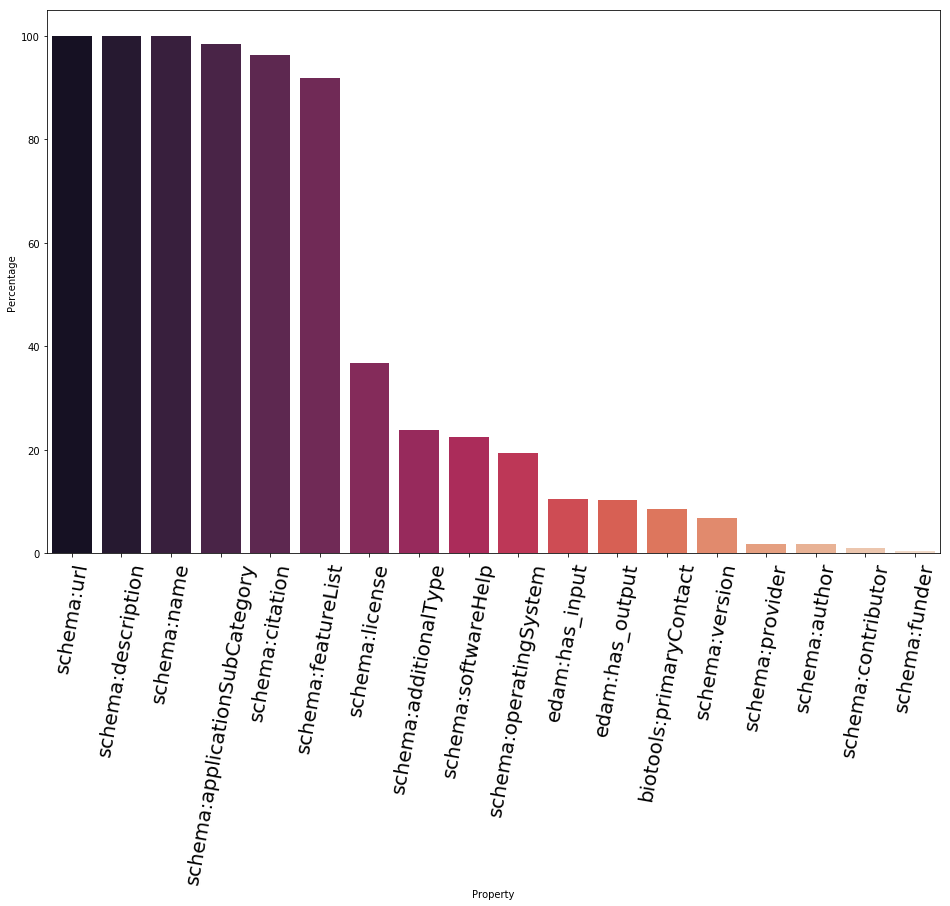

In [31]:
plt.figure(figsize=(16, 10))
chart = sns.barplot(x=df['Property'], y=df['Percentage'], palette="rocket")
chart.set_xticklabels(chart.get_xticklabels(), rotation=80, size=20)